In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [98]:
import os
os.chdir("/home/mbilkis/Desktop/qmon-sindy")
import sys
sys.path.insert(0, os.getcwd())
import numpy as np
from numerics.utilities.misc import *
import torch
from tqdm import tqdm
from scipy.linalg import solve_continuous_are
from numerics.NN.models import *
from numerics.NN.losses import *
from numerics.NN.misc import *



x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")


####
params, exp_path = give_params()
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###

inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [300., -3., -0.01]]


In [97]:
torch.manual_seed(0)

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-3)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

xs_hat, dys_hat, fs_hats = rrn(dys)
loss = log_lik(dys, dys_hat)
history = {}
history["losses"] = [ [loss.item(),err_f(f[:,1],fs_hats)]  ]
history["params"] = [[k.detach().numpy() for k in list(rrn.parameters())]]
history["gradients"] = []


print(loss.item())
print(err_f(f[:,1],fs_hats))
print(history["params"][-1])
print("\n")

for ind in tqdm(range(2)):
    xs_hat, dys_hat, fs_hats = rrn(dys)
    loss = log_lik(dys, dys_hat, dt=dt)
    loss.backward()

    optimizer.step()
    history["losses"].append([loss.item(),err_f(f[:,1],fs_hats)] )
    history["params"].append([k.detach().numpy() for k in list(rrn.parameters())])
    history["gradients"].append([k.grad.numpy() for k in list(rrn.parameters())])

    print("**** iteration {} ****".format(ind))
    print(loss.item())
    print(err_f(f[:,1],fs_hats))
    print(history["params"][-1])
    print("\n")
    optimizer.zero_grad()
    
    save_history(history)

1.3873876333236694
0.6938205441038836
[array(300., dtype=float32), array([ 3.e+02, -3.e+00, -1.e-02], dtype=float32)]




 50%|████████████████████████████████████████████████████████                                                        | 1/2 [00:03<00:03,  3.59s/it]

**** iteration 0 ****
1.1040480136871338
0.6938205441038836
[array(299.999, dtype=float32), array([ 3.000e+02, -2.999e+00, -9.000e-03], dtype=float32)]




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]

**** iteration 1 ****
1.1027110815048218
0.6860523921270738
[array(299.998, dtype=float32), array([ 3.0000000e+02, -2.9979994e+00, -7.9990337e-03], dtype=float32)]




In [91]:
save_history(history)

In [92]:
oo = load_history()

In [70]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)
if len(times)> int(1e8):
    times = np.linspace(times[0],times[-1],int(1e4))
    
plt.figure(figsize=(20,2))
ax=plt.subplot(161)
ax.plot(x[:,0])
ax.set_title("q(t)")
ax=plt.subplot(162)
ax.plot(x[:,1])
ax.set_title("p(t)")

ax=plt.subplot(163)
ax.plot(x[:,0],x[:,1])
ax.set_title("q vs p")
ax=plt.subplot(164)
ax.plot(dy[:,0])
ax.set_title("measurement signal")
ax=plt.subplot(165)
ax.plot(times,f[:,0])
ax.set_title("external q")

ax=plt.subplot(166)
ax.set_title("external p")
ax.plot(times,f[:,1])

NameError: name 'plt' is not defined

In [9]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


In [12]:
class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        
        self.dt, self.simulation_params, initial_force_params = inputs_cell
        gamma, omega, n, eta, kappa, b = self.simulation_params 
        
        self.damping_force = torch.nn.Parameter(data = torch.tensor(initial_force_params[0],dtype=torch.float32,
                                                              requires_grad=True))
        
        self.damping_force_1 = torch.nn.Parameter(data = torch.tensor(.01,dtype=torch.float32,
                                                      requires_grad=True))

        
        self.A = torch.tensor(data=[[-gamma/2, omega],[-omega,-gamma/2]], dtype=torch.float32).detach()
        self.proj_C = torch.tensor(data=[[1.,0.],[0.,0.]], dtype=torch.float32).detach()
        self.C = np.sqrt(4*eta*kappa)*self.proj_C.detach()
        self.D = (gamma*(n+0.5) + kappa)*torch.eye(2).detach()

        self.alphas = torch.nn.Parameter(torch.ones(2), requires_grad=True)
        
        
    def forward(self, dy, state, f):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        x = state[:2]
        [vx,vp,cxp] = state[2:5]
        t = state[-1]
        cov = torch.tensor(data = [[vx,cxp],[cxp,vp]], dtype=torch.float32)
        
        xicov = cov.matmul(self.C.T)
        
        dx = (self.A - xicov.matmul(self.C)).matmul(x)*self.dt + xicov.matmul(dy)
        
        df = self.damping_force*f*self.dt  +   self.dt*self.damping_force_1*f**2
        fnew = f + df
        
        dx += fnew*self.dt
        
        dcov = self.dt*(cov.matmul(self.A.T) + (self.A).matmul(cov) + self.D - (xicov.matmul(xicov.T)))
        ncov = cov+dcov
        

        nstate = torch.concatenate([(x + dx), torch.tensor([ncov[0,0],ncov[1,1],ncov[1,0]]), torch.tensor([t+self.dt])])

        dy_hat = self.C.matmul(x)*self.dt

        return nstate, dy_hat, fnew

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.params = inputs_cell[1]
        
        
        self.amplitude_force = torch.nn.Parameter(data = torch.tensor(inputs_cell[2][1],dtype=torch.float32,
                                                              requires_grad=True))
        
    def forward(self, dys):
        dys_hat = []
        
        ### Find stationary value of covariance for the parameter RCell currently has
        gamma, omega, n, eta, kappa, b = self.params 
        A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
        proj_C = np.array([[1.,0.],[0.,0.]])
        C = np.sqrt(4*eta*kappa)*proj_C
        D = np.diag([gamma*(n+0.5) + kappa]*2)
        G = np.zeros((2,2))
        Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
        t0=0.
        xs_hat = [torch.tensor([0., 0., Cov[0,0], Cov[1,1],Cov[1,0], t0], dtype=torch.float32)]
                                                                       
        #fs_hat = #[torch.self.amplitude_force0]
        fs_hat = [self.amplitude_force]
        
        #xs_hat = torch.concatenate(xs_hat, torch,tensor([self.amplitude_force])), torch.tensor([t0]))
        x_hat = xs_hat[0]
        f_hat = fs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat, f_hat = self.RCell(dy_t, x_hat, f_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
            fs_hat+=[f_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat), torch.stack(fs_hat)
    
    

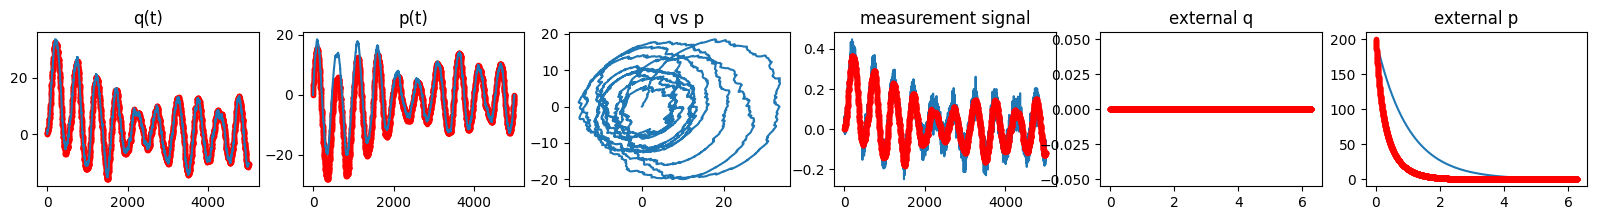

In [10]:

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)

inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [2.,[0., 200.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)
xs_hat, dys_hat,fs_hats = rrn(dys)

plt.figure(figsize=(20,2))
ax=plt.subplot(161)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])

ax.set_title("q(t)")
ax=plt.subplot(162)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])

ax.set_title("p(t)")

ax=plt.subplot(163)
ax.plot(x[:,0],x[:,1])
ax.set_title("q vs p")
ax=plt.subplot(164)
ax.plot(dy[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax.set_title("measurement signal")
ax=plt.subplot(165)
ax.plot(times,f[:,0])
ax.plot(times,fs_hats.detach().numpy()[:-1,0], color="red",marker='.')

ax.set_title("external q")

ax=plt.subplot(166)
ax.set_title("external p")
ax.plot(times,f[:,1])
ax.plot(times,fs_hats.detach().numpy()[:-1,1], color="red",marker='.')



# Training

In [14]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

def err_f(f,fhat):
    return np.sum(np.abs(f - fhat[:-1,:].detach().numpy() ))/np.sum(np.abs(f))

In [17]:
torch.manual_seed(0)
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [2.,[0., 200.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-3)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(rrn.parameters())]
history["gradients"] = []

xs_hat, dys_hat, fs_hats = rrn(dys)

loss = log_lik(dys, dys_hat)
print(loss.item())
print(err_f(f,fs_hats))
print(history["params"][-1])
print("\n")
history["losses"].append([loss.item(),err_f(f,fs_hats)] )

for ind in tqdm(range(20)):
    xs_hat, dys_hat, fs_hats = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    
    optimizer.step()
    history["losses"].append([loss.item(),err_f(f,fs_hats)] )
    history["params"].append([k.detach().numpy() for k in list(rrn.parameters())])
    history["gradients"].append([k.grad.numpy() for k in list(rrn.parameters())])
    
    print("**** iteration {} ****".format(ind))
    print(loss.item())
    print(err_f(f,fs_hats))
    print(history["params"][-1])
    print("\n")
    optimizer.zero_grad()

1.0661225318908691
0.6529758648852894
[1. 1.]




  5%|█████▌                                                                                                         | 1/20 [00:03<01:12,  3.80s/it]

**** iteration 0 ****
1.0661225318908691
0.6529758648852894
[array(1.999, dtype=float32), array(0.009, dtype=float32), array([0.999, 0.999], dtype=float32)]




 10%|███████████                                                                                                    | 2/20 [00:07<01:03,  3.55s/it]

**** iteration 1 ****
1.064027190208435
0.6424431402126803
[array(1.9979993, dtype=float32), array(0.00799901, dtype=float32), array([0.9979993, 0.9980018], dtype=float32)]




 15%|████████████████▋                                                                                              | 3/20 [00:10<00:59,  3.48s/it]

**** iteration 2 ****
1.061824083328247
0.6310902986012418
[array(1.9969975, dtype=float32), array(0.00699634, dtype=float32), array([0.9969974 , 0.99700713], dtype=float32)]




 20%|██████████████████████▏                                                                                        | 4/20 [00:13<00:54,  3.43s/it]

**** iteration 3 ****
1.059502124786377
0.6187965106414787
[array(1.9959939, dtype=float32), array(0.00599129, dtype=float32), array([0.9959938, 0.9960184], dtype=float32)]




 25%|███████████████████████████▊                                                                                   | 5/20 [00:17<00:51,  3.44s/it]

**** iteration 4 ****
1.0570495128631592
0.6054161979940726
[array(1.9949881, dtype=float32), array(0.00498314, dtype=float32), array([0.99498796, 0.995039  ], dtype=float32)]




 30%|█████████████████████████████████▎                                                                             | 6/20 [00:20<00:47,  3.40s/it]

**** iteration 5 ****
1.0544521808624268
0.5907691514111848
[array(1.9939796, dtype=float32), array(0.00397114, dtype=float32), array([0.9939794 , 0.99407345], dtype=float32)]




 35%|██████████████████████████████████████▊                                                                        | 7/20 [00:24<00:44,  3.42s/it]

**** iteration 6 ****
1.0516947507858276
0.5746312837747318
[array(1.9929678, dtype=float32), array(0.00295456, dtype=float32), array([0.9929675 , 0.99312836], dtype=float32)]




 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:27<00:40,  3.39s/it]

**** iteration 7 ****
1.0487598180770874
0.5567177162227284
[array(1.9919523, dtype=float32), array(0.00193263, dtype=float32), array([0.99195176, 0.992213  ], dtype=float32)]




 45%|█████████████████████████████████████████████████▉                                                             | 9/20 [00:30<00:37,  3.41s/it]

**** iteration 8 ****
1.0456281900405884
0.5366627786485119
[array(1.9909325, dtype=float32), array(0.00090461, dtype=float32), array([0.9909317, 0.9913408], dtype=float32)]




 50%|███████████████████████████████████████████████████████                                                       | 10/20 [00:34<00:33,  3.38s/it]

**** iteration 9 ****
1.0422794818878174
0.5139847497824582
[array(1.9899077, dtype=float32), array(-0.00013027, dtype=float32), array([0.9899067, 0.990531 ], dtype=float32)]




 55%|████████████████████████████████████████████████████████████▌                                                 | 11/20 [00:37<00:30,  3.38s/it]

**** iteration 10 ****
1.0386919975280762
0.48803214805023243
[array(1.9888778, dtype=float32), array(-0.00117269, dtype=float32), array([0.98887646, 0.9898104 ], dtype=float32)]




 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:40<00:26,  3.36s/it]

**** iteration 11 ****
1.034847378730774
0.45790321289967134
[array(1.9878423, dtype=float32), array(-0.00222329, dtype=float32), array([0.9878406, 0.9892143], dtype=float32)]




 65%|███████████████████████████████████████████████████████████████████████▌                                      | 13/20 [00:44<00:23,  3.38s/it]

**** iteration 12 ****
1.030734896659851
0.4222964593111897
[array(1.9868013, dtype=float32), array(-0.00328253, dtype=float32), array([0.98679906, 0.98878336], dtype=float32)]




 70%|█████████████████████████████████████████████████████████████████████████████                                 | 14/20 [00:47<00:20,  3.35s/it]

**** iteration 13 ****
1.0263681411743164
0.37925529455731893
[array(1.9857551, dtype=float32), array(-0.00435046, dtype=float32), array([0.98575234, 0.9885533 ], dtype=float32)]




 75%|██████████████████████████████████████████████████████████████████████████████████▌                           | 15/20 [00:51<00:16,  3.37s/it]

**** iteration 14 ****
1.0218217372894287
0.3256688485563867
[array(1.9847058, dtype=float32), array(-0.00542609, dtype=float32), array([0.98470247, 0.98853844], dtype=float32)]




 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:54<00:13,  3.34s/it]

**** iteration 15 ****
1.0173351764678955
0.25844767039318295
[array(1.9836595, dtype=float32), array(-0.0065047, dtype=float32), array([0.9836554, 0.9887183], dtype=float32)]




 85%|█████████████████████████████████████████████████████████████████████████████████████████████▌                | 17/20 [00:57<00:09,  3.33s/it]

**** iteration 16 ****
1.0136189460754395
0.2048315087291895
[array(1.9826376, dtype=float32), array(-0.00756238, dtype=float32), array([0.98263264, 0.98902017], dtype=float32)]




 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 18/20 [01:01<00:06,  3.35s/it]

**** iteration 17 ****
1.0128698348999023
0.20800725160061398
[array(1.9817495, dtype=float32), array(-0.00842247, dtype=float32), array([0.9817439, 0.9891394], dtype=float32)]




 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 19/20 [01:04<00:03,  3.34s/it]

**** iteration 18 ****
1.0198794603347778
0.29746469273133913
[array(1.9814236, dtype=float32), array(-0.00849202, dtype=float32), array([0.98141956, 0.98871523], dtype=float32)]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.39s/it]

**** iteration 19 ****
1.0211913585662842
0.31102139579732474
[array(1.9814742, dtype=float32), array(-0.00819659, dtype=float32), array([0.98147213, 0.98808163], dtype=float32)]




In [20]:

for ind in tqdm(range(1000)):
    xs_hat, dys_hat, fs_hats = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    
    optimizer.step()
    history["losses"].append([loss.item(),err_f(f,fs_hats)] )
    history["params"].append([k.detach().numpy() for k in list(rrn.parameters())])
    history["gradients"].append([k.grad.numpy() for k in list(rrn.parameters())])
    
    print("**** iteration {} ****".format(ind))
    print(loss.item())
    print(err_f(f,fs_hats))
    print(history["params"][-1])
    print("\n")
    optimizer.zero_grad()

  0%|                                                                                                             | 1/1000 [00:03<58:55,  3.54s/it]

**** iteration 0 ****
1.0119514465332031
0.18039580291860652
[array(1.9425886, dtype=float32), array(-0.0064926, dtype=float32), array([0.9422161, 0.9815234], dtype=float32)]




  0%|▏                                                                                                            | 2/1000 [00:06<57:29,  3.46s/it]

**** iteration 1 ****
1.0119479894638062
0.18027949389595171
[array(1.9423338, dtype=float32), array(-0.00648759, dtype=float32), array([0.9419562 , 0.98151916], dtype=float32)]




  0%|▎                                                                                                            | 3/1000 [00:10<57:44,  3.48s/it]

**** iteration 2 ****
1.0119444131851196
0.18016279232040755
[array(1.9420787, dtype=float32), array(-0.00648255, dtype=float32), array([0.94169587, 0.9815149 ], dtype=float32)]




  0%|▍                                                                                                            | 4/1000 [00:13<57:22,  3.46s/it]

**** iteration 3 ****
1.011940836906433
0.1800457265192533
[array(1.9418231, dtype=float32), array(-0.00647751, dtype=float32), array([0.941435 , 0.9815106], dtype=float32)]




  0%|▌                                                                                                            | 5/1000 [00:17<57:28,  3.47s/it]

**** iteration 4 ****
1.0119372606277466
0.17992813911088
[array(1.9415671, dtype=float32), array(-0.00647245, dtype=float32), array([0.9411736, 0.9815063], dtype=float32)]




  1%|▋                                                                                                            | 6/1000 [00:20<57:10,  3.45s/it]

**** iteration 5 ****
1.0119339227676392
0.17981052479129736
[array(1.9413105, dtype=float32), array(-0.00646739, dtype=float32), array([0.94091177, 0.981502  ], dtype=float32)]




  1%|▊                                                                                                            | 7/1000 [00:24<57:31,  3.48s/it]

**** iteration 6 ****
1.011930227279663
0.17969228160988895
[array(1.9410535, dtype=float32), array(-0.00646233, dtype=float32), array([0.9406494, 0.9814977], dtype=float32)]




  1%|▊                                                                                                            | 8/1000 [00:27<56:51,  3.44s/it]

**** iteration 7 ****
1.0119267702102661
0.17957414212630518
[array(1.940796, dtype=float32), array(-0.00645727, dtype=float32), array([0.94038653, 0.9814934 ], dtype=float32)]




  1%|▉                                                                                                            | 9/1000 [00:31<57:02,  3.45s/it]

**** iteration 8 ****
1.01192307472229
0.1794558506440478
[array(1.9405382, dtype=float32), array(-0.00645222, dtype=float32), array([0.94012314, 0.9814891 ], dtype=float32)]




  1%|█                                                                                                           | 10/1000 [00:34<56:53,  3.45s/it]

**** iteration 9 ****
1.0119194984436035
0.17933790416217307
[array(1.9402798, dtype=float32), array(-0.00644716, dtype=float32), array([0.9398593 , 0.98148483], dtype=float32)]




  1%|█▏                                                                                                          | 11/1000 [00:38<57:03,  3.46s/it]

**** iteration 10 ****
1.0119160413742065
0.17921964083397968
[array(1.940021, dtype=float32), array(-0.0064421, dtype=float32), array([0.93959486, 0.98148054], dtype=float32)]




  1%|█▎                                                                                                          | 12/1000 [00:41<56:35,  3.44s/it]

**** iteration 11 ****
1.0119123458862305
0.17910112963554567
[array(1.9397618, dtype=float32), array(-0.00643702, dtype=float32), array([0.93933   , 0.98147625], dtype=float32)]




  1%|█▍                                                                                                          | 13/1000 [00:44<56:13,  3.42s/it]

**** iteration 12 ****
1.0119086503982544
0.17898179540107617
[array(1.9395021, dtype=float32), array(-0.00643194, dtype=float32), array([0.9390646 , 0.98147196], dtype=float32)]




  1%|█▌                                                                                                          | 14/1000 [00:48<56:20,  3.43s/it]

**** iteration 13 ****
1.0119051933288574
0.17886253497970311
[array(1.939242, dtype=float32), array(-0.00642683, dtype=float32), array([0.9387988 , 0.98146766], dtype=float32)]




  2%|█▌                                                                                                          | 15/1000 [00:51<56:05,  3.42s/it]

**** iteration 14 ****
1.011901617050171
0.17874319675697758
[array(1.9389814, dtype=float32), array(-0.00642172, dtype=float32), array([0.9385325, 0.9814634], dtype=float32)]




  2%|█▋                                                                                                          | 16/1000 [00:55<56:36,  3.45s/it]

**** iteration 15 ****
1.0118980407714844
0.17862338359686036
[array(1.9387205, dtype=float32), array(-0.00641658, dtype=float32), array([0.9382657, 0.9814591], dtype=float32)]




  2%|█▊                                                                                                          | 17/1000 [00:58<56:07,  3.43s/it]

**** iteration 16 ****
1.0118944644927979
0.17850325418851143
[array(1.938459, dtype=float32), array(-0.00641143, dtype=float32), array([0.9379984, 0.9814548], dtype=float32)]




  2%|█▉                                                                                                          | 18/1000 [01:02<56:16,  3.44s/it]

**** iteration 17 ****
1.0118907690048218
0.17838268933742732
[array(1.9381973, dtype=float32), array(-0.00640627, dtype=float32), array([0.9377307 , 0.98145044], dtype=float32)]




  2%|██                                                                                                          | 19/1000 [01:05<55:49,  3.41s/it]

**** iteration 18 ****
1.0118871927261353
0.17826210292800984
[array(1.937935, dtype=float32), array(-0.0064011, dtype=float32), array([0.93746257, 0.9814461 ], dtype=float32)]




  2%|██▏                                                                                                         | 20/1000 [01:08<56:12,  3.44s/it]

**** iteration 19 ****
1.0118834972381592
0.1781410621333716
[array(1.9376724, dtype=float32), array(-0.00639593, dtype=float32), array([0.93719393, 0.98144174], dtype=float32)]




  2%|██▎                                                                                                         | 21/1000 [01:12<55:51,  3.42s/it]

**** iteration 20 ****
1.0118799209594727
0.1780193119998482
[array(1.9374093, dtype=float32), array(-0.00639075, dtype=float32), array([0.9369248, 0.9814374], dtype=float32)]




  2%|██▍                                                                                                         | 22/1000 [01:15<55:26,  3.40s/it]

**** iteration 21 ****
1.0118763446807861
0.17789774802954994
[array(1.9371457, dtype=float32), array(-0.00638557, dtype=float32), array([0.9366552 , 0.98143303], dtype=float32)]




  2%|██▍                                                                                                         | 23/1000 [01:19<55:43,  3.42s/it]

**** iteration 22 ****
1.0118727684020996
0.17777599531622307
[array(1.9368818, dtype=float32), array(-0.00638039, dtype=float32), array([0.93638515, 0.9814287 ], dtype=float32)]




  2%|██▌                                                                                                         | 24/1000 [01:22<55:27,  3.41s/it]

**** iteration 23 ****
1.0118690729141235
0.1776545536003024
[array(1.9366174, dtype=float32), array(-0.00637521, dtype=float32), array([0.9361146 , 0.98142433], dtype=float32)]




  2%|██▋                                                                                                         | 25/1000 [01:26<56:13,  3.46s/it]

**** iteration 24 ****
1.011865496635437
0.17753259057866844
[array(1.9363526, dtype=float32), array(-0.00637001, dtype=float32), array([0.9358436, 0.98142  ], dtype=float32)]




  3%|██▊                                                                                                         | 26/1000 [01:29<55:41,  3.43s/it]

**** iteration 25 ****
1.011861801147461
0.17741014446106912
[array(1.9360874, dtype=float32), array(-0.00636481, dtype=float32), array([0.9355721, 0.9814156], dtype=float32)]




  3%|██▉                                                                                                         | 27/1000 [01:32<55:56,  3.45s/it]

**** iteration 26 ****
1.0118582248687744
0.17728879709541248
[array(1.9358218, dtype=float32), array(-0.0063596, dtype=float32), array([0.9353002, 0.9814113], dtype=float32)]




  3%|███                                                                                                         | 28/1000 [01:36<55:40,  3.44s/it]

**** iteration 27 ****
1.0118545293807983
0.17716565335040854
[array(1.9355557, dtype=float32), array(-0.00635437, dtype=float32), array([0.9350278, 0.9814069], dtype=float32)]




  3%|███▏                                                                                                        | 29/1000 [01:39<55:48,  3.45s/it]

**** iteration 28 ****
1.0118507146835327
0.17704261402254598
[array(1.9352893, dtype=float32), array(-0.00634913, dtype=float32), array([0.9347549, 0.9814026], dtype=float32)]




  3%|███▏                                                                                                        | 30/1000 [01:43<55:30,  3.43s/it]

**** iteration 29 ****
1.0118471384048462
0.17691948699853735
[array(1.9350225, dtype=float32), array(-0.00634388, dtype=float32), array([0.9344816, 0.9813982], dtype=float32)]




  3%|███▎                                                                                                        | 31/1000 [01:46<55:29,  3.44s/it]

**** iteration 30 ****
1.0118435621261597
0.17679587231482624
[array(1.9347552, dtype=float32), array(-0.00633862, dtype=float32), array([0.93420786, 0.9813939 ], dtype=float32)]




  3%|███▍                                                                                                        | 32/1000 [01:49<55:01,  3.41s/it]

**** iteration 31 ****
1.0118398666381836
0.17667191097972462
[array(1.9344876, dtype=float32), array(-0.00633334, dtype=float32), array([0.9339337, 0.9813895], dtype=float32)]




  3%|███▌                                                                                                        | 33/1000 [01:53<55:18,  3.43s/it]

**** iteration 32 ****
1.0118361711502075
0.1765478868629045
[array(1.9342196, dtype=float32), array(-0.00632806, dtype=float32), array([0.933659 , 0.9813852], dtype=float32)]




  3%|███▋                                                                                                        | 34/1000 [01:56<54:52,  3.41s/it]

**** iteration 33 ****
1.0118324756622314
0.17642353733846794
[array(1.9339511, dtype=float32), array(-0.00632278, dtype=float32), array([0.93338394, 0.9813808 ], dtype=float32)]




  4%|███▊                                                                                                        | 35/1000 [02:00<55:07,  3.43s/it]

**** iteration 34 ****
1.0118287801742554
0.17629904906664767
[array(1.9336823, dtype=float32), array(-0.00631749, dtype=float32), array([0.9331084 , 0.98137647], dtype=float32)]




  4%|███▉                                                                                                        | 36/1000 [02:03<54:45,  3.41s/it]

**** iteration 35 ****
1.0118250846862793
0.1761741440773075
[array(1.9334131, dtype=float32), array(-0.0063122, dtype=float32), array([0.9328324, 0.9813721], dtype=float32)]




  4%|███▉                                                                                                        | 37/1000 [02:07<55:03,  3.43s/it]

**** iteration 36 ****
1.0118215084075928
0.17604939427790975
[array(1.9331435, dtype=float32), array(-0.0063069, dtype=float32), array([0.932556  , 0.98136777], dtype=float32)]




  4%|████                                                                                                        | 38/1000 [02:10<54:51,  3.42s/it]

**** iteration 37 ****
1.0118178129196167
0.17592444067686033
[array(1.9328735, dtype=float32), array(-0.00630159, dtype=float32), array([0.9322791, 0.9813634], dtype=float32)]




  4%|████▏                                                                                                       | 39/1000 [02:13<54:32,  3.41s/it]

**** iteration 38 ****
1.011813998222351
0.1757990529698443
[array(1.9326031, dtype=float32), array(-0.00629628, dtype=float32), array([0.93200177, 0.98135906], dtype=float32)]




  4%|████▎                                                                                                       | 40/1000 [02:17<54:54,  3.43s/it]

**** iteration 39 ****
1.0118104219436646
0.17567411238194897
[array(1.9323323, dtype=float32), array(-0.00629096, dtype=float32), array([0.931724  , 0.98135465], dtype=float32)]




  4%|████▍                                                                                                       | 41/1000 [02:20<54:43,  3.42s/it]

**** iteration 40 ****
1.0118067264556885
0.17554822136685852
[array(1.9320611, dtype=float32), array(-0.00628563, dtype=float32), array([0.93144584, 0.98135024], dtype=float32)]




  4%|████▌                                                                                                       | 42/1000 [02:24<54:52,  3.44s/it]

**** iteration 41 ****
1.0118029117584229
0.1754218996159092
[array(1.9317895, dtype=float32), array(-0.00628028, dtype=float32), array([0.93116724, 0.98134583], dtype=float32)]




  4%|████▋                                                                                                       | 43/1000 [02:27<54:25,  3.41s/it]

**** iteration 42 ****
1.0117992162704468
0.17529574939342693
[array(1.9315176, dtype=float32), array(-0.00627493, dtype=float32), array([0.9308882, 0.9813414], dtype=float32)]




  4%|████▊                                                                                                       | 44/1000 [02:31<54:31,  3.42s/it]

**** iteration 43 ****
1.0117955207824707
0.17516921497985832
[array(1.9312453, dtype=float32), array(-0.00626956, dtype=float32), array([0.9306087, 0.981337 ], dtype=float32)]




  4%|████▊                                                                                                       | 45/1000 [02:34<54:19,  3.41s/it]

**** iteration 44 ****
1.0117918252944946
0.17504231788957236
[array(1.9309727, dtype=float32), array(-0.00626419, dtype=float32), array([0.9303288, 0.9813326], dtype=float32)]




  5%|████▉                                                                                                       | 46/1000 [02:37<54:37,  3.44s/it]

**** iteration 45 ****
1.0117881298065186
0.17491530348134554
[array(1.9306996, dtype=float32), array(-0.00625881, dtype=float32), array([0.93004847, 0.9813282 ], dtype=float32)]




  5%|█████                                                                                                       | 47/1000 [02:41<54:15,  3.42s/it]

**** iteration 46 ****
1.0117844343185425
0.17478833004986352
[array(1.9304261, dtype=float32), array(-0.00625343, dtype=float32), array([0.9297677, 0.9813238], dtype=float32)]




  5%|█████▏                                                                                                      | 48/1000 [02:44<53:53,  3.40s/it]

**** iteration 47 ****
1.0117807388305664
0.174660649708711
[array(1.9301523, dtype=float32), array(-0.00624804, dtype=float32), array([0.9294866 , 0.98131937], dtype=float32)]




  5%|█████▎                                                                                                      | 49/1000 [02:48<54:07,  3.41s/it]

**** iteration 48 ****
1.0117769241333008
0.1745329515861516
[array(1.9298781, dtype=float32), array(-0.00624264, dtype=float32), array([0.92920494, 0.98131496], dtype=float32)]




  5%|█████▍                                                                                                      | 50/1000 [02:51<53:49,  3.40s/it]

**** iteration 49 ****
1.0117732286453247
0.1744048504983533
[array(1.9296036, dtype=float32), array(-0.00623724, dtype=float32), array([0.9289229 , 0.98131055], dtype=float32)]




  5%|█████▌                                                                                                      | 51/1000 [02:55<54:27,  3.44s/it]

**** iteration 50 ****
1.011769413948059
0.17427722196525433
[array(1.9293287, dtype=float32), array(-0.00623183, dtype=float32), array([0.9286404 , 0.98130614], dtype=float32)]




  5%|█████▌                                                                                                      | 52/1000 [02:58<54:00,  3.42s/it]

**** iteration 51 ****
1.011765718460083
0.17414902604019183
[array(1.9290534, dtype=float32), array(-0.00622642, dtype=float32), array([0.92835754, 0.9813017 ], dtype=float32)]




  5%|█████▋                                                                                                      | 53/1000 [03:01<54:16,  3.44s/it]

**** iteration 52 ****
1.011762022972107
0.1740200679346763
[array(1.9287778, dtype=float32), array(-0.00622099, dtype=float32), array([0.92807424, 0.9812973 ], dtype=float32)]




  5%|█████▊                                                                                                      | 54/1000 [03:05<53:54,  3.42s/it]

**** iteration 53 ****
1.0117582082748413
0.17389156636289302
[array(1.9285018, dtype=float32), array(-0.00621556, dtype=float32), array([0.9277906, 0.9812929], dtype=float32)]




  6%|█████▉                                                                                                      | 55/1000 [03:08<54:06,  3.44s/it]

**** iteration 54 ****
1.0117545127868652
0.17376294015639399
[array(1.9282255, dtype=float32), array(-0.00621012, dtype=float32), array([0.9275065, 0.9812885], dtype=float32)]




  6%|██████                                                                                                      | 56/1000 [03:12<53:51,  3.42s/it]

**** iteration 55 ****
1.0117506980895996
0.17363402127603592
[array(1.9279488, dtype=float32), array(-0.00620467, dtype=float32), array([0.927222 , 0.9812841], dtype=float32)]




  6%|██████▏                                                                                                     | 57/1000 [03:15<54:04,  3.44s/it]

**** iteration 56 ****
1.011746883392334
0.17350402353790917
[array(1.9276718, dtype=float32), array(-0.00619921, dtype=float32), array([0.9269371, 0.9812797], dtype=float32)]




  6%|██████▎                                                                                                     | 58/1000 [03:18<53:45,  3.42s/it]

**** iteration 57 ****
1.011743187904358
0.17337479606290473
[array(1.9273944, dtype=float32), array(-0.00619375, dtype=float32), array([0.9266518 , 0.98127526], dtype=float32)]




  6%|██████▎                                                                                                     | 59/1000 [03:22<53:59,  3.44s/it]

**** iteration 58 ****
1.0117393732070923
0.17324445508428704
[array(1.9271166, dtype=float32), array(-0.00618827, dtype=float32), array([0.92636603, 0.98127085], dtype=float32)]




  6%|██████▍                                                                                                     | 60/1000 [03:25<53:47,  3.43s/it]

**** iteration 59 ****
1.0117356777191162
0.17311457229167126
[array(1.9268385, dtype=float32), array(-0.00618279, dtype=float32), array([0.9260799 , 0.98126644], dtype=float32)]




  6%|██████▌                                                                                                     | 61/1000 [03:29<54:11,  3.46s/it]

**** iteration 60 ****
1.0117318630218506
0.17298456231884188
[array(1.92656, dtype=float32), array(-0.00617731, dtype=float32), array([0.9257934, 0.981262 ], dtype=float32)]




  6%|██████▋                                                                                                     | 62/1000 [03:32<53:41,  3.43s/it]

**** iteration 61 ****
1.0117281675338745
0.17285361349958037
[array(1.9262812, dtype=float32), array(-0.00617181, dtype=float32), array([0.9255065 , 0.98125756], dtype=float32)]




  6%|██████▊                                                                                                     | 63/1000 [03:36<53:49,  3.45s/it]

**** iteration 62 ****
1.0117243528366089
0.1727231161265185
[array(1.926002, dtype=float32), array(-0.00616632, dtype=float32), array([0.9252191, 0.9812531], dtype=float32)]




  6%|██████▉                                                                                                     | 64/1000 [03:39<53:22,  3.42s/it]

**** iteration 63 ****
1.0117206573486328
0.17259234686572114
[array(1.9257225, dtype=float32), array(-0.00616081, dtype=float32), array([0.9249314, 0.9812486], dtype=float32)]




  6%|███████                                                                                                     | 65/1000 [03:43<53:08,  3.41s/it]

**** iteration 64 ****
1.0117167234420776
0.17246104949778096
[array(1.9254426, dtype=float32), array(-0.0061553, dtype=float32), array([0.9246433 , 0.98124415], dtype=float32)]




  7%|███████▏                                                                                                    | 66/1000 [03:46<53:22,  3.43s/it]

**** iteration 65 ****
1.0117130279541016
0.17232975136183143
[array(1.9251624, dtype=float32), array(-0.00614978, dtype=float32), array([0.92435473, 0.9812397 ], dtype=float32)]




  7%|███████▏                                                                                                    | 67/1000 [03:49<52:57,  3.41s/it]

**** iteration 66 ****
1.0117093324661255
0.1721982010850676
[array(1.9248819, dtype=float32), array(-0.00614425, dtype=float32), array([0.9240658, 0.9812352], dtype=float32)]




  7%|███████▎                                                                                                    | 68/1000 [03:53<53:19,  3.43s/it]

**** iteration 67 ****
1.0117053985595703
0.17206652953413212
[array(1.9246011, dtype=float32), array(-0.00613872, dtype=float32), array([0.9237765 , 0.98123074], dtype=float32)]




  7%|███████▍                                                                                                    | 69/1000 [03:56<52:59,  3.41s/it]

**** iteration 68 ****
1.0117017030715942
0.17193473899471542
[array(1.9243199, dtype=float32), array(-0.00613317, dtype=float32), array([0.9234868 , 0.98122627], dtype=float32)]




  7%|███████▌                                                                                                    | 70/1000 [04:00<53:12,  3.43s/it]

**** iteration 69 ****
1.0116978883743286
0.17180236238529595
[array(1.9240383, dtype=float32), array(-0.00612762, dtype=float32), array([0.92319673, 0.9812218 ], dtype=float32)]




  7%|███████▋                                                                                                    | 71/1000 [04:03<52:51,  3.41s/it]

**** iteration 70 ****
1.011694073677063
0.17167025852121703
[array(1.9237565, dtype=float32), array(-0.00612207, dtype=float32), array([0.9229063, 0.9812173], dtype=float32)]




  7%|███████▊                                                                                                    | 72/1000 [04:07<53:04,  3.43s/it]

**** iteration 71 ****
1.0116901397705078
0.1715372675977493
[array(1.9234743, dtype=float32), array(-0.0061165, dtype=float32), array([0.9226154 , 0.98121285], dtype=float32)]




  7%|███████▉                                                                                                    | 73/1000 [04:10<52:56,  3.43s/it]

**** iteration 72 ****
1.0116864442825317
0.17140421999750685
[array(1.9231918, dtype=float32), array(-0.00611093, dtype=float32), array([0.9223242, 0.9812084], dtype=float32)]




  7%|███████▉                                                                                                    | 74/1000 [04:13<52:35,  3.41s/it]

**** iteration 73 ****
1.0116826295852661
0.1712712930085501
[array(1.9229089, dtype=float32), array(-0.00610535, dtype=float32), array([0.9220326, 0.9812039], dtype=float32)]




  8%|████████                                                                                                    | 75/1000 [04:17<52:47,  3.42s/it]

**** iteration 74 ****
1.0116788148880005
0.17113853118986122
[array(1.9226258, dtype=float32), array(-0.00609977, dtype=float32), array([0.9217406 , 0.98119944], dtype=float32)]




  8%|████████▏                                                                                                   | 76/1000 [04:20<52:42,  3.42s/it]

**** iteration 75 ****
1.0116751194000244
0.171004771772115
[array(1.9223423, dtype=float32), array(-0.00609418, dtype=float32), array([0.92144823, 0.981195  ], dtype=float32)]




  8%|████████▎                                                                                                   | 77/1000 [04:24<52:57,  3.44s/it]

**** iteration 76 ****
1.0116711854934692
0.17087100256878435
[array(1.9220585, dtype=float32), array(-0.00608858, dtype=float32), array([0.92115545, 0.9811905 ], dtype=float32)]




  8%|████████▍                                                                                                   | 78/1000 [04:27<52:32,  3.42s/it]

**** iteration 77 ****
1.0116673707962036
0.1707369800552953
[array(1.9217743, dtype=float32), array(-0.00608298, dtype=float32), array([0.9208623 , 0.98118603], dtype=float32)]




  8%|████████▌                                                                                                   | 79/1000 [04:31<52:51,  3.44s/it]

**** iteration 78 ****
1.011663556098938
0.17060345635486274
[array(1.9214898, dtype=float32), array(-0.00607737, dtype=float32), array([0.9205688 , 0.98118156], dtype=float32)]




  8%|████████▋                                                                                                   | 80/1000 [04:34<52:30,  3.42s/it]

**** iteration 79 ****
1.0116597414016724
0.17046878624078943
[array(1.921205, dtype=float32), array(-0.00607176, dtype=float32), array([0.920275 , 0.9811771], dtype=float32)]




  8%|████████▋                                                                                                   | 81/1000 [04:37<52:50,  3.45s/it]

**** iteration 80 ****
1.0116559267044067
0.17033452196625834
[array(1.92092, dtype=float32), array(-0.00606614, dtype=float32), array([0.9199807, 0.9811726], dtype=float32)]




  8%|████████▊                                                                                                   | 82/1000 [04:41<52:28,  3.43s/it]

**** iteration 81 ****
1.0116521120071411
0.17019965463794628
[array(1.9206346, dtype=float32), array(-0.00606051, dtype=float32), array([0.9196861 , 0.98116815], dtype=float32)]




  8%|████████▉                                                                                                   | 83/1000 [04:44<52:47,  3.45s/it]

**** iteration 82 ****
1.0116482973098755
0.17006480604429633
[array(1.9203489, dtype=float32), array(-0.00605488, dtype=float32), array([0.9193911, 0.9811637], dtype=float32)]




  8%|█████████                                                                                                   | 84/1000 [04:48<52:23,  3.43s/it]

**** iteration 83 ****
1.0116444826126099
0.1699296097985823
[array(1.9200629, dtype=float32), array(-0.00604923, dtype=float32), array([0.91909575, 0.9811592 ], dtype=float32)]




  8%|█████████▏                                                                                                  | 85/1000 [04:51<52:36,  3.45s/it]

**** iteration 84 ****
1.0116405487060547
0.16979416336961486
[array(1.9197766, dtype=float32), array(-0.00604358, dtype=float32), array([0.91880006, 0.98115474], dtype=float32)]




  9%|█████████▎                                                                                                  | 86/1000 [04:55<51:59,  3.41s/it]

**** iteration 85 ****
1.011636734008789
0.16965901145014503
[array(1.91949, dtype=float32), array(-0.00603792, dtype=float32), array([0.918504  , 0.98115027], dtype=float32)]




  9%|█████████▍                                                                                                  | 87/1000 [04:58<52:08,  3.43s/it]

**** iteration 86 ****
1.0116329193115234
0.1695229767368084
[array(1.919203, dtype=float32), array(-0.00603226, dtype=float32), array([0.9182076, 0.9811458], dtype=float32)]




  9%|█████████▌                                                                                                  | 88/1000 [05:01<52:02,  3.42s/it]

**** iteration 87 ****
1.0116291046142578
0.16938713629593316
[array(1.9189157, dtype=float32), array(-0.00602659, dtype=float32), array([0.9179108, 0.9811413], dtype=float32)]




  9%|█████████▌                                                                                                  | 89/1000 [05:05<52:10,  3.44s/it]

**** iteration 88 ****
1.0116251707077026
0.16925107227003727
[array(1.9186282, dtype=float32), array(-0.00602092, dtype=float32), array([0.9176137 , 0.98113686], dtype=float32)]




  9%|█████████▋                                                                                                  | 90/1000 [05:08<52:19,  3.45s/it]

**** iteration 89 ****
1.011621356010437
0.169114575580616
[array(1.9183403, dtype=float32), array(-0.00601524, dtype=float32), array([0.9173162, 0.9811324], dtype=float32)]




  9%|█████████▊                                                                                                  | 91/1000 [05:12<52:03,  3.44s/it]

**** iteration 90 ****
1.0116175413131714
0.16897819020888102
[array(1.9180522, dtype=float32), array(-0.00600955, dtype=float32), array([0.91701835, 0.9811279 ], dtype=float32)]




  9%|█████████▉                                                                                                  | 92/1000 [05:15<52:27,  3.47s/it]

**** iteration 91 ****
1.0116136074066162
0.16884120039335943
[array(1.9177637, dtype=float32), array(-0.00600386, dtype=float32), array([0.91672015, 0.98112345], dtype=float32)]




  9%|██████████                                                                                                  | 93/1000 [05:19<51:57,  3.44s/it]

**** iteration 92 ****
1.0116097927093506
0.16870460511475513
[array(1.917475, dtype=float32), array(-0.00599816, dtype=float32), array([0.9164216, 0.981119 ], dtype=float32)]




  9%|██████████▏                                                                                                 | 94/1000 [05:22<52:08,  3.45s/it]

**** iteration 93 ****
1.011605978012085
0.1685674939552681
[array(1.917186, dtype=float32), array(-0.00599246, dtype=float32), array([0.9161227, 0.9811145], dtype=float32)]




 10%|██████████▎                                                                                                 | 95/1000 [05:26<52:15,  3.46s/it]

**** iteration 94 ****
1.0116021633148193
0.16843001336132735
[array(1.9168967, dtype=float32), array(-0.00598675, dtype=float32), array([0.9158234 , 0.98111004], dtype=float32)]




 10%|██████████▎                                                                                                 | 96/1000 [05:29<52:07,  3.46s/it]

**** iteration 95 ****
1.0115983486175537
0.16829253217439413
[array(1.9166071, dtype=float32), array(-0.00598103, dtype=float32), array([0.91552377, 0.98110557], dtype=float32)]




 10%|██████████▍                                                                                                 | 97/1000 [05:32<51:41,  3.43s/it]

**** iteration 96 ****
1.0115944147109985
0.16815508917444633
[array(1.9163172, dtype=float32), array(-0.00597531, dtype=float32), array([0.9152238, 0.9811011], dtype=float32)]




 10%|██████████▌                                                                                                 | 98/1000 [05:36<52:02,  3.46s/it]

**** iteration 97 ****
1.011590600013733
0.1680170386808913
[array(1.9160271, dtype=float32), array(-0.00596958, dtype=float32), array([0.9149235, 0.9810966], dtype=float32)]




 10%|██████████▋                                                                                                 | 99/1000 [05:39<51:38,  3.44s/it]

**** iteration 98 ****
1.0115866661071777
0.16787912198232316
[array(1.9157366, dtype=float32), array(-0.00596384, dtype=float32), array([0.91462284, 0.98109215], dtype=float32)]




 10%|██████████▋                                                                                                | 100/1000 [05:43<51:12,  3.41s/it]

**** iteration 99 ****
1.0115827322006226
0.16774033500347127
[array(1.9154458, dtype=float32), array(-0.0059581, dtype=float32), array([0.91432184, 0.9810877 ], dtype=float32)]




 10%|██████████▊                                                                                                | 101/1000 [05:46<51:32,  3.44s/it]

**** iteration 100 ****
1.011578917503357
0.1676020533292279
[array(1.9151548, dtype=float32), array(-0.00595235, dtype=float32), array([0.9140205, 0.9810832], dtype=float32)]




 10%|██████████▉                                                                                                | 102/1000 [05:50<51:11,  3.42s/it]

**** iteration 101 ****
1.0115749835968018
0.16746361095007298
[array(1.9148635, dtype=float32), array(-0.00594659, dtype=float32), array([0.9137188 , 0.98107874], dtype=float32)]




 10%|███████████                                                                                                | 103/1000 [05:53<51:21,  3.43s/it]

**** iteration 102 ****
1.0115711688995361
0.16732424926726494
[array(1.9145719, dtype=float32), array(-0.00594083, dtype=float32), array([0.9134168, 0.9810743], dtype=float32)]




 10%|███████████▏                                                                                               | 104/1000 [05:56<50:59,  3.42s/it]

**** iteration 103 ****
1.011567234992981
0.16718564816514356
[array(1.91428, dtype=float32), array(-0.00593507, dtype=float32), array([0.9131144, 0.9810698], dtype=float32)]




 10%|███████████▏                                                                                               | 105/1000 [06:00<51:23,  3.45s/it]

**** iteration 104 ****
1.0115634202957153
0.1670462057627086
[array(1.9139879, dtype=float32), array(-0.0059293, dtype=float32), array([0.91281176, 0.98106533], dtype=float32)]




 11%|███████████▎                                                                                               | 106/1000 [06:03<50:59,  3.42s/it]

**** iteration 105 ****
1.0115594863891602
0.1669069823140561
[array(1.9136955, dtype=float32), array(-0.00592352, dtype=float32), array([0.9125087 , 0.98106086], dtype=float32)]




 11%|███████████▍                                                                                               | 107/1000 [06:07<51:08,  3.44s/it]

**** iteration 106 ****
1.011555790901184
0.16676706500938723
[array(1.9134028, dtype=float32), array(-0.00591774, dtype=float32), array([0.9122054, 0.9810564], dtype=float32)]




 11%|███████████▌                                                                                               | 108/1000 [06:10<50:56,  3.43s/it]

**** iteration 107 ****
1.0115517377853394
0.16662758997233973
[array(1.9131099, dtype=float32), array(-0.00591195, dtype=float32), array([0.9119017, 0.9810519], dtype=float32)]




 11%|███████████▋                                                                                               | 109/1000 [06:14<51:19,  3.46s/it]

**** iteration 108 ****
1.0115480422973633
0.1664871469243488
[array(1.9128166, dtype=float32), array(-0.00590616, dtype=float32), array([0.9115977 , 0.98104745], dtype=float32)]




 11%|███████████▊                                                                                               | 110/1000 [06:17<50:48,  3.42s/it]

**** iteration 109 ****
1.011544108390808
0.16634723751547417
[array(1.9125232, dtype=float32), array(-0.00590036, dtype=float32), array([0.9112934, 0.981043 ], dtype=float32)]




 11%|███████████▉                                                                                               | 111/1000 [06:21<51:04,  3.45s/it]

**** iteration 110 ****
1.011540174484253
0.1662065778532798
[array(1.9122294, dtype=float32), array(-0.00589455, dtype=float32), array([0.91098875, 0.9810385 ], dtype=float32)]




 11%|███████████▉                                                                                               | 112/1000 [06:24<50:55,  3.44s/it]

**** iteration 111 ****
1.0115363597869873
0.1660662360503994
[array(1.9119354, dtype=float32), array(-0.00588874, dtype=float32), array([0.91068375, 0.98103404], dtype=float32)]




 11%|████████████                                                                                               | 113/1000 [06:28<51:11,  3.46s/it]

**** iteration 112 ****
1.0115323066711426
0.16592523744972168
[array(1.9116411, dtype=float32), array(-0.00588293, dtype=float32), array([0.91037846, 0.98102957], dtype=float32)]




 11%|████████████▏                                                                                              | 114/1000 [06:31<50:46,  3.44s/it]

**** iteration 113 ****
1.0115283727645874
0.16578401896192385
[array(1.9113466, dtype=float32), array(-0.00587711, dtype=float32), array([0.9100728, 0.9810251], dtype=float32)]




 12%|████████████▎                                                                                              | 115/1000 [06:34<50:57,  3.45s/it]

**** iteration 114 ****
1.0115245580673218
0.16564309261865975
[array(1.9110518, dtype=float32), array(-0.00587128, dtype=float32), array([0.90976685, 0.9810206 ], dtype=float32)]




 12%|████████████▍                                                                                              | 116/1000 [06:38<50:35,  3.43s/it]

**** iteration 115 ****
1.0115206241607666
0.165501700120294
[array(1.9107567, dtype=float32), array(-0.00586545, dtype=float32), array([0.9094606 , 0.98101616], dtype=float32)]




 12%|████████████▌                                                                                              | 117/1000 [06:41<50:18,  3.42s/it]

**** iteration 116 ****
1.0115169286727905
0.16536020684667282
[array(1.9104614, dtype=float32), array(-0.00585961, dtype=float32), array([0.909154 , 0.9810117], dtype=float32)]




 12%|████████████▋                                                                                              | 118/1000 [06:45<50:23,  3.43s/it]

**** iteration 117 ****
1.0115128755569458
0.16521842695587682
[array(1.9101659, dtype=float32), array(-0.00585377, dtype=float32), array([0.9088471, 0.9810072], dtype=float32)]




 12%|████████████▋                                                                                              | 119/1000 [06:48<50:10,  3.42s/it]

**** iteration 118 ****
1.0115090608596802
0.16507681876956923
[array(1.90987, dtype=float32), array(-0.00584792, dtype=float32), array([0.9085399 , 0.98100275], dtype=float32)]




 12%|████████████▊                                                                                              | 120/1000 [06:51<50:17,  3.43s/it]

**** iteration 119 ****
1.011505126953125
0.1649346749311286
[array(1.9095739, dtype=float32), array(-0.00584206, dtype=float32), array([0.90823233, 0.9809983 ], dtype=float32)]




 12%|████████████▉                                                                                              | 121/1000 [06:55<50:00,  3.41s/it]

**** iteration 120 ****
1.0115011930465698
0.1647918825446138
[array(1.9092776, dtype=float32), array(-0.0058362, dtype=float32), array([0.9079245, 0.9809938], dtype=float32)]




 12%|█████████████                                                                                              | 122/1000 [06:58<50:20,  3.44s/it]

**** iteration 121 ****
1.0114972591400146
0.16464931766629956
[array(1.908981, dtype=float32), array(-0.00583034, dtype=float32), array([0.9076163 , 0.98098934], dtype=float32)]




 12%|█████████████▏                                                                                             | 123/1000 [07:02<50:03,  3.43s/it]

**** iteration 122 ****
1.011493444442749
0.16450731421626358
[array(1.9086841, dtype=float32), array(-0.00582446, dtype=float32), array([0.90730786, 0.98098487], dtype=float32)]




 12%|█████████████▎                                                                                             | 124/1000 [07:05<50:17,  3.44s/it]

**** iteration 123 ****
1.0114895105361938
0.1643640518963188
[array(1.9083871, dtype=float32), array(-0.00581859, dtype=float32), array([0.9069991, 0.9809804], dtype=float32)]




 12%|█████████████▍                                                                                             | 125/1000 [07:09<50:00,  3.43s/it]

**** iteration 124 ****
1.0114855766296387
0.1642211355866448
[array(1.9080898, dtype=float32), array(-0.00581271, dtype=float32), array([0.90669  , 0.9809759], dtype=float32)]




 13%|█████████████▍                                                                                             | 126/1000 [07:12<49:54,  3.43s/it]

**** iteration 125 ****
1.0114816427230835
0.16407781850975364
[array(1.9077922, dtype=float32), array(-0.00580682, dtype=float32), array([0.9063806 , 0.98097146], dtype=float32)]




 13%|█████████████▌                                                                                             | 127/1000 [07:15<50:04,  3.44s/it]

**** iteration 126 ****
1.0114778280258179
0.1639350235844785
[array(1.9074944, dtype=float32), array(-0.00580093, dtype=float32), array([0.9060709, 0.980967 ], dtype=float32)]




 13%|█████████████▋                                                                                             | 128/1000 [07:19<49:40,  3.42s/it]

**** iteration 127 ****
1.0114738941192627
0.16379068764053928
[array(1.9071964, dtype=float32), array(-0.00579503, dtype=float32), array([0.9057609, 0.9809625], dtype=float32)]




 13%|█████████████▊                                                                                             | 129/1000 [07:22<49:53,  3.44s/it]

**** iteration 128 ****
1.0114699602127075
0.1636478521771336
[array(1.9068981, dtype=float32), array(-0.00578913, dtype=float32), array([0.9054506 , 0.98095804], dtype=float32)]




 13%|█████████████▉                                                                                             | 130/1000 [07:26<49:54,  3.44s/it]

**** iteration 129 ****
1.011466145515442
0.16350337061197265
[array(1.9065996, dtype=float32), array(-0.00578322, dtype=float32), array([0.90514  , 0.9809536], dtype=float32)]




 13%|██████████████                                                                                             | 131/1000 [07:29<50:06,  3.46s/it]

**** iteration 130 ****
1.0114622116088867
0.1633595754753647
[array(1.9063009, dtype=float32), array(-0.00577731, dtype=float32), array([0.9048291, 0.9809491], dtype=float32)]




 13%|██████████████                                                                                             | 132/1000 [07:33<49:32,  3.42s/it]

**** iteration 131 ****
1.0114582777023315
0.16321530890633446
[array(1.9060019, dtype=float32), array(-0.00577139, dtype=float32), array([0.9045179 , 0.98094463], dtype=float32)]




 13%|██████████████▏                                                                                            | 133/1000 [07:36<49:46,  3.44s/it]

**** iteration 132 ****
1.0114542245864868
0.16307053523863338
[array(1.9057027, dtype=float32), array(-0.00576547, dtype=float32), array([0.9042064 , 0.98094016], dtype=float32)]




 13%|██████████████▎                                                                                            | 134/1000 [07:40<49:28,  3.43s/it]

**** iteration 133 ****
1.0114504098892212
0.1629260213733567
[array(1.9054033, dtype=float32), array(-0.00575954, dtype=float32), array([0.9038946, 0.9809357], dtype=float32)]




 14%|██████████████▍                                                                                            | 135/1000 [07:43<49:39,  3.44s/it]

**** iteration 134 ****
1.011446475982666
0.1627812655496162
[array(1.9051036, dtype=float32), array(-0.00575361, dtype=float32), array([0.9035825, 0.9809312], dtype=float32)]




 14%|██████████████▌                                                                                            | 136/1000 [07:46<49:30,  3.44s/it]

**** iteration 135 ****
1.0114425420761108
0.16263589921993463
[array(1.9048036, dtype=float32), array(-0.00574767, dtype=float32), array([0.9032701 , 0.98092675], dtype=float32)]




 14%|██████████████▋                                                                                            | 137/1000 [07:50<49:43,  3.46s/it]

**** iteration 136 ****
1.0114386081695557
0.1624913795634182
[array(1.9045035, dtype=float32), array(-0.00574173, dtype=float32), array([0.9029575, 0.9809223], dtype=float32)]




 14%|██████████████▊                                                                                            | 138/1000 [07:53<49:12,  3.43s/it]

**** iteration 137 ****
1.01143479347229
0.162345875286417
[array(1.904203, dtype=float32), array(-0.00573578, dtype=float32), array([0.9026446, 0.9809178], dtype=float32)]




 14%|██████████████▊                                                                                            | 139/1000 [07:57<49:20,  3.44s/it]

**** iteration 138 ****
1.0114308595657349
0.1622000476892647
[array(1.9039025, dtype=float32), array(-0.00572983, dtype=float32), array([0.90233135, 0.98091334], dtype=float32)]




 14%|██████████████▉                                                                                            | 140/1000 [08:00<49:08,  3.43s/it]

**** iteration 139 ****
1.0114269256591797
0.1620546258234434
[array(1.9036018, dtype=float32), array(-0.00572387, dtype=float32), array([0.90201783, 0.9809089 ], dtype=float32)]




 14%|███████████████                                                                                            | 141/1000 [08:04<49:26,  3.45s/it]

**** iteration 140 ****
1.0114229917526245
0.16190899689282595
[array(1.9033008, dtype=float32), array(-0.00571791, dtype=float32), array([0.901704 , 0.9809044], dtype=float32)]




 14%|███████████████▏                                                                                           | 142/1000 [08:07<48:54,  3.42s/it]

**** iteration 141 ****
1.0114190578460693
0.16176275360446285
[array(1.9029995, dtype=float32), array(-0.00571194, dtype=float32), array([0.90138996, 0.98089993], dtype=float32)]




 14%|███████████████▎                                                                                           | 143/1000 [08:10<48:50,  3.42s/it]

**** iteration 142 ****
1.0114151239395142
0.16161666195006621
[array(1.902698, dtype=float32), array(-0.00570597, dtype=float32), array([0.9010756 , 0.98089546], dtype=float32)]




 14%|███████████████▍                                                                                           | 144/1000 [08:14<49:03,  3.44s/it]

**** iteration 143 ****
1.0114113092422485
0.16147039630334592
[array(1.9023963, dtype=float32), array(-0.00569999, dtype=float32), array([0.90076095, 0.980891  ], dtype=float32)]




 14%|███████████████▌                                                                                           | 145/1000 [08:17<48:41,  3.42s/it]

**** iteration 144 ****
1.0114073753356934
0.16132376439764112
[array(1.9020945, dtype=float32), array(-0.00569401, dtype=float32), array([0.90044606, 0.9808865 ], dtype=float32)]




 15%|███████████████▌                                                                                           | 146/1000 [08:21<48:52,  3.43s/it]

**** iteration 145 ****
1.0114033222198486
0.16117692677843073
[array(1.9017924, dtype=float32), array(-0.00568803, dtype=float32), array([0.90013087, 0.98088205], dtype=float32)]




 15%|███████████████▋                                                                                           | 147/1000 [08:24<48:26,  3.41s/it]

**** iteration 146 ****
1.0113993883132935
0.16102995464008765
[array(1.9014901, dtype=float32), array(-0.00568204, dtype=float32), array([0.8998154, 0.9808776], dtype=float32)]




 15%|███████████████▊                                                                                           | 148/1000 [08:28<48:37,  3.42s/it]

**** iteration 147 ****
1.0113955736160278
0.16088344808272534
[array(1.9011875, dtype=float32), array(-0.00567605, dtype=float32), array([0.89949965, 0.9808731 ], dtype=float32)]




 15%|███████████████▉                                                                                           | 149/1000 [08:31<48:15,  3.40s/it]

**** iteration 148 ****
1.0113916397094727
0.1607359928333753
[array(1.9008849, dtype=float32), array(-0.00567005, dtype=float32), array([0.89918363, 0.98086864], dtype=float32)]




 15%|████████████████                                                                                           | 150/1000 [08:34<48:36,  3.43s/it]

**** iteration 149 ****
1.0113877058029175
0.16058839171546493
[array(1.900582, dtype=float32), array(-0.00566405, dtype=float32), array([0.89886737, 0.98086417], dtype=float32)]




 15%|████████████████▏                                                                                          | 151/1000 [08:38<48:30,  3.43s/it]

**** iteration 150 ****
1.0113837718963623
0.16044075827996543
[array(1.9002788, dtype=float32), array(-0.00565804, dtype=float32), array([0.8985508, 0.9808597], dtype=float32)]




 15%|████████████████▎                                                                                          | 152/1000 [08:41<48:09,  3.41s/it]

**** iteration 151 ****
1.0113798379898071
0.16029337205476654
[array(1.8999754, dtype=float32), array(-0.00565203, dtype=float32), array([0.89823395, 0.9808552 ], dtype=float32)]




 15%|████████████████▎                                                                                          | 153/1000 [08:45<48:41,  3.45s/it]

**** iteration 152 ****
1.011375904083252
0.16014559849144314
[array(1.8996719, dtype=float32), array(-0.00564601, dtype=float32), array([0.89791685, 0.98085076], dtype=float32)]




 15%|████████████████▍                                                                                          | 154/1000 [08:48<48:20,  3.43s/it]

**** iteration 153 ****
1.0113720893859863
0.15999748695865956
[array(1.8993682, dtype=float32), array(-0.00563999, dtype=float32), array([0.8975995, 0.9808463], dtype=float32)]




 16%|████████████████▌                                                                                          | 155/1000 [08:52<48:32,  3.45s/it]

**** iteration 154 ****
1.0113681554794312
0.159849406152277
[array(1.8990642, dtype=float32), array(-0.00563396, dtype=float32), array([0.8972819, 0.9808418], dtype=float32)]




 16%|████████████████▋                                                                                          | 156/1000 [08:55<48:07,  3.42s/it]

**** iteration 155 ****
1.0113641023635864
0.15970082116096268
[array(1.8987601, dtype=float32), array(-0.00562792, dtype=float32), array([0.896964  , 0.98083735], dtype=float32)]




 16%|████████████████▊                                                                                          | 157/1000 [08:58<48:25,  3.45s/it]

**** iteration 156 ****
1.0113601684570312
0.1595521460120699
[array(1.8984557, dtype=float32), array(-0.00562188, dtype=float32), array([0.89664584, 0.9808329 ], dtype=float32)]




 16%|████████████████▉                                                                                          | 158/1000 [09:02<47:55,  3.42s/it]

**** iteration 157 ****
1.011356234550476
0.15940342264668822
[array(1.8981512, dtype=float32), array(-0.00561584, dtype=float32), array([0.89632744, 0.9808284 ], dtype=float32)]




 16%|█████████████████                                                                                          | 159/1000 [09:05<48:06,  3.43s/it]

**** iteration 158 ****
1.0113524198532104
0.15925474056029038
[array(1.8978465, dtype=float32), array(-0.0056098, dtype=float32), array([0.8960088 , 0.98082393], dtype=float32)]




 16%|█████████████████                                                                                          | 160/1000 [09:09<47:48,  3.41s/it]

**** iteration 159 ****
1.0113483667373657
0.15910516525547294
[array(1.8975415, dtype=float32), array(-0.00560375, dtype=float32), array([0.89568985, 0.98081946], dtype=float32)]




 16%|█████████████████▏                                                                                         | 161/1000 [09:12<48:03,  3.44s/it]

**** iteration 160 ****
1.0113445520401
0.15895600195206264
[array(1.8972363, dtype=float32), array(-0.00559771, dtype=float32), array([0.89537066, 0.980815  ], dtype=float32)]




 16%|█████████████████▎                                                                                         | 162/1000 [09:16<47:50,  3.42s/it]

**** iteration 161 ****
1.0113404989242554
0.1588070367061599
[array(1.896931, dtype=float32), array(-0.00559166, dtype=float32), array([0.8950512, 0.9808105], dtype=float32)]




 16%|█████████████████▍                                                                                         | 163/1000 [09:19<48:02,  3.44s/it]

**** iteration 162 ****
1.0113365650177002
0.1586574296822478
[array(1.8966255, dtype=float32), array(-0.00558561, dtype=float32), array([0.89473146, 0.98080605], dtype=float32)]




 16%|█████████████████▌                                                                                         | 164/1000 [09:22<47:45,  3.43s/it]

**** iteration 163 ****
1.011332631111145
0.15850790951449054
[array(1.8963199, dtype=float32), array(-0.00557954, dtype=float32), array([0.8944115, 0.9808016], dtype=float32)]




 16%|█████████████████▋                                                                                         | 165/1000 [09:26<48:28,  3.48s/it]

**** iteration 164 ****
1.0113286972045898
0.15835793629111652
[array(1.896014, dtype=float32), array(-0.00557347, dtype=float32), array([0.8940913, 0.9807971], dtype=float32)]




 17%|█████████████████▊                                                                                         | 166/1000 [09:29<47:53,  3.45s/it]

**** iteration 165 ****
1.0113247632980347
0.15820829877982848
[array(1.895708, dtype=float32), array(-0.00556739, dtype=float32), array([0.8937709 , 0.98079264], dtype=float32)]




 17%|█████████████████▊                                                                                         | 167/1000 [09:33<48:01,  3.46s/it]

**** iteration 166 ****
1.0113208293914795
0.1580575821492956
[array(1.8954017, dtype=float32), array(-0.00556131, dtype=float32), array([0.89345014, 0.9807882 ], dtype=float32)]




 17%|█████████████████▉                                                                                         | 168/1000 [09:36<47:36,  3.43s/it]

**** iteration 167 ****
1.0113168954849243
0.1579071187145899
[array(1.8950953, dtype=float32), array(-0.00555523, dtype=float32), array([0.89312917, 0.98078376], dtype=float32)]




 17%|██████████████████                                                                                         | 169/1000 [09:40<47:21,  3.42s/it]

**** iteration 168 ****
1.0113129615783691
0.15775677608574082
[array(1.8947887, dtype=float32), array(-0.00554914, dtype=float32), array([0.89280796, 0.98077935], dtype=float32)]




 17%|██████████████████▏                                                                                        | 170/1000 [09:43<47:33,  3.44s/it]

**** iteration 169 ****
1.0113091468811035
0.15760625225792987
[array(1.894482, dtype=float32), array(-0.00554305, dtype=float32), array([0.8924865 , 0.98077494], dtype=float32)]




 17%|██████████████████▎                                                                                        | 171/1000 [09:47<47:19,  3.43s/it]

**** iteration 170 ****
1.0113052129745483
0.15745503955614415
[array(1.894175, dtype=float32), array(-0.00553695, dtype=float32), array([0.8921648, 0.9807705], dtype=float32)]




 17%|██████████████████▍                                                                                        | 172/1000 [09:50<47:25,  3.44s/it]

**** iteration 171 ****
1.0113012790679932
0.15730441381612095
[array(1.893868, dtype=float32), array(-0.00553086, dtype=float32), array([0.8918429, 0.9807661], dtype=float32)]




 17%|██████████████████▌                                                                                        | 173/1000 [09:53<47:03,  3.41s/it]

**** iteration 172 ****
1.011297345161438
0.15715309975339217
[array(1.8935606, dtype=float32), array(-0.00552476, dtype=float32), array([0.89152074, 0.9807617 ], dtype=float32)]




 17%|██████████████████▌                                                                                        | 174/1000 [09:57<47:20,  3.44s/it]

**** iteration 173 ****
1.0112934112548828
0.15700170381940792
[array(1.8932532, dtype=float32), array(-0.00551866, dtype=float32), array([0.89119834, 0.9807573 ], dtype=float32)]




 18%|██████████████████▋                                                                                        | 175/1000 [10:00<46:59,  3.42s/it]

**** iteration 174 ****
1.0112894773483276
0.15685063707440536
[array(1.8929455, dtype=float32), array(-0.00551255, dtype=float32), array([0.8908757, 0.9807529], dtype=float32)]




 18%|██████████████████▊                                                                                        | 176/1000 [10:04<47:15,  3.44s/it]

**** iteration 175 ****
1.0112855434417725
0.15669909274927465
[array(1.8926377, dtype=float32), array(-0.00550644, dtype=float32), array([0.8905528, 0.9807485], dtype=float32)]




 18%|██████████████████▉                                                                                        | 177/1000 [10:07<47:00,  3.43s/it]

**** iteration 176 ****
1.0112816095352173
0.15654721639875283
[array(1.8923297, dtype=float32), array(-0.00550033, dtype=float32), array([0.8902297 , 0.98074406], dtype=float32)]




 18%|███████████████████                                                                                        | 178/1000 [10:10<46:45,  3.41s/it]

**** iteration 177 ****
1.0112775564193726
0.15639548379295753
[array(1.8920215, dtype=float32), array(-0.00549421, dtype=float32), array([0.88990635, 0.98073965], dtype=float32)]




 18%|███████████████████▏                                                                                       | 179/1000 [10:14<47:04,  3.44s/it]

**** iteration 178 ****
1.011273741722107
0.1562436110358236
[array(1.8917133, dtype=float32), array(-0.00548809, dtype=float32), array([0.88958275, 0.98073524], dtype=float32)]




 18%|███████████████████▎                                                                                       | 180/1000 [10:17<46:43,  3.42s/it]

**** iteration 179 ****
1.0112698078155518
0.1560916192082439
[array(1.8914047, dtype=float32), array(-0.00548196, dtype=float32), array([0.8892589 , 0.98073083], dtype=float32)]




 18%|███████████████████▎                                                                                       | 181/1000 [10:21<46:51,  3.43s/it]

**** iteration 180 ****
1.0112658739089966
0.15593914857544125
[array(1.8910961, dtype=float32), array(-0.00547582, dtype=float32), array([0.88893485, 0.9807264 ], dtype=float32)]




 18%|███████████████████▍                                                                                       | 182/1000 [10:24<46:35,  3.42s/it]

**** iteration 181 ****
1.0112619400024414
0.1557860446077985
[array(1.8907874, dtype=float32), array(-0.00546968, dtype=float32), array([0.88861054, 0.980722  ], dtype=float32)]




 18%|███████████████████▌                                                                                       | 183/1000 [10:28<46:45,  3.43s/it]

**** iteration 182 ****
1.0112581253051758
0.15563367718279217
[array(1.8904784, dtype=float32), array(-0.00546353, dtype=float32), array([0.88828605, 0.9807176 ], dtype=float32)]




 18%|███████████████████▋                                                                                       | 184/1000 [10:31<46:24,  3.41s/it]

**** iteration 183 ****
1.011254072189331
0.1554806847943764
[array(1.8901693, dtype=float32), array(-0.00545738, dtype=float32), array([0.8879613, 0.9807132], dtype=float32)]




 18%|███████████████████▊                                                                                       | 185/1000 [10:35<46:35,  3.43s/it]

**** iteration 184 ****
1.0112501382827759
0.1553276964783482
[array(1.8898599, dtype=float32), array(-0.00545124, dtype=float32), array([0.88763636, 0.9807088 ], dtype=float32)]




 19%|███████████████████▉                                                                                       | 186/1000 [10:38<46:14,  3.41s/it]

**** iteration 185 ****
1.0112462043762207
0.15517430647545533
[array(1.8895504, dtype=float32), array(-0.00544509, dtype=float32), array([0.88731116, 0.98070437], dtype=float32)]




 19%|████████████████████                                                                                       | 187/1000 [10:41<46:22,  3.42s/it]

**** iteration 186 ****
1.011242389678955
0.15502118463096304
[array(1.8892409, dtype=float32), array(-0.00543894, dtype=float32), array([0.8869857 , 0.98069996], dtype=float32)]




 19%|████████████████████                                                                                       | 188/1000 [10:45<46:12,  3.41s/it]

**** iteration 187 ****
1.0112383365631104
0.1548681526091268
[array(1.8889312, dtype=float32), array(-0.00543279, dtype=float32), array([0.8866601 , 0.98069555], dtype=float32)]




 19%|████████████████████▏                                                                                      | 189/1000 [10:48<46:29,  3.44s/it]

**** iteration 188 ****
1.0112344026565552
0.15471446916436957
[array(1.8886212, dtype=float32), array(-0.00542663, dtype=float32), array([0.88633424, 0.98069113], dtype=float32)]




 19%|████████████████████▎                                                                                      | 190/1000 [10:52<46:15,  3.43s/it]

**** iteration 189 ****
1.0112305879592896
0.15456135869349072
[array(1.8883111, dtype=float32), array(-0.00542047, dtype=float32), array([0.88600814, 0.9806867 ], dtype=float32)]




 19%|████████████████████▍                                                                                      | 191/1000 [10:55<46:32,  3.45s/it]

**** iteration 190 ****
1.0112265348434448
0.15440702587442878
[array(1.888001, dtype=float32), array(-0.0054143, dtype=float32), array([0.88568187, 0.9806823 ], dtype=float32)]




 19%|████████████████████▌                                                                                      | 192/1000 [10:59<46:22,  3.44s/it]

**** iteration 191 ****
1.0112226009368896
0.1542530424128624
[array(1.8876907, dtype=float32), array(-0.00540812, dtype=float32), array([0.88535535, 0.9806779 ], dtype=float32)]




 19%|████████████████████▋                                                                                      | 193/1000 [11:02<46:38,  3.47s/it]

**** iteration 192 ****
1.011218786239624
0.15409905068608015
[array(1.8873801, dtype=float32), array(-0.00540195, dtype=float32), array([0.8850286, 0.9806735], dtype=float32)]




 19%|████████████████████▊                                                                                      | 194/1000 [11:05<46:14,  3.44s/it]

**** iteration 193 ****
1.0112147331237793
0.15394463223113528
[array(1.8870695, dtype=float32), array(-0.00539576, dtype=float32), array([0.88470167, 0.9806691 ], dtype=float32)]




 20%|████████████████████▊                                                                                      | 195/1000 [11:09<45:50,  3.42s/it]

**** iteration 194 ****
1.0112109184265137
0.15378976017939144
[array(1.8867587, dtype=float32), array(-0.00538958, dtype=float32), array([0.8843745 , 0.98066473], dtype=float32)]




 20%|████████████████████▉                                                                                      | 196/1000 [11:12<46:06,  3.44s/it]

**** iteration 195 ****
1.0112069845199585
0.15363540630790523
[array(1.8864478, dtype=float32), array(-0.0053834, dtype=float32), array([0.88404715, 0.9806604 ], dtype=float32)]




 20%|█████████████████████                                                                                      | 197/1000 [11:16<45:43,  3.42s/it]

**** iteration 196 ****
1.0112030506134033
0.15348067083689543
[array(1.8861367, dtype=float32), array(-0.00537721, dtype=float32), array([0.88371956, 0.980656  ], dtype=float32)]




 20%|█████████████████████▏                                                                                     | 198/1000 [11:19<45:52,  3.43s/it]

**** iteration 197 ****
1.0111991167068481
0.15332616028592133
[array(1.8858254, dtype=float32), array(-0.00537102, dtype=float32), array([0.8833918, 0.9806517], dtype=float32)]




 20%|█████████████████████▎                                                                                     | 199/1000 [11:23<45:43,  3.42s/it]

**** iteration 198 ****
1.011195182800293
0.15317076795234916
[array(1.885514, dtype=float32), array(-0.00536483, dtype=float32), array([0.8830638, 0.9806473], dtype=float32)]




 20%|█████████████████████▍                                                                                     | 200/1000 [11:26<46:12,  3.47s/it]

**** iteration 199 ****
1.0111912488937378
0.1530157603283567
[array(1.8852025, dtype=float32), array(-0.00535863, dtype=float32), array([0.8827356, 0.980643 ], dtype=float32)]




 20%|█████████████████████▌                                                                                     | 201/1000 [11:29<45:49,  3.44s/it]

**** iteration 200 ****
1.0111873149871826
0.15286027484854756
[array(1.8848909, dtype=float32), array(-0.00535243, dtype=float32), array([0.8824072, 0.9806386], dtype=float32)]




 20%|█████████████████████▌                                                                                     | 202/1000 [11:33<45:59,  3.46s/it]

**** iteration 201 ****
1.0111833810806274
0.15270500405353105
[array(1.8845792, dtype=float32), array(-0.00534622, dtype=float32), array([0.8820786, 0.9806343], dtype=float32)]




 20%|█████████████████████▋                                                                                     | 203/1000 [11:36<45:29,  3.42s/it]

**** iteration 202 ****
1.0111795663833618
0.15254947966925245
[array(1.8842673, dtype=float32), array(-0.00534001, dtype=float32), array([0.88174975, 0.9806299 ], dtype=float32)]




 20%|█████████████████████▊                                                                                     | 204/1000 [11:40<45:21,  3.42s/it]

**** iteration 203 ****
1.0111756324768066
0.15239341650213817
[array(1.8839552, dtype=float32), array(-0.0053338, dtype=float32), array([0.88142073, 0.98062557], dtype=float32)]




 20%|█████████████████████▉                                                                                     | 205/1000 [11:43<45:32,  3.44s/it]

**** iteration 204 ****
1.0111716985702515
0.15223811372223825
[array(1.883643, dtype=float32), array(-0.00532758, dtype=float32), array([0.88109154, 0.9806212 ], dtype=float32)]




 21%|██████████████████████                                                                                     | 206/1000 [11:47<45:18,  3.42s/it]

**** iteration 205 ****
1.0111678838729858
0.15208201732403315
[array(1.8833307, dtype=float32), array(-0.00532136, dtype=float32), array([0.8807621 , 0.98061687], dtype=float32)]




 21%|██████████████████████▏                                                                                    | 207/1000 [11:50<45:37,  3.45s/it]

**** iteration 206 ****
1.0111639499664307
0.15192588369783497
[array(1.8830183, dtype=float32), array(-0.00531514, dtype=float32), array([0.8804325, 0.9806125], dtype=float32)]




 21%|██████████████████████▎                                                                                    | 208/1000 [11:54<45:22,  3.44s/it]

**** iteration 207 ****
1.0111600160598755
0.15176928538517176
[array(1.8827057, dtype=float32), array(-0.00530892, dtype=float32), array([0.8801027 , 0.98060817], dtype=float32)]




 21%|██████████████████████▎                                                                                    | 209/1000 [11:57<45:32,  3.45s/it]

**** iteration 208 ****
1.0111559629440308
0.1516127776563347
[array(1.882393, dtype=float32), array(-0.00530269, dtype=float32), array([0.87977266, 0.9806038 ], dtype=float32)]




 21%|██████████████████████▍                                                                                    | 210/1000 [12:00<45:06,  3.43s/it]

**** iteration 209 ****
1.0111520290374756
0.15145629204485245
[array(1.8820802, dtype=float32), array(-0.00529646, dtype=float32), array([0.87944245, 0.98059946], dtype=float32)]




 21%|██████████████████████▌                                                                                    | 211/1000 [12:04<45:15,  3.44s/it]

**** iteration 210 ****
1.0111480951309204
0.15129965611426535
[array(1.8817673, dtype=float32), array(-0.00529023, dtype=float32), array([0.87911206, 0.9805951 ], dtype=float32)]




 21%|██████████████████████▋                                                                                    | 212/1000 [12:07<44:58,  3.42s/it]

**** iteration 211 ****
1.0111442804336548
0.15114255610035376
[array(1.8814542, dtype=float32), array(-0.005284, dtype=float32), array([0.8787815 , 0.98059076], dtype=float32)]




 21%|██████████████████████▊                                                                                    | 213/1000 [12:11<45:25,  3.46s/it]

**** iteration 212 ****
1.0111403465270996
0.15098578877124105
[array(1.8811411, dtype=float32), array(-0.00527776, dtype=float32), array([0.87845075, 0.9805864 ], dtype=float32)]




 21%|██████████████████████▉                                                                                    | 214/1000 [12:14<45:02,  3.44s/it]

**** iteration 213 ****
1.0111364126205444
0.1508285436918084
[array(1.8808278, dtype=float32), array(-0.00527152, dtype=float32), array([0.87811977, 0.98058206], dtype=float32)]




 22%|███████████████████████                                                                                    | 215/1000 [12:18<45:13,  3.46s/it]

**** iteration 214 ****
1.0111325979232788
0.1506713401201574
[array(1.8805144, dtype=float32), array(-0.00526528, dtype=float32), array([0.8777886, 0.9805777], dtype=float32)]




 22%|███████████████████████                                                                                    | 216/1000 [12:21<44:50,  3.43s/it]

**** iteration 215 ****
1.0111286640167236
0.15051391748375148
[array(1.8802009, dtype=float32), array(-0.00525904, dtype=float32), array([0.87745726, 0.9805734 ], dtype=float32)]




 22%|███████████████████████▏                                                                                   | 217/1000 [12:25<44:57,  3.45s/it]

**** iteration 216 ****
1.0111247301101685
0.15035651448723772
[array(1.8798872, dtype=float32), array(-0.00525278, dtype=float32), array([0.87712574, 0.9805691 ], dtype=float32)]




 22%|███████████████████████▎                                                                                   | 218/1000 [12:28<44:43,  3.43s/it]

**** iteration 217 ****
1.0111209154129028
0.1501995425572873
[array(1.8795735, dtype=float32), array(-0.00524653, dtype=float32), array([0.87679404, 0.98056483], dtype=float32)]




 22%|███████████████████████▍                                                                                   | 219/1000 [12:31<44:46,  3.44s/it]

**** iteration 218 ****
1.0111169815063477
0.15004096934161373
[array(1.8792596, dtype=float32), array(-0.00524027, dtype=float32), array([0.87646216, 0.98056054], dtype=float32)]




 22%|███████████████████████▌                                                                                   | 220/1000 [12:35<44:42,  3.44s/it]

**** iteration 219 ****
1.0111130475997925
0.14988314557926036
[array(1.8789456, dtype=float32), array(-0.005234, dtype=float32), array([0.8761301 , 0.98055625], dtype=float32)]




 22%|███████████████████████▋                                                                                   | 221/1000 [12:38<44:22,  3.42s/it]

**** iteration 220 ****
1.0111091136932373
0.1497247631065497
[array(1.8786315, dtype=float32), array(-0.00522774, dtype=float32), array([0.87579787, 0.98055196], dtype=float32)]




 22%|███████████████████████▊                                                                                   | 222/1000 [12:42<44:33,  3.44s/it]

**** iteration 221 ****
1.0111051797866821
0.14956667115278952
[array(1.8783172, dtype=float32), array(-0.00522148, dtype=float32), array([0.87546545, 0.98054767], dtype=float32)]




 22%|███████████████████████▊                                                                                   | 223/1000 [12:45<44:18,  3.42s/it]

**** iteration 222 ****
1.0111013650894165
0.1494088057074459
[array(1.8780029, dtype=float32), array(-0.00521521, dtype=float32), array([0.87513286, 0.9805434 ], dtype=float32)]




 22%|███████████████████████▉                                                                                   | 224/1000 [12:49<44:24,  3.43s/it]

**** iteration 223 ****
1.0110974311828613
0.14925028890149905
[array(1.8776885, dtype=float32), array(-0.00520894, dtype=float32), array([0.8748001, 0.9805391], dtype=float32)]




 22%|████████████████████████                                                                                   | 225/1000 [12:52<44:15,  3.43s/it]

**** iteration 224 ****
1.0110936164855957
0.14909160377381592
[array(1.877374, dtype=float32), array(-0.00520268, dtype=float32), array([0.87446713, 0.9805348 ], dtype=float32)]




 23%|████████████████████████▏                                                                                  | 226/1000 [12:55<44:17,  3.43s/it]

**** iteration 225 ****
1.0110896825790405
0.14893288575635455
[array(1.8770595, dtype=float32), array(-0.0051964, dtype=float32), array([0.874134 , 0.9805305], dtype=float32)]




 23%|████████████████████████▎                                                                                  | 227/1000 [12:59<44:02,  3.42s/it]

**** iteration 226 ****
1.0110856294631958
0.14877405687163933
[array(1.8767447, dtype=float32), array(-0.00519013, dtype=float32), array([0.8738007, 0.9805262], dtype=float32)]




 23%|████████████████████████▍                                                                                  | 228/1000 [13:02<44:23,  3.45s/it]

**** iteration 227 ****
1.0110819339752197
0.14861525120144436
[array(1.8764299, dtype=float32), array(-0.00518385, dtype=float32), array([0.8734672, 0.9805219], dtype=float32)]




 23%|████████████████████████▌                                                                                  | 229/1000 [13:06<44:00,  3.43s/it]

**** iteration 228 ****
1.0110780000686646
0.14845597659641901
[array(1.876115, dtype=float32), array(-0.00517757, dtype=float32), array([0.87313354, 0.9805176 ], dtype=float32)]




 23%|████████████████████████▌                                                                                  | 230/1000 [13:09<43:39,  3.40s/it]

**** iteration 229 ****
1.0110740661621094
0.14829717426924516
[array(1.8757999, dtype=float32), array(-0.00517128, dtype=float32), array([0.87279975, 0.98051333], dtype=float32)]




 23%|████████████████████████▋                                                                                  | 231/1000 [13:12<43:48,  3.42s/it]

**** iteration 230 ****
1.0110702514648438
0.14813754626152034
[array(1.8754848, dtype=float32), array(-0.00516499, dtype=float32), array([0.8724658 , 0.98050904], dtype=float32)]




 23%|████████████████████████▊                                                                                  | 232/1000 [13:16<43:34,  3.40s/it]

**** iteration 231 ****
1.0110663175582886
0.1479781183772245
[array(1.8751696, dtype=float32), array(-0.0051587, dtype=float32), array([0.87213165, 0.98050475], dtype=float32)]




 23%|████████████████████████▉                                                                                  | 233/1000 [13:19<44:02,  3.45s/it]

**** iteration 232 ****
1.0110623836517334
0.14781863588974462
[array(1.8748543, dtype=float32), array(-0.00515241, dtype=float32), array([0.8717973 , 0.98050046], dtype=float32)]




 23%|█████████████████████████                                                                                  | 234/1000 [13:23<43:40,  3.42s/it]

**** iteration 233 ****
1.0110585689544678
0.1476586481829155
[array(1.8745389, dtype=float32), array(-0.00514611, dtype=float32), array([0.8714628 , 0.98049617], dtype=float32)]




 24%|█████████████████████████▏                                                                                 | 235/1000 [13:26<44:27,  3.49s/it]

**** iteration 234 ****
1.0110546350479126
0.14749897553066788
[array(1.8742235, dtype=float32), array(-0.00513981, dtype=float32), array([0.8711282 , 0.98049194], dtype=float32)]




 24%|█████████████████████████▎                                                                                 | 236/1000 [13:30<44:01,  3.46s/it]

**** iteration 235 ****
1.011050820350647
0.14733920383379687
[array(1.8739079, dtype=float32), array(-0.00513351, dtype=float32), array([0.8707934, 0.9804877], dtype=float32)]




 24%|█████████████████████████▎                                                                                 | 237/1000 [13:33<44:10,  3.47s/it]

**** iteration 236 ****
1.0110470056533813
0.14717864008546014
[array(1.8735923, dtype=float32), array(-0.00512721, dtype=float32), array([0.8704584, 0.9804835], dtype=float32)]




 24%|█████████████████████████▍                                                                                 | 238/1000 [13:37<43:46,  3.45s/it]

**** iteration 237 ****
1.0110430717468262
0.1470185869339559
[array(1.8732765, dtype=float32), array(-0.0051209, dtype=float32), array([0.8701233 , 0.98047924], dtype=float32)]




 24%|█████████████████████████▌                                                                                 | 239/1000 [13:40<43:53,  3.46s/it]

**** iteration 238 ****
1.011039137840271
0.14685802629945496
[array(1.8729607, dtype=float32), array(-0.00511459, dtype=float32), array([0.86978805, 0.980475  ], dtype=float32)]




 24%|█████████████████████████▋                                                                                 | 240/1000 [13:43<43:22,  3.42s/it]

**** iteration 239 ****
1.0110353231430054
0.14669757477183865
[array(1.8726448, dtype=float32), array(-0.00510829, dtype=float32), array([0.8694526, 0.9804708], dtype=float32)]




 24%|█████████████████████████▊                                                                                 | 241/1000 [13:47<43:33,  3.44s/it]

**** iteration 240 ****
1.0110313892364502
0.14653715288807506
[array(1.8723288, dtype=float32), array(-0.00510198, dtype=float32), array([0.869117  , 0.98046654], dtype=float32)]




 24%|█████████████████████████▉                                                                                 | 242/1000 [13:50<43:11,  3.42s/it]

**** iteration 241 ****
1.011027455329895
0.14637656697285834
[array(1.8720126, dtype=float32), array(-0.00509567, dtype=float32), array([0.86878127, 0.9804623 ], dtype=float32)]




 24%|██████████████████████████                                                                                 | 243/1000 [13:54<43:25,  3.44s/it]

**** iteration 242 ****
1.0110236406326294
0.14621579098204793
[array(1.8716965, dtype=float32), array(-0.00508936, dtype=float32), array([0.8684454, 0.9804581], dtype=float32)]




 24%|██████████████████████████                                                                                 | 244/1000 [13:57<43:04,  3.42s/it]

**** iteration 243 ****
1.0110199451446533
0.14605493603666742
[array(1.8713802, dtype=float32), array(-0.00508304, dtype=float32), array([0.86810935, 0.98045385], dtype=float32)]




 24%|██████████████████████████▏                                                                                | 245/1000 [14:01<43:18,  3.44s/it]

**** iteration 244 ****
1.0110160112380981
0.1458937591301601
[array(1.8710638, dtype=float32), array(-0.00507672, dtype=float32), array([0.8677732, 0.9804496], dtype=float32)]




 25%|██████████████████████████▎                                                                                | 246/1000 [14:04<42:55,  3.42s/it]

**** iteration 245 ****
1.011012077331543
0.1457325962987885
[array(1.8707474, dtype=float32), array(-0.0050704, dtype=float32), array([0.8674368, 0.9804454], dtype=float32)]




 25%|██████████████████████████▍                                                                                | 247/1000 [14:07<42:47,  3.41s/it]

**** iteration 246 ****
1.0110082626342773
0.1455715831387903
[array(1.870431, dtype=float32), array(-0.00506407, dtype=float32), array([0.86710036, 0.98044115], dtype=float32)]




 25%|██████████████████████████▌                                                                                | 248/1000 [14:11<43:06,  3.44s/it]

**** iteration 247 ****
1.0110044479370117
0.14540995936456363
[array(1.8701144, dtype=float32), array(-0.00505774, dtype=float32), array([0.8667637, 0.9804369], dtype=float32)]




 25%|██████████████████████████▋                                                                                | 249/1000 [14:14<42:53,  3.43s/it]

**** iteration 248 ****
1.0110005140304565
0.1452485340504913
[array(1.8697978, dtype=float32), array(-0.00505141, dtype=float32), array([0.86642694, 0.9804327 ], dtype=float32)]




 25%|██████████████████████████▊                                                                                | 250/1000 [14:18<43:06,  3.45s/it]

**** iteration 249 ****
1.010996699333191
0.14508675801466736
[array(1.8694811, dtype=float32), array(-0.00504507, dtype=float32), array([0.86609   , 0.98042846], dtype=float32)]




 25%|██████████████████████████▊                                                                                | 251/1000 [14:21<42:52,  3.43s/it]

**** iteration 250 ****
1.0109928846359253
0.14492505177693155
[array(1.8691643, dtype=float32), array(-0.00503874, dtype=float32), array([0.86575294, 0.9804243 ], dtype=float32)]




 25%|██████████████████████████▉                                                                                | 252/1000 [14:25<43:02,  3.45s/it]

**** iteration 251 ****
1.0109890699386597
0.14476256382486893
[array(1.8688475, dtype=float32), array(-0.0050324, dtype=float32), array([0.8654157, 0.9804201], dtype=float32)]




 25%|███████████████████████████                                                                                | 253/1000 [14:28<42:44,  3.43s/it]

**** iteration 252 ****
1.0109851360321045
0.14460076469860256
[array(1.8685305, dtype=float32), array(-0.00502607, dtype=float32), array([0.86507833, 0.98041594], dtype=float32)]




 25%|███████████████████████████▏                                                                               | 254/1000 [14:32<42:52,  3.45s/it]

**** iteration 253 ****
1.0109813213348389
0.14443883596977072
[array(1.8682135, dtype=float32), array(-0.00501973, dtype=float32), array([0.86474085, 0.98041177], dtype=float32)]




 26%|███████████████████████████▎                                                                               | 255/1000 [14:35<42:37,  3.43s/it]

**** iteration 254 ****
1.0109773874282837
0.14427674998737225
[array(1.8678964, dtype=float32), array(-0.0050134, dtype=float32), array([0.8644032, 0.9804076], dtype=float32)]




 26%|███████████████████████████▍                                                                               | 256/1000 [14:38<42:17,  3.41s/it]

**** iteration 255 ****
1.010973572731018
0.1441145773926926
[array(1.8675793, dtype=float32), array(-0.00500706, dtype=float32), array([0.8640654, 0.9804034], dtype=float32)]




 26%|███████████████████████████▍                                                                               | 257/1000 [14:42<42:27,  3.43s/it]

**** iteration 256 ****
1.0109697580337524
0.14395195272373248
[array(1.8672621, dtype=float32), array(-0.00500072, dtype=float32), array([0.8637275 , 0.98039925], dtype=float32)]




 26%|███████████████████████████▌                                                                               | 258/1000 [14:45<42:16,  3.42s/it]

**** iteration 257 ****
1.0109658241271973
0.14378957527701597
[array(1.8669449, dtype=float32), array(-0.00499437, dtype=float32), array([0.8633895, 0.9803951], dtype=float32)]




 26%|███████████████████████████▋                                                                               | 259/1000 [14:49<42:23,  3.43s/it]

**** iteration 258 ****
1.0109621286392212
0.1436269905530491
[array(1.8666276, dtype=float32), array(-0.00498802, dtype=float32), array([0.8630513, 0.9803909], dtype=float32)]




 26%|███████████████████████████▊                                                                               | 260/1000 [14:52<42:09,  3.42s/it]

**** iteration 259 ****
1.010958194732666
0.14346384466557638
[array(1.8663102, dtype=float32), array(-0.00498167, dtype=float32), array([0.862713  , 0.98038673], dtype=float32)]




 26%|███████████████████████████▉                                                                               | 261/1000 [14:56<42:24,  3.44s/it]

**** iteration 260 ****
1.0109543800354004
0.1433013598757478
[array(1.8659928, dtype=float32), array(-0.00497531, dtype=float32), array([0.86237454, 0.98038256], dtype=float32)]




 26%|████████████████████████████                                                                               | 262/1000 [14:59<42:17,  3.44s/it]

**** iteration 261 ****
1.0109505653381348
0.14313766217457308
[array(1.8656753, dtype=float32), array(-0.00496896, dtype=float32), array([0.862036 , 0.9803784], dtype=float32)]




 26%|████████████████████████████▏                                                                              | 263/1000 [15:03<42:27,  3.46s/it]

**** iteration 262 ****
1.0109467506408691
0.14297475394248954
[array(1.8653578, dtype=float32), array(-0.0049626, dtype=float32), array([0.8616973, 0.9803742], dtype=float32)]




 26%|████████████████████████████▏                                                                              | 264/1000 [15:06<42:04,  3.43s/it]

**** iteration 263 ****
1.0109429359436035
0.14281202779977423
[array(1.8650402, dtype=float32), array(-0.00495625, dtype=float32), array([0.86135846, 0.98037004], dtype=float32)]




 26%|████████████████████████████▎                                                                              | 265/1000 [15:09<42:12,  3.45s/it]

**** iteration 264 ****
1.010939121246338
0.14264823300861598
[array(1.8647225, dtype=float32), array(-0.00494989, dtype=float32), array([0.8610195 , 0.98036593], dtype=float32)]




 27%|████████████████████████████▍                                                                              | 266/1000 [15:13<41:50,  3.42s/it]

**** iteration 265 ****
1.0109351873397827
0.14248445210900113
[array(1.8644048, dtype=float32), array(-0.00494353, dtype=float32), array([0.8606804, 0.9803618], dtype=float32)]




 27%|████████████████████████████▌                                                                              | 267/1000 [15:16<42:12,  3.45s/it]

**** iteration 266 ****
1.010931372642517
0.14232145556096376
[array(1.864087, dtype=float32), array(-0.00493718, dtype=float32), array([0.8603412, 0.9803577], dtype=float32)]




 27%|████████████████████████████▋                                                                              | 268/1000 [15:20<41:52,  3.43s/it]

**** iteration 267 ****
1.0109275579452515
0.14215801188449198
[array(1.8637692, dtype=float32), array(-0.00493081, dtype=float32), array([0.86000186, 0.9803536 ], dtype=float32)]




 27%|████████████████████████████▊                                                                              | 269/1000 [15:23<42:09,  3.46s/it]

**** iteration 268 ****
1.0109238624572754
0.14199403776424824
[array(1.8634514, dtype=float32), array(-0.00492445, dtype=float32), array([0.8596624, 0.9803495], dtype=float32)]




 27%|████████████████████████████▉                                                                              | 270/1000 [15:27<41:46,  3.43s/it]

**** iteration 269 ****
1.0109199285507202
0.14183029003637745
[array(1.8631334, dtype=float32), array(-0.00491808, dtype=float32), array([0.85932285, 0.98034537], dtype=float32)]




 27%|████████████████████████████▉                                                                              | 271/1000 [15:30<41:56,  3.45s/it]

**** iteration 270 ****
1.0109162330627441
0.14166613915142479
[array(1.8628155, dtype=float32), array(-0.0049117, dtype=float32), array([0.85898316, 0.98034126], dtype=float32)]




 27%|█████████████████████████████                                                                              | 272/1000 [15:33<41:43,  3.44s/it]

**** iteration 271 ****
1.010912299156189
0.14150192841340695
[array(1.8624976, dtype=float32), array(-0.00490533, dtype=float32), array([0.85864335, 0.98033714], dtype=float32)]




 27%|█████████████████████████████▏                                                                             | 273/1000 [15:37<41:40,  3.44s/it]

**** iteration 272 ****
1.0109084844589233
0.14133766819696
[array(1.8621795, dtype=float32), array(-0.00489896, dtype=float32), array([0.8583034 , 0.98033303], dtype=float32)]




 27%|█████████████████████████████▎                                                                             | 274/1000 [15:40<41:40,  3.44s/it]

**** iteration 273 ****
1.0109046697616577
0.1411735948314012
[array(1.8618615, dtype=float32), array(-0.00489258, dtype=float32), array([0.8579634, 0.9803289], dtype=float32)]




 28%|█████████████████████████████▍                                                                             | 275/1000 [15:44<41:25,  3.43s/it]

**** iteration 274 ****
1.0109009742736816
0.14100915100680714
[array(1.8615433, dtype=float32), array(-0.00488621, dtype=float32), array([0.8576232, 0.9803248], dtype=float32)]




 28%|█████████████████████████████▌                                                                             | 276/1000 [15:47<41:42,  3.46s/it]

**** iteration 275 ****
1.0108970403671265
0.14084449152419373
[array(1.8612251, dtype=float32), array(-0.00487983, dtype=float32), array([0.85728294, 0.9803207 ], dtype=float32)]




 28%|█████████████████████████████▋                                                                             | 277/1000 [15:51<41:25,  3.44s/it]

**** iteration 276 ****
1.01089346408844
0.14067986667367727
[array(1.860907, dtype=float32), array(-0.00487345, dtype=float32), array([0.85694253, 0.9803166 ], dtype=float32)]




 28%|█████████████████████████████▋                                                                             | 278/1000 [15:54<41:25,  3.44s/it]

**** iteration 277 ****
1.0108894109725952
0.14051542033656833
[array(1.8605887, dtype=float32), array(-0.00486707, dtype=float32), array([0.8566021 , 0.98031247], dtype=float32)]




 28%|█████████████████████████████▊                                                                             | 279/1000 [15:57<41:02,  3.42s/it]

**** iteration 278 ****
1.0108857154846191
0.14035048993497878
[array(1.8602704, dtype=float32), array(-0.0048607, dtype=float32), array([0.8562615 , 0.98030835], dtype=float32)]




 28%|█████████████████████████████▉                                                                             | 280/1000 [16:01<41:15,  3.44s/it]

**** iteration 279 ****
1.0108819007873535
0.14018546657606734
[array(1.8599521, dtype=float32), array(-0.00485432, dtype=float32), array([0.8559208, 0.9803043], dtype=float32)]




 28%|██████████████████████████████                                                                             | 281/1000 [16:04<41:05,  3.43s/it]

**** iteration 280 ****
1.010878086090088
0.14002065802600067
[array(1.8596338, dtype=float32), array(-0.00484794, dtype=float32), array([0.85558   , 0.98030025], dtype=float32)]




 28%|██████████████████████████████▏                                                                            | 282/1000 [16:08<40:49,  3.41s/it]

**** iteration 281 ****
1.0108743906021118
0.13985559511250265
[array(1.8593154, dtype=float32), array(-0.00484156, dtype=float32), array([0.85523903, 0.9802962 ], dtype=float32)]




 28%|██████████████████████████████▎                                                                            | 283/1000 [16:11<41:10,  3.45s/it]

**** iteration 282 ****
1.0108705759048462
0.13969034861918544
[array(1.858997, dtype=float32), array(-0.00483517, dtype=float32), array([0.85489804, 0.98029214], dtype=float32)]




 28%|██████████████████████████████▍                                                                            | 284/1000 [16:15<41:04,  3.44s/it]

**** iteration 283 ****
1.0108667612075806
0.13952513180273524
[array(1.8586786, dtype=float32), array(-0.00482878, dtype=float32), array([0.8545569, 0.9802881], dtype=float32)]




 28%|██████████████████████████████▍                                                                            | 285/1000 [16:18<41:11,  3.46s/it]

**** iteration 284 ****
1.010862946510315
0.13935965833108183
[array(1.8583602, dtype=float32), array(-0.00482239, dtype=float32), array([0.8542157 , 0.98028404], dtype=float32)]




 29%|██████████████████████████████▌                                                                            | 286/1000 [16:22<40:50,  3.43s/it]

**** iteration 285 ****
1.0108592510223389
0.13919412087430882
[array(1.8580416, dtype=float32), array(-0.00481599, dtype=float32), array([0.8538744, 0.98028  ], dtype=float32)]




 29%|██████████████████████████████▋                                                                            | 287/1000 [16:25<41:09,  3.46s/it]

**** iteration 286 ****
1.0108554363250732
0.13902829515099993
[array(1.8577231, dtype=float32), array(-0.0048096, dtype=float32), array([0.85353297, 0.9802759 ], dtype=float32)]




 29%|██████████████████████████████▊                                                                            | 288/1000 [16:28<40:48,  3.44s/it]

**** iteration 287 ****
1.0108517408370972
0.13886267921827472
[array(1.8574046, dtype=float32), array(-0.00480321, dtype=float32), array([0.85319144, 0.9802719 ], dtype=float32)]




 29%|██████████████████████████████▉                                                                            | 289/1000 [16:32<40:56,  3.45s/it]

**** iteration 288 ****
1.0108479261398315
0.13869703476219136
[array(1.8570861, dtype=float32), array(-0.00479682, dtype=float32), array([0.8528498, 0.9802678], dtype=float32)]




 29%|███████████████████████████████                                                                            | 290/1000 [16:35<40:41,  3.44s/it]

**** iteration 289 ****
1.0108442306518555
0.13853129684571955
[array(1.8567674, dtype=float32), array(-0.00479043, dtype=float32), array([0.85250807, 0.98026377], dtype=float32)]




 29%|███████████████████████████████▏                                                                           | 291/1000 [16:39<40:45,  3.45s/it]

**** iteration 290 ****
1.0108404159545898
0.13836517558791755
[array(1.8564488, dtype=float32), array(-0.00478404, dtype=float32), array([0.85216624, 0.9802597 ], dtype=float32)]




 29%|███████████████████████████████▏                                                                           | 292/1000 [16:42<40:21,  3.42s/it]

**** iteration 291 ****
1.0108366012573242
0.13819913946997534
[array(1.8561301, dtype=float32), array(-0.00477765, dtype=float32), array([0.85182434, 0.9802557 ], dtype=float32)]




 29%|███████████████████████████████▎                                                                           | 293/1000 [16:46<40:37,  3.45s/it]

**** iteration 292 ****
1.0108329057693481
0.13803316773778856
[array(1.8558115, dtype=float32), array(-0.00477125, dtype=float32), array([0.85148233, 0.9802517 ], dtype=float32)]




 29%|███████████████████████████████▍                                                                           | 294/1000 [16:49<40:12,  3.42s/it]

**** iteration 293 ****
1.0108290910720825
0.13786690515633046
[array(1.8554928, dtype=float32), array(-0.00476485, dtype=float32), array([0.85114026, 0.98024774], dtype=float32)]




 30%|███████████████████████████████▌                                                                           | 295/1000 [16:53<40:35,  3.46s/it]

**** iteration 294 ****
1.0108253955841064
0.1377006545277781
[array(1.8551742, dtype=float32), array(-0.00475845, dtype=float32), array([0.8507981 , 0.98024374], dtype=float32)]




 30%|███████████████████████████████▋                                                                           | 296/1000 [16:56<40:18,  3.43s/it]

**** iteration 295 ****
1.0108215808868408
0.13753413538153214
[array(1.8548554, dtype=float32), array(-0.00475205, dtype=float32), array([0.8504558 , 0.98023975], dtype=float32)]




 30%|███████████████████████████████▊                                                                           | 297/1000 [16:59<40:22,  3.45s/it]

**** iteration 296 ****
1.0108178853988647
0.13736752961191345
[array(1.8545367, dtype=float32), array(-0.00474564, dtype=float32), array([0.85011345, 0.98023576], dtype=float32)]




 30%|███████████████████████████████▉                                                                           | 298/1000 [17:03<40:04,  3.43s/it]

**** iteration 297 ****
1.0108140707015991
0.13720069925301134
[array(1.8542179, dtype=float32), array(-0.00473924, dtype=float32), array([0.849771  , 0.98023176], dtype=float32)]




 30%|███████████████████████████████▉                                                                           | 299/1000 [17:06<39:59,  3.42s/it]

**** iteration 298 ****
1.010810375213623
0.13703417911573418
[array(1.8538991, dtype=float32), array(-0.00473283, dtype=float32), array([0.8494285 , 0.98022777], dtype=float32)]




 30%|████████████████████████████████                                                                           | 300/1000 [17:10<40:09,  3.44s/it]

**** iteration 299 ****
1.0108065605163574
0.1368672916541861
[array(1.8535804, dtype=float32), array(-0.00472642, dtype=float32), array([0.84908587, 0.9802238 ], dtype=float32)]




 30%|████████████████████████████████▏                                                                          | 301/1000 [17:13<39:54,  3.43s/it]

**** iteration 300 ****
1.0108028650283813
0.1367004895001124
[array(1.8532616, dtype=float32), array(-0.00472002, dtype=float32), array([0.84874314, 0.9802198 ], dtype=float32)]




 30%|████████████████████████████████▎                                                                          | 302/1000 [17:17<40:07,  3.45s/it]

**** iteration 301 ****
1.0107991695404053
0.13653331532458765
[array(1.8529428, dtype=float32), array(-0.00471362, dtype=float32), array([0.84840035, 0.9802158 ], dtype=float32)]




 30%|████████████████████████████████▍                                                                          | 303/1000 [17:20<39:42,  3.42s/it]

**** iteration 302 ****
1.0107954740524292
0.13636662951283876
[array(1.852624, dtype=float32), array(-0.00470721, dtype=float32), array([0.8480575, 0.9802118], dtype=float32)]




 30%|████████████████████████████████▌                                                                          | 304/1000 [17:24<40:15,  3.47s/it]

**** iteration 303 ****
1.0107917785644531
0.13619909903451297
[array(1.8523053, dtype=float32), array(-0.0047008, dtype=float32), array([0.84771454, 0.9802078 ], dtype=float32)]




 30%|████████████████████████████████▋                                                                          | 305/1000 [17:27<39:54,  3.45s/it]

**** iteration 304 ****
1.0107879638671875
0.13603228227259562
[array(1.8519865, dtype=float32), array(-0.0046944, dtype=float32), array([0.8473715 , 0.98020387], dtype=float32)]




 31%|████████████████████████████████▋                                                                          | 306/1000 [17:30<39:57,  3.45s/it]

**** iteration 305 ****
1.0107842683792114
0.13586452389440595
[array(1.8516678, dtype=float32), array(-0.00468799, dtype=float32), array([0.84702843, 0.98019993], dtype=float32)]




 31%|████████████████████████████████▊                                                                          | 307/1000 [17:34<39:39,  3.43s/it]

**** iteration 306 ****
1.0107804536819458
0.13569732822517971
[array(1.851349, dtype=float32), array(-0.00468158, dtype=float32), array([0.84668523, 0.980196  ], dtype=float32)]




 31%|████████████████████████████████▉                                                                          | 308/1000 [17:37<39:20,  3.41s/it]

**** iteration 307 ****
1.0107767581939697
0.13552989627598822
[array(1.8510301, dtype=float32), array(-0.00467517, dtype=float32), array([0.84634197, 0.98019207], dtype=float32)]




 31%|█████████████████████████████████                                                                          | 309/1000 [17:41<39:30,  3.43s/it]

**** iteration 308 ****
1.0107730627059937
0.13536233820817786
[array(1.8507112, dtype=float32), array(-0.00466876, dtype=float32), array([0.84599864, 0.98018813], dtype=float32)]




 31%|█████████████████████████████████▏                                                                         | 310/1000 [17:44<39:18,  3.42s/it]

**** iteration 309 ****
1.0107693672180176
0.13519452340928417
[array(1.8503923, dtype=float32), array(-0.00466234, dtype=float32), array([0.84565526, 0.9801842 ], dtype=float32)]




 31%|█████████████████████████████████▎                                                                         | 311/1000 [17:48<39:26,  3.44s/it]

**** iteration 310 ****
1.0107656717300415
0.1350273274852202
[array(1.8500736, dtype=float32), array(-0.00465593, dtype=float32), array([0.8453118 , 0.98018026], dtype=float32)]




 31%|█████████████████████████████████▍                                                                         | 312/1000 [17:51<39:10,  3.42s/it]

**** iteration 311 ****
1.0107619762420654
0.13485884159755498
[array(1.8497548, dtype=float32), array(-0.00464951, dtype=float32), array([0.84496826, 0.9801763 ], dtype=float32)]




 31%|█████████████████████████████████▍                                                                         | 313/1000 [17:54<39:24,  3.44s/it]

**** iteration 312 ****
1.0107582807540894
0.1346906451754347
[array(1.849436, dtype=float32), array(-0.0046431, dtype=float32), array([0.84462464, 0.9801724 ], dtype=float32)]




 31%|█████████████████████████████████▌                                                                         | 314/1000 [17:58<39:01,  3.41s/it]

**** iteration 313 ****
1.0107545852661133
0.13452341502098838
[array(1.8491173, dtype=float32), array(-0.00463668, dtype=float32), array([0.84428096, 0.98016846], dtype=float32)]




 32%|█████████████████████████████████▋                                                                         | 315/1000 [18:01<39:17,  3.44s/it]

**** iteration 314 ****
1.0107508897781372
0.13435484733120495
[array(1.8487985, dtype=float32), array(-0.00463027, dtype=float32), array([0.8439372, 0.9801645], dtype=float32)]




 32%|█████████████████████████████████▊                                                                         | 316/1000 [18:05<38:58,  3.42s/it]

**** iteration 315 ****
1.0107470750808716
0.13418657573902523
[array(1.8484797, dtype=float32), array(-0.00462385, dtype=float32), array([0.8435934, 0.9801606], dtype=float32)]




 32%|█████████████████████████████████▉                                                                         | 317/1000 [18:08<39:12,  3.44s/it]

**** iteration 316 ****
1.010743498802185
0.13401875672792976
[array(1.848161, dtype=float32), array(-0.00461744, dtype=float32), array([0.84324956, 0.98015666], dtype=float32)]




 32%|██████████████████████████████████                                                                         | 318/1000 [18:11<38:52,  3.42s/it]

**** iteration 317 ****
1.010739803314209
0.13384999769211897
[array(1.8478422, dtype=float32), array(-0.00461103, dtype=float32), array([0.84290564, 0.9801528 ], dtype=float32)]




 32%|██████████████████████████████████▏                                                                        | 319/1000 [18:15<39:07,  3.45s/it]

**** iteration 318 ****
1.010736107826233
0.1336820877068005
[array(1.8475235, dtype=float32), array(-0.00460461, dtype=float32), array([0.84256166, 0.9801489 ], dtype=float32)]




 32%|██████████████████████████████████▏                                                                        | 320/1000 [18:18<38:50,  3.43s/it]

**** iteration 319 ****
1.0107324123382568
0.13351314802816236
[array(1.8472047, dtype=float32), array(-0.0045982, dtype=float32), array([0.8422176 , 0.98014504], dtype=float32)]




 32%|██████████████████████████████████▎                                                                        | 321/1000 [18:22<39:02,  3.45s/it]

**** iteration 320 ****
1.0107288360595703
0.13334520614505363
[array(1.8468859, dtype=float32), array(-0.00459178, dtype=float32), array([0.8418735 , 0.98014116], dtype=float32)]




 32%|██████████████████████████████████▍                                                                        | 322/1000 [18:25<38:46,  3.43s/it]

**** iteration 321 ****
1.0107250213623047
0.13317639455337596
[array(1.8465672, dtype=float32), array(-0.00458536, dtype=float32), array([0.84152937, 0.9801373 ], dtype=float32)]




 32%|██████████████████████████████████▌                                                                        | 323/1000 [18:29<38:47,  3.44s/it]

**** iteration 322 ****
1.0107213258743286
0.13300763893450163
[array(1.8462484, dtype=float32), array(-0.00457893, dtype=float32), array([0.84118515, 0.9801334 ], dtype=float32)]




 32%|██████████████████████████████████▋                                                                        | 324/1000 [18:32<38:26,  3.41s/it]

**** iteration 323 ****
1.010717749595642
0.13283883950858347
[array(1.8459297, dtype=float32), array(-0.00457251, dtype=float32), array([0.8408409 , 0.98012954], dtype=float32)]




 32%|██████████████████████████████████▊                                                                        | 325/1000 [18:35<38:18,  3.40s/it]

**** iteration 324 ****
1.010714054107666
0.13267020492257267
[array(1.8456111, dtype=float32), array(-0.00456609, dtype=float32), array([0.84049654, 0.98012567], dtype=float32)]




 33%|██████████████████████████████████▉                                                                        | 326/1000 [18:39<38:33,  3.43s/it]

**** iteration 325 ****
1.0107104778289795
0.13250073450951322
[array(1.8452924, dtype=float32), array(-0.00455966, dtype=float32), array([0.84015214, 0.9801218 ], dtype=float32)]




 33%|██████████████████████████████████▉                                                                        | 327/1000 [18:42<38:22,  3.42s/it]

**** iteration 326 ****
1.0107066631317139
0.1323317811484493
[array(1.8449738, dtype=float32), array(-0.00455324, dtype=float32), array([0.8398077, 0.9801179], dtype=float32)]




 33%|███████████████████████████████████                                                                        | 328/1000 [18:46<38:38,  3.45s/it]

**** iteration 327 ****
1.010703206062317
0.13216245771486493
[array(1.8446552, dtype=float32), array(-0.00454682, dtype=float32), array([0.8394632 , 0.98011404], dtype=float32)]




 33%|███████████████████████████████████▏                                                                       | 329/1000 [18:49<38:13,  3.42s/it]

**** iteration 328 ****
1.0106995105743408
0.13199393341082982
[array(1.8443365, dtype=float32), array(-0.0045404, dtype=float32), array([0.8391186, 0.9801102], dtype=float32)]




 33%|███████████████████████████████████▎                                                                       | 330/1000 [18:53<38:21,  3.44s/it]

**** iteration 329 ****
1.0106958150863647
0.1318244151595575
[array(1.8440179, dtype=float32), array(-0.00453398, dtype=float32), array([0.83877397, 0.9801064 ], dtype=float32)]




 33%|███████████████████████████████████▍                                                                       | 331/1000 [18:56<38:09,  3.42s/it]

**** iteration 330 ****
1.0106921195983887
0.13165510847050904
[array(1.8436993, dtype=float32), array(-0.00452757, dtype=float32), array([0.83842933, 0.9801026 ], dtype=float32)]




 33%|███████████████████████████████████▌                                                                       | 332/1000 [19:00<38:20,  3.44s/it]

**** iteration 331 ****
1.0106884241104126
0.1314860284292279
[array(1.8433808, dtype=float32), array(-0.00452115, dtype=float32), array([0.83808464, 0.9800988 ], dtype=float32)]




 33%|███████████████████████████████████▋                                                                       | 333/1000 [19:03<38:00,  3.42s/it]

**** iteration 332 ****
1.0106849670410156
0.1313165311028398
[array(1.8430623, dtype=float32), array(-0.00451472, dtype=float32), array([0.8377399 , 0.98009497], dtype=float32)]




 33%|███████████████████████████████████▋                                                                       | 334/1000 [19:06<37:43,  3.40s/it]

**** iteration 333 ****
1.0106812715530396
0.13114704925125845
[array(1.8427438, dtype=float32), array(-0.0045083, dtype=float32), array([0.8373951 , 0.98009115], dtype=float32)]




 34%|███████████████████████████████████▊                                                                       | 335/1000 [19:10<37:54,  3.42s/it]

**** iteration 334 ****
1.010677695274353
0.13097721561912948
[array(1.8424253, dtype=float32), array(-0.00450187, dtype=float32), array([0.83705026, 0.98008734], dtype=float32)]




 34%|███████████████████████████████████▉                                                                       | 336/1000 [19:13<37:43,  3.41s/it]

**** iteration 335 ****
1.0106738805770874
0.1308076256324639
[array(1.8421069, dtype=float32), array(-0.00449545, dtype=float32), array([0.8367054, 0.9800835], dtype=float32)]




 34%|████████████████████████████████████                                                                       | 337/1000 [19:17<37:50,  3.42s/it]

**** iteration 336 ****
1.0106703042984009
0.13063769490582158
[array(1.8417885, dtype=float32), array(-0.00448903, dtype=float32), array([0.83636045, 0.9800797 ], dtype=float32)]




 34%|████████████████████████████████████▏                                                                      | 338/1000 [19:20<37:41,  3.42s/it]

**** iteration 337 ****
1.0106667280197144
0.1304682087793685
[array(1.8414701, dtype=float32), array(-0.0044826, dtype=float32), array([0.83601546, 0.9800759 ], dtype=float32)]




 34%|████████████████████████████████████▎                                                                      | 339/1000 [19:24<37:59,  3.45s/it]

**** iteration 338 ****
1.0106631517410278
0.13029810746554743
[array(1.8411518, dtype=float32), array(-0.00447618, dtype=float32), array([0.8356705, 0.9800721], dtype=float32)]




 34%|████████████████████████████████████▍                                                                      | 340/1000 [19:27<37:44,  3.43s/it]

**** iteration 339 ****
1.0106594562530518
0.13012821493231544
[array(1.8408335, dtype=float32), array(-0.00446976, dtype=float32), array([0.8353254 , 0.98006827], dtype=float32)]




 34%|████████████████████████████████████▍                                                                      | 341/1000 [19:30<38:00,  3.46s/it]

**** iteration 340 ****
1.0106558799743652
0.12995839676797388
[array(1.8405153, dtype=float32), array(-0.00446334, dtype=float32), array([0.83498037, 0.9800645 ], dtype=float32)]




 34%|████████████████████████████████████▌                                                                      | 342/1000 [19:34<37:37,  3.43s/it]

**** iteration 341 ****
1.0106523036956787
0.12978799106767797
[array(1.8401971, dtype=float32), array(-0.00445692, dtype=float32), array([0.83463526, 0.98006076], dtype=float32)]




 34%|████████████████████████████████████▋                                                                      | 343/1000 [19:37<37:47,  3.45s/it]

**** iteration 342 ****
1.0106487274169922
0.12961800314682978
[array(1.8398789, dtype=float32), array(-0.0044505, dtype=float32), array([0.8342901, 0.980057 ], dtype=float32)]




 34%|████████████████████████████████████▊                                                                      | 344/1000 [19:41<37:28,  3.43s/it]

**** iteration 343 ****
1.0106450319290161
0.12944796007740067
[array(1.8395607, dtype=float32), array(-0.00444407, dtype=float32), array([0.8339449 , 0.98005325], dtype=float32)]




 34%|████████████████████████████████████▉                                                                      | 345/1000 [19:44<37:41,  3.45s/it]

**** iteration 344 ****
1.0106414556503296
0.12927786642739222
[array(1.8392427, dtype=float32), array(-0.00443765, dtype=float32), array([0.8335997, 0.9800495], dtype=float32)]




 35%|█████████████████████████████████████                                                                      | 346/1000 [19:48<37:35,  3.45s/it]

**** iteration 345 ****
1.0106379985809326
0.12910733389332993
[array(1.8389246, dtype=float32), array(-0.00443122, dtype=float32), array([0.83325446, 0.98004574], dtype=float32)]




 35%|█████████████████████████████████████▏                                                                     | 347/1000 [19:51<37:36,  3.46s/it]

**** iteration 346 ****
1.0106343030929565
0.12893737681497303
[array(1.8386066, dtype=float32), array(-0.0044248, dtype=float32), array([0.83290917, 0.980042  ], dtype=float32)]




 35%|█████████████████████████████████████▏                                                                     | 348/1000 [19:54<37:10,  3.42s/it]

**** iteration 347 ****
1.0106306076049805
0.12876683224715194
[array(1.8382887, dtype=float32), array(-0.00441837, dtype=float32), array([0.8325639, 0.9800382], dtype=float32)]




 35%|█████████████████████████████████████▎                                                                     | 349/1000 [19:58<37:06,  3.42s/it]

**** iteration 348 ****
1.0106271505355835
0.12859607794500924
[array(1.8379707, dtype=float32), array(-0.00441195, dtype=float32), array([0.8322185, 0.9800345], dtype=float32)]




 35%|█████████████████████████████████████▍                                                                     | 350/1000 [20:01<37:20,  3.45s/it]

**** iteration 349 ****
1.010623574256897
0.1284254604361001
[array(1.8376528, dtype=float32), array(-0.00440553, dtype=float32), array([0.8318732, 0.9800307], dtype=float32)]




 35%|█████████████████████████████████████▌                                                                     | 351/1000 [20:05<37:04,  3.43s/it]

**** iteration 350 ****
1.0106199979782104
0.1282546700051251
[array(1.837335, dtype=float32), array(-0.00439911, dtype=float32), array([0.83152777, 0.98002696], dtype=float32)]




 35%|█████████████████████████████████████▋                                                                     | 352/1000 [20:08<37:17,  3.45s/it]

**** iteration 351 ****
1.010616421699524
0.128084257474968
[array(1.8370172, dtype=float32), array(-0.00439269, dtype=float32), array([0.83118236, 0.98002326], dtype=float32)]




 35%|█████████████████████████████████████▊                                                                     | 353/1000 [20:12<37:05,  3.44s/it]

**** iteration 352 ****
1.0106128454208374
0.12791358268976372
[array(1.8366994, dtype=float32), array(-0.00438627, dtype=float32), array([0.83083695, 0.98001957], dtype=float32)]




 35%|█████████████████████████████████████▉                                                                     | 354/1000 [20:15<37:18,  3.46s/it]

**** iteration 353 ****
1.0106092691421509
0.1277429986373429
[array(1.8363817, dtype=float32), array(-0.00437985, dtype=float32), array([0.8304915, 0.9800159], dtype=float32)]




 36%|█████████████████████████████████████▉                                                                     | 355/1000 [20:19<37:07,  3.45s/it]

**** iteration 354 ****
1.010605812072754
0.1275715051978113
[array(1.836064, dtype=float32), array(-0.00437343, dtype=float32), array([0.830146 , 0.9800122], dtype=float32)]




 36%|██████████████████████████████████████                                                                     | 356/1000 [20:22<37:10,  3.46s/it]

**** iteration 355 ****
1.0106021165847778
0.1274013287352601
[array(1.8357464, dtype=float32), array(-0.00436701, dtype=float32), array([0.82980055, 0.9800085 ], dtype=float32)]




 36%|██████████████████████████████████████▏                                                                    | 357/1000 [20:25<36:55,  3.44s/it]

**** iteration 356 ****
1.0105986595153809
0.12723006050032695
[array(1.8354288, dtype=float32), array(-0.00436058, dtype=float32), array([0.829455 , 0.9800048], dtype=float32)]




 36%|██████████████████████████████████████▎                                                                    | 358/1000 [20:29<36:58,  3.46s/it]

**** iteration 357 ****
1.0105949640274048
0.12705888354742528
[array(1.8351114, dtype=float32), array(-0.00435416, dtype=float32), array([0.8291095, 0.9800011], dtype=float32)]




 36%|██████████████████████████████████████▍                                                                    | 359/1000 [20:32<36:43,  3.44s/it]

**** iteration 358 ****
1.0105916261672974
0.12688837064722555
[array(1.8347939, dtype=float32), array(-0.00434773, dtype=float32), array([0.82876396, 0.9799974 ], dtype=float32)]




 36%|██████████████████████████████████████▌                                                                    | 360/1000 [20:36<36:29,  3.42s/it]

**** iteration 359 ****
1.0105880498886108
0.12671640681628824
[array(1.8344766, dtype=float32), array(-0.00434131, dtype=float32), array([0.82841843, 0.9799937 ], dtype=float32)]




 36%|██████████████████████████████████████▋                                                                    | 361/1000 [20:39<36:43,  3.45s/it]

**** iteration 360 ****
1.0105844736099243
0.12654504153641524
[array(1.8341593, dtype=float32), array(-0.00433489, dtype=float32), array([0.82807285, 0.97999   ], dtype=float32)]




 36%|██████████████████████████████████████▋                                                                    | 362/1000 [20:43<36:32,  3.44s/it]

**** iteration 361 ****
1.0105808973312378
0.12637397946958986
[array(1.833842, dtype=float32), array(-0.00432847, dtype=float32), array([0.82772726, 0.97998637], dtype=float32)]




 36%|██████████████████████████████████████▊                                                                    | 363/1000 [20:46<36:38,  3.45s/it]

**** iteration 362 ****
1.0105774402618408
0.12620272761868812
[array(1.8335248, dtype=float32), array(-0.00432206, dtype=float32), array([0.8273817 , 0.97998273], dtype=float32)]




 36%|██████████████████████████████████████▉                                                                    | 364/1000 [20:50<36:19,  3.43s/it]

**** iteration 363 ****
1.0105738639831543
0.12603153052164326
[array(1.8332077, dtype=float32), array(-0.00431565, dtype=float32), array([0.8270361, 0.9799791], dtype=float32)]




 36%|███████████████████████████████████████                                                                    | 365/1000 [20:53<36:33,  3.46s/it]

**** iteration 364 ****
1.0105702877044678
0.12586028573407526
[array(1.8328906, dtype=float32), array(-0.00430924, dtype=float32), array([0.82669044, 0.97997546], dtype=float32)]




 37%|███████████████████████████████████████▏                                                                   | 366/1000 [20:56<36:08,  3.42s/it]

**** iteration 365 ****
1.0105668306350708
0.12568906608825575
[array(1.8325737, dtype=float32), array(-0.00430282, dtype=float32), array([0.8263448, 0.9799718], dtype=float32)]




 37%|███████████████████████████████████████▎                                                                   | 367/1000 [21:00<36:17,  3.44s/it]

**** iteration 366 ****
1.0105633735656738
0.12551744837911094
[array(1.8322567, dtype=float32), array(-0.0042964, dtype=float32), array([0.82599914, 0.9799682 ], dtype=float32)]




 37%|███████████████████████████████████████▍                                                                   | 368/1000 [21:03<36:09,  3.43s/it]

**** iteration 367 ****
1.0105597972869873
0.1253457853285446
[array(1.8319398, dtype=float32), array(-0.00428999, dtype=float32), array([0.8256535 , 0.97996455], dtype=float32)]




 37%|███████████████████████████████████████▍                                                                   | 369/1000 [21:07<36:13,  3.44s/it]

**** iteration 368 ****
1.0105563402175903
0.12517405171980353
[array(1.831623, dtype=float32), array(-0.00428357, dtype=float32), array([0.82530785, 0.9799609 ], dtype=float32)]




 37%|███████████████████████████████████████▌                                                                   | 370/1000 [21:10<35:53,  3.42s/it]

**** iteration 369 ****
1.0105527639389038
0.1250025187614939
[array(1.8313062, dtype=float32), array(-0.00427715, dtype=float32), array([0.8249622, 0.9799573], dtype=float32)]




 37%|███████████████████████████████████████▋                                                                   | 371/1000 [21:14<36:11,  3.45s/it]

**** iteration 370 ****
1.0105493068695068
0.12483080404442967
[array(1.8309895, dtype=float32), array(-0.00427073, dtype=float32), array([0.82461655, 0.97995365], dtype=float32)]




 37%|███████████████████████████████████████▊                                                                   | 372/1000 [21:17<35:49,  3.42s/it]

**** iteration 371 ****
1.0105458498001099
0.12465855797989589
[array(1.8306729, dtype=float32), array(-0.00426431, dtype=float32), array([0.8242709, 0.97995  ], dtype=float32)]




 37%|███████████████████████████████████████▉                                                                   | 373/1000 [21:20<35:57,  3.44s/it]

**** iteration 372 ****
1.010542392730713
0.12448722784963173
[array(1.8303564, dtype=float32), array(-0.0042579, dtype=float32), array([0.82392526, 0.97994643], dtype=float32)]




 37%|████████████████████████████████████████                                                                   | 374/1000 [21:24<35:51,  3.44s/it]

**** iteration 373 ****
1.0105388164520264
0.12431485796993234
[array(1.8300399, dtype=float32), array(-0.00425149, dtype=float32), array([0.8235796 , 0.97994286], dtype=float32)]




 38%|████████████████████████████████████████▏                                                                  | 375/1000 [21:27<35:38,  3.42s/it]

**** iteration 374 ****
1.0105353593826294
0.12414292296279054
[array(1.8297235, dtype=float32), array(-0.00424508, dtype=float32), array([0.82323396, 0.9799393 ], dtype=float32)]




 38%|████████████████████████████████████████▏                                                                  | 376/1000 [21:31<35:44,  3.44s/it]

**** iteration 375 ****
1.0105319023132324
0.12397152964811425
[array(1.8294071, dtype=float32), array(-0.00423867, dtype=float32), array([0.8228883, 0.9799357], dtype=float32)]




 38%|████████████████████████████████████████▎                                                                  | 377/1000 [21:34<35:29,  3.42s/it]

**** iteration 376 ****
1.010528326034546
0.12379941904357274
[array(1.8290908, dtype=float32), array(-0.00423226, dtype=float32), array([0.82254267, 0.9799321 ], dtype=float32)]




 38%|████████████████████████████████████████▍                                                                  | 378/1000 [21:38<35:37,  3.44s/it]

**** iteration 377 ****
1.0105249881744385
0.12362734104102793
[array(1.8287747, dtype=float32), array(-0.00422586, dtype=float32), array([0.822197  , 0.97992855], dtype=float32)]




 38%|████████████████████████████████████████▌                                                                  | 379/1000 [21:41<35:29,  3.43s/it]

**** iteration 378 ****
1.0105215311050415
0.12345515344643075
[array(1.8284585, dtype=float32), array(-0.00421945, dtype=float32), array([0.8218514, 0.979925 ], dtype=float32)]




 38%|████████████████████████████████████████▋                                                                  | 380/1000 [21:45<35:39,  3.45s/it]

**** iteration 379 ****
1.010517954826355
0.12328351124373037
[array(1.8281425, dtype=float32), array(-0.00421304, dtype=float32), array([0.8215057, 0.9799214], dtype=float32)]




 38%|████████████████████████████████████████▊                                                                  | 381/1000 [21:48<35:22,  3.43s/it]

**** iteration 380 ****
1.0105146169662476
0.12311100427305667
[array(1.8278266, dtype=float32), array(-0.00420663, dtype=float32), array([0.82116014, 0.9799178 ], dtype=float32)]




 38%|████████████████████████████████████████▊                                                                  | 382/1000 [21:51<35:30,  3.45s/it]

**** iteration 381 ****
1.010511040687561
0.12293886272109122
[array(1.8275107, dtype=float32), array(-0.00420022, dtype=float32), array([0.82081455, 0.97991425], dtype=float32)]




 38%|████████████████████████████████████████▉                                                                  | 383/1000 [21:55<35:07,  3.42s/it]

**** iteration 382 ****
1.010507583618164
0.12276615661928111
[array(1.8271949, dtype=float32), array(-0.00419381, dtype=float32), array([0.82046896, 0.9799107 ], dtype=float32)]




 38%|█████████████████████████████████████████                                                                  | 384/1000 [21:58<35:18,  3.44s/it]

**** iteration 383 ****
1.010504126548767
0.12259408780432915
[array(1.8268793, dtype=float32), array(-0.00418741, dtype=float32), array([0.8201234 , 0.97990716], dtype=float32)]




 38%|█████████████████████████████████████████▏                                                                 | 385/1000 [22:02<35:04,  3.42s/it]

**** iteration 384 ****
1.0105007886886597
0.12242164635047526
[array(1.8265636, dtype=float32), array(-0.004181, dtype=float32), array([0.8197778 , 0.97990364], dtype=float32)]




 39%|█████████████████████████████████████████▎                                                                 | 386/1000 [22:05<34:47,  3.40s/it]

**** iteration 385 ****
1.0104972124099731
0.12224930837916753
[array(1.826248, dtype=float32), array(-0.0041746, dtype=float32), array([0.81943226, 0.9799001 ], dtype=float32)]




 39%|█████████████████████████████████████████▍                                                                 | 387/1000 [22:08<34:56,  3.42s/it]

**** iteration 386 ****
1.0104938745498657
0.12207702018962473
[array(1.8259326, dtype=float32), array(-0.0041682, dtype=float32), array([0.81908673, 0.9798966 ], dtype=float32)]




 39%|█████████████████████████████████████████▌                                                                 | 388/1000 [22:12<34:48,  3.41s/it]

**** iteration 387 ****
1.0104904174804688
0.12190439486406632
[array(1.8256172, dtype=float32), array(-0.00416181, dtype=float32), array([0.8187412, 0.9798931], dtype=float32)]




 39%|█████████████████████████████████████████▌                                                                 | 389/1000 [22:15<34:54,  3.43s/it]

**** iteration 388 ****
1.0104869604110718
0.12173209157706384
[array(1.8253019, dtype=float32), array(-0.00415541, dtype=float32), array([0.8183957, 0.9798896], dtype=float32)]




 39%|█████████████████████████████████████████▋                                                                 | 390/1000 [22:19<34:43,  3.42s/it]

**** iteration 389 ****
1.0104836225509644
0.12155961596564066
[array(1.8249867, dtype=float32), array(-0.00414901, dtype=float32), array([0.8180502 , 0.97988605], dtype=float32)]




 39%|█████████████████████████████████████████▊                                                                 | 391/1000 [22:22<34:59,  3.45s/it]

**** iteration 390 ****
1.0104801654815674
0.12138729625005064
[array(1.8246716, dtype=float32), array(-0.00414261, dtype=float32), array([0.81770474, 0.97988254], dtype=float32)]




 39%|█████████████████████████████████████████▉                                                                 | 392/1000 [22:26<34:48,  3.43s/it]

**** iteration 391 ****
1.01047682762146
0.1212146489014656
[array(1.8243566, dtype=float32), array(-0.00413621, dtype=float32), array([0.81735927, 0.979879  ], dtype=float32)]




 39%|██████████████████████████████████████████                                                                 | 393/1000 [22:29<34:53,  3.45s/it]

**** iteration 392 ****
1.010473370552063
0.12104232314204169
[array(1.8240416, dtype=float32), array(-0.00412981, dtype=float32), array([0.81701386, 0.9798755 ], dtype=float32)]




 39%|██████████████████████████████████████████▏                                                                | 394/1000 [22:32<34:39,  3.43s/it]

**** iteration 393 ****
1.010469913482666
0.12086978922831616
[array(1.8237268, dtype=float32), array(-0.00412341, dtype=float32), array([0.81666845, 0.97987205], dtype=float32)]




 40%|██████████████████████████████████████████▎                                                                | 395/1000 [22:36<34:43,  3.44s/it]

**** iteration 394 ****
1.0104665756225586
0.12069587507019451
[array(1.8234121, dtype=float32), array(-0.00411702, dtype=float32), array([0.8163231, 0.9798686], dtype=float32)]




 40%|██████████████████████████████████████████▎                                                                | 396/1000 [22:39<34:30,  3.43s/it]

**** iteration 395 ****
1.0104631185531616
0.12052322435931428
[array(1.8230975, dtype=float32), array(-0.00411063, dtype=float32), array([0.81597775, 0.97986513], dtype=float32)]




 40%|██████████████████████████████████████████▍                                                                | 397/1000 [22:43<34:37,  3.44s/it]

**** iteration 396 ****
1.0104597806930542
0.12035050329053389
[array(1.8227829, dtype=float32), array(-0.00410424, dtype=float32), array([0.8156324, 0.9798617], dtype=float32)]




 40%|██████████████████████████████████████████▌                                                                | 398/1000 [22:46<34:15,  3.41s/it]

**** iteration 397 ****
1.0104563236236572
0.12017807145337112
[array(1.8224684, dtype=float32), array(-0.00409786, dtype=float32), array([0.8152871, 0.9798582], dtype=float32)]




 40%|██████████████████████████████████████████▋                                                                | 399/1000 [22:50<34:27,  3.44s/it]

**** iteration 398 ****
1.0104529857635498
0.12000576408049386
[array(1.822154, dtype=float32), array(-0.00409147, dtype=float32), array([0.8149418 , 0.97985476], dtype=float32)]




 40%|██████████████████████████████████████████▊                                                                | 400/1000 [22:53<34:09,  3.42s/it]

**** iteration 399 ****
1.0104496479034424
0.1198330004964779
[array(1.8218398, dtype=float32), array(-0.00408509, dtype=float32), array([0.8145966, 0.9798513], dtype=float32)]




 40%|██████████████████████████████████████████▉                                                                | 401/1000 [22:56<34:06,  3.42s/it]

**** iteration 400 ****
1.010446310043335
0.11965970455789182
[array(1.8215257, dtype=float32), array(-0.0040787, dtype=float32), array([0.81425136, 0.97984785], dtype=float32)]




 40%|███████████████████████████████████████████                                                                | 402/1000 [23:00<34:07,  3.42s/it]

**** iteration 401 ****
1.0104427337646484
0.11948662949696644
[array(1.8212117, dtype=float32), array(-0.00407231, dtype=float32), array([0.8139062, 0.9798444], dtype=float32)]




 40%|███████████████████████████████████████████                                                                | 403/1000 [23:03<33:58,  3.41s/it]

**** iteration 402 ****
1.0104395151138306
0.1193135191033074
[array(1.8208977, dtype=float32), array(-0.00406592, dtype=float32), array([0.8135611 , 0.97984093], dtype=float32)]




 40%|███████████████████████████████████████████▏                                                               | 404/1000 [23:07<34:06,  3.43s/it]

**** iteration 403 ****
1.0104360580444336
0.11914076442181085
[array(1.8205838, dtype=float32), array(-0.00405954, dtype=float32), array([0.813216  , 0.97983754], dtype=float32)]




 40%|███████████████████████████████████████████▎                                                               | 405/1000 [23:10<33:54,  3.42s/it]

**** iteration 404 ****
1.0104327201843262
0.11896756550302519
[array(1.8202701, dtype=float32), array(-0.00405315, dtype=float32), array([0.8128709 , 0.97983414], dtype=float32)]




 41%|███████████████████████████████████████████▍                                                               | 406/1000 [23:14<34:08,  3.45s/it]

**** iteration 405 ****
1.0104293823242188
0.11879438544825333
[array(1.8199564, dtype=float32), array(-0.00404677, dtype=float32), array([0.81252587, 0.97983074], dtype=float32)]




 41%|███████████████████████████████████████████▌                                                               | 407/1000 [23:17<33:48,  3.42s/it]

**** iteration 406 ****
1.0104260444641113
0.11862157924473142
[array(1.8196429, dtype=float32), array(-0.00404039, dtype=float32), array([0.8121809 , 0.97982734], dtype=float32)]




 41%|███████████████████████████████████████████▋                                                               | 408/1000 [23:20<33:53,  3.43s/it]

**** iteration 407 ****
1.010422706604004
0.1184483787986038
[array(1.8193295, dtype=float32), array(-0.00403402, dtype=float32), array([0.81183594, 0.97982395], dtype=float32)]




 41%|███████████████████████████████████████████▊                                                               | 409/1000 [23:24<33:49,  3.43s/it]

**** iteration 408 ****
1.0104193687438965
0.11827555713218434
[array(1.8190162, dtype=float32), array(-0.00402765, dtype=float32), array([0.811491  , 0.97982055], dtype=float32)]




 41%|███████████████████████████████████████████▊                                                               | 410/1000 [23:27<33:57,  3.45s/it]

**** iteration 409 ****
1.010416030883789
0.11810232916963487
[array(1.818703, dtype=float32), array(-0.00402127, dtype=float32), array([0.81114614, 0.97981715], dtype=float32)]




 41%|███████████████████████████████████████████▉                                                               | 411/1000 [23:31<33:38,  3.43s/it]

**** iteration 410 ****
1.0104126930236816
0.11792932291344067
[array(1.8183899, dtype=float32), array(-0.0040149, dtype=float32), array([0.8108013 , 0.97981375], dtype=float32)]




 41%|████████████████████████████████████████████                                                               | 412/1000 [23:34<33:25,  3.41s/it]

**** iteration 411 ****
1.0104093551635742
0.11775566521483945
[array(1.8180768, dtype=float32), array(-0.00400853, dtype=float32), array([0.8104565 , 0.97981036], dtype=float32)]




 41%|████████████████████████████████████████████▏                                                              | 413/1000 [23:38<33:38,  3.44s/it]

**** iteration 412 ****
1.0104060173034668
0.11758279357651545
[array(1.8177639, dtype=float32), array(-0.00400216, dtype=float32), array([0.81011176, 0.97980696], dtype=float32)]




 41%|████████████████████████████████████████████▎                                                              | 414/1000 [23:41<33:26,  3.42s/it]

**** iteration 413 ****
1.010402798652649
0.11740950875391247
[array(1.8174511, dtype=float32), array(-0.00399578, dtype=float32), array([0.80976707, 0.9798036 ], dtype=float32)]




 42%|████████████████████████████████████████████▍                                                              | 415/1000 [23:45<33:33,  3.44s/it]

**** iteration 414 ****
1.010399580001831
0.11723657289334229
[array(1.8171384, dtype=float32), array(-0.00398941, dtype=float32), array([0.80942243, 0.9798003 ], dtype=float32)]




 42%|████████████████████████████████████████████▌                                                              | 416/1000 [23:48<33:15,  3.42s/it]

**** iteration 415 ****
1.010396122932434
0.1170628130284429
[array(1.8168259, dtype=float32), array(-0.00398304, dtype=float32), array([0.8090778 , 0.97979695], dtype=float32)]




 42%|████████████████████████████████████████████▌                                                              | 417/1000 [23:51<33:23,  3.44s/it]

**** iteration 416 ****
1.0103929042816162
0.11688965724853308
[array(1.8165134, dtype=float32), array(-0.00397668, dtype=float32), array([0.8087332, 0.9797936], dtype=float32)]




 42%|████████████████████████████████████████████▋                                                              | 418/1000 [23:55<33:10,  3.42s/it]

**** iteration 417 ****
1.0103895664215088
0.1167156200252413
[array(1.8162011, dtype=float32), array(-0.00397032, dtype=float32), array([0.8083887, 0.9797903], dtype=float32)]




 42%|████████████████████████████████████████████▊                                                              | 419/1000 [23:58<33:24,  3.45s/it]

**** iteration 418 ****
1.0103862285614014
0.11654261577626969
[array(1.8158889, dtype=float32), array(-0.00396396, dtype=float32), array([0.80804425, 0.97978693], dtype=float32)]




 42%|████████████████████████████████████████████▉                                                              | 420/1000 [24:02<33:03,  3.42s/it]

**** iteration 419 ****
1.0103830099105835
0.11636951679005694
[array(1.8155768, dtype=float32), array(-0.0039576, dtype=float32), array([0.80769986, 0.9797836 ], dtype=float32)]




 42%|█████████████████████████████████████████████                                                              | 421/1000 [24:05<33:23,  3.46s/it]

**** iteration 420 ****
1.010379672050476
0.11619650882093896
[array(1.8152648, dtype=float32), array(-0.00395125, dtype=float32), array([0.8073555 , 0.97978026], dtype=float32)]




 42%|█████████████████████████████████████████████▏                                                             | 422/1000 [24:09<32:58,  3.42s/it]

**** iteration 421 ****
1.0103764533996582
0.11602284323338717
[array(1.814953, dtype=float32), array(-0.00394489, dtype=float32), array([0.80701125, 0.9797769 ], dtype=float32)]




 42%|█████████████████████████████████████████████▎                                                             | 423/1000 [24:12<33:08,  3.45s/it]

**** iteration 422 ****
1.0103731155395508
0.11584950508441466
[array(1.8146412, dtype=float32), array(-0.00393854, dtype=float32), array([0.80666703, 0.9797736 ], dtype=float32)]




 42%|█████████████████████████████████████████████▎                                                             | 424/1000 [24:15<32:55,  3.43s/it]

**** iteration 423 ****
1.010369896888733
0.1156760052196262
[array(1.8143296, dtype=float32), array(-0.00393218, dtype=float32), array([0.8063229, 0.9797703], dtype=float32)]




 42%|█████████████████████████████████████████████▍                                                             | 425/1000 [24:19<33:03,  3.45s/it]

**** iteration 424 ****
1.0103665590286255
0.11550272579536545
[array(1.8140181, dtype=float32), array(-0.00392583, dtype=float32), array([0.8059788, 0.979767 ], dtype=float32)]




 43%|█████████████████████████████████████████████▌                                                             | 426/1000 [24:22<32:51,  3.43s/it]

**** iteration 425 ****
1.0103634595870972
0.11532924892240674
[array(1.8137068, dtype=float32), array(-0.00391947, dtype=float32), array([0.80563474, 0.97976375], dtype=float32)]




 43%|█████████████████████████████████████████████▋                                                             | 427/1000 [24:26<32:35,  3.41s/it]

**** iteration 426 ****
1.0103601217269897
0.11515510479861896
[array(1.8133955, dtype=float32), array(-0.00391312, dtype=float32), array([0.8052907 , 0.97976047], dtype=float32)]




 43%|█████████████████████████████████████████████▊                                                             | 428/1000 [24:29<32:38,  3.42s/it]

**** iteration 427 ****
1.0103567838668823
0.11498203464097567
[array(1.8130844, dtype=float32), array(-0.00390678, dtype=float32), array([0.8049467, 0.9797572], dtype=float32)]




 43%|█████████████████████████████████████████████▉                                                             | 429/1000 [24:32<32:25,  3.41s/it]

**** iteration 428 ****
1.010353684425354
0.11480881542445139
[array(1.8127735, dtype=float32), array(-0.00390043, dtype=float32), array([0.80460286, 0.9797539 ], dtype=float32)]




 43%|██████████████████████████████████████████████                                                             | 430/1000 [24:36<32:33,  3.43s/it]

**** iteration 429 ****
1.0103503465652466
0.11463482268701797
[array(1.8124627, dtype=float32), array(-0.00389409, dtype=float32), array([0.80425906, 0.97975063], dtype=float32)]




 43%|██████████████████████████████████████████████                                                             | 431/1000 [24:39<32:19,  3.41s/it]

**** iteration 430 ****
1.0103471279144287
0.11446170667620499
[array(1.812152, dtype=float32), array(-0.00388775, dtype=float32), array([0.8039153 , 0.97974735], dtype=float32)]




 43%|██████████████████████████████████████████████▏                                                            | 432/1000 [24:43<32:29,  3.43s/it]

**** iteration 431 ****
1.0103437900543213
0.11428811547826424
[array(1.8118415, dtype=float32), array(-0.00388141, dtype=float32), array([0.80357164, 0.9797441 ], dtype=float32)]




 43%|██████████████████████████████████████████████▎                                                            | 433/1000 [24:46<32:15,  3.41s/it]

**** iteration 432 ****
1.010340690612793
0.11411419761718627
[array(1.8115311, dtype=float32), array(-0.00387508, dtype=float32), array([0.803228  , 0.97974086], dtype=float32)]




 43%|██████████████████████████████████████████████▍                                                            | 434/1000 [24:50<32:23,  3.43s/it]

**** iteration 433 ****
1.010337471961975
0.11394065251151392
[array(1.8112208, dtype=float32), array(-0.00386875, dtype=float32), array([0.80288446, 0.97973764], dtype=float32)]




 44%|██████████████████████████████████████████████▌                                                            | 435/1000 [24:53<32:10,  3.42s/it]

**** iteration 434 ****
1.0103342533111572
0.11376769750319947
[array(1.8109106, dtype=float32), array(-0.00386241, dtype=float32), array([0.80254096, 0.9797344 ], dtype=float32)]




 44%|██████████████████████████████████████████████▋                                                            | 436/1000 [24:57<32:19,  3.44s/it]

**** iteration 435 ****
1.0103310346603394
0.11359410675933165
[array(1.8106005, dtype=float32), array(-0.00385608, dtype=float32), array([0.8021975, 0.9797312], dtype=float32)]




 44%|██████████████████████████████████████████████▊                                                            | 437/1000 [25:00<32:05,  3.42s/it]

**** iteration 436 ****
1.0103278160095215
0.11342063841089196
[array(1.8102906, dtype=float32), array(-0.00384975, dtype=float32), array([0.80185413, 0.979728  ], dtype=float32)]




 44%|██████████████████████████████████████████████▊                                                            | 438/1000 [25:03<31:54,  3.41s/it]

**** iteration 437 ****
1.0103245973587036
0.1132470364003843
[array(1.8099809, dtype=float32), array(-0.00384342, dtype=float32), array([0.8015109 , 0.97972476], dtype=float32)]




 44%|██████████████████████████████████████████████▉                                                            | 439/1000 [25:07<32:07,  3.44s/it]

**** iteration 438 ****
1.0103212594985962
0.1130734061097918
[array(1.8096713, dtype=float32), array(-0.00383709, dtype=float32), array([0.80116767, 0.97972155], dtype=float32)]




 44%|███████████████████████████████████████████████                                                            | 440/1000 [25:10<31:53,  3.42s/it]

**** iteration 439 ****
1.0103181600570679
0.11289939748883963
[array(1.8093618, dtype=float32), array(-0.00383076, dtype=float32), array([0.8008245, 0.9797183], dtype=float32)]




 44%|███████████████████████████████████████████████▏                                                           | 441/1000 [25:14<32:05,  3.44s/it]

**** iteration 440 ****
1.0103150606155396
0.11272575243778975
[array(1.8090525, dtype=float32), array(-0.00382443, dtype=float32), array([0.80048144, 0.9797151 ], dtype=float32)]




 44%|███████████████████████████████████████████████▎                                                           | 442/1000 [25:17<31:48,  3.42s/it]

**** iteration 441 ****
1.0103118419647217
0.11255194662047659
[array(1.8087432, dtype=float32), array(-0.00381812, dtype=float32), array([0.8001385, 0.9797119], dtype=float32)]




 44%|███████████████████████████████████████████████▍                                                           | 443/1000 [25:21<31:55,  3.44s/it]

**** iteration 442 ****
1.0103086233139038
0.11237893022115195
[array(1.8084341, dtype=float32), array(-0.0038118, dtype=float32), array([0.79979557, 0.97970873], dtype=float32)]




 44%|███████████████████████████████████████████████▌                                                           | 444/1000 [25:24<32:06,  3.47s/it]

**** iteration 443 ****
1.010305404663086
0.11220509893822331
[array(1.8081253, dtype=float32), array(-0.00380548, dtype=float32), array([0.7994527, 0.9797056], dtype=float32)]




 44%|███████████████████████████████████████████████▌                                                           | 445/1000 [25:28<32:10,  3.48s/it]

**** iteration 444 ****
1.0103023052215576
0.11203159173212959
[array(1.8078165, dtype=float32), array(-0.00379917, dtype=float32), array([0.79911  , 0.9797024], dtype=float32)]




 45%|███████████████████████████████████████████████▋                                                           | 446/1000 [25:31<31:52,  3.45s/it]

**** iteration 445 ****
1.0102992057800293
0.11185798101701164
[array(1.8075079, dtype=float32), array(-0.00379286, dtype=float32), array([0.7987673 , 0.97969925], dtype=float32)]




 45%|███████████████████████████████████████████████▊                                                           | 447/1000 [25:34<31:57,  3.47s/it]

**** iteration 446 ****
1.0102959871292114
0.11168416654449011
[array(1.8071994, dtype=float32), array(-0.00378655, dtype=float32), array([0.7984247, 0.9796961], dtype=float32)]




 45%|███████████████████████████████████████████████▉                                                           | 448/1000 [25:38<31:40,  3.44s/it]

**** iteration 447 ****
1.0102927684783936
0.11151057034353153
[array(1.806891, dtype=float32), array(-0.00378024, dtype=float32), array([0.79808223, 0.97969294], dtype=float32)]




 45%|████████████████████████████████████████████████                                                           | 449/1000 [25:41<31:46,  3.46s/it]

**** iteration 448 ****
1.0102896690368652
0.111337057584473
[array(1.8065828, dtype=float32), array(-0.00377394, dtype=float32), array([0.7977398, 0.9796898], dtype=float32)]




 45%|████████████████████████████████████████████████▏                                                          | 450/1000 [25:45<31:33,  3.44s/it]

**** iteration 449 ****
1.010286569595337
0.11116344987108132
[array(1.8062748, dtype=float32), array(-0.00376764, dtype=float32), array([0.79739743, 0.9796866 ], dtype=float32)]




 45%|████████████████████████████████████████████████▎                                                          | 451/1000 [25:48<31:39,  3.46s/it]

**** iteration 450 ****
1.010283350944519
0.11099036854398837
[array(1.8059669, dtype=float32), array(-0.00376134, dtype=float32), array([0.7970552 , 0.97968346], dtype=float32)]




 45%|████████████████████████████████████████████████▎                                                          | 452/1000 [25:52<31:19,  3.43s/it]

**** iteration 451 ****
1.0102802515029907
0.11081649034270123
[array(1.805659, dtype=float32), array(-0.00375504, dtype=float32), array([0.796713 , 0.9796803], dtype=float32)]




 45%|████████████████████████████████████████████████▍                                                          | 453/1000 [25:55<31:06,  3.41s/it]

**** iteration 452 ****
1.0102771520614624
0.1106425306407894
[array(1.8053515, dtype=float32), array(-0.00374874, dtype=float32), array([0.7963709, 0.9796772], dtype=float32)]




 45%|████████████████████████████████████████████████▌                                                          | 454/1000 [25:58<31:16,  3.44s/it]

**** iteration 453 ****
1.0102739334106445
0.110468935489461
[array(1.805044, dtype=float32), array(-0.00374245, dtype=float32), array([0.7960289, 0.9796741], dtype=float32)]




 46%|████████████████████████████████████████████████▋                                                          | 455/1000 [26:02<31:00,  3.41s/it]

**** iteration 454 ****
1.0102709531784058
0.11029541912679085
[array(1.8047367, dtype=float32), array(-0.00373616, dtype=float32), array([0.795687, 0.979671], dtype=float32)]




 46%|████████████████████████████████████████████████▊                                                          | 456/1000 [26:05<31:19,  3.45s/it]

**** iteration 455 ****
1.010267734527588
0.11012195939757849
[array(1.8044297, dtype=float32), array(-0.00372987, dtype=float32), array([0.7953452, 0.9796679], dtype=float32)]




 46%|████████████████████████████████████████████████▉                                                          | 457/1000 [26:09<30:58,  3.42s/it]

**** iteration 456 ****
1.0102646350860596
0.10994830938876975
[array(1.8041227, dtype=float32), array(-0.00372358, dtype=float32), array([0.7950035, 0.9796648], dtype=float32)]




 46%|█████████████████████████████████████████████████                                                          | 458/1000 [26:12<31:05,  3.44s/it]

**** iteration 457 ****
1.0102615356445312
0.1097743293751654
[array(1.8038158, dtype=float32), array(-0.00371729, dtype=float32), array([0.7946618, 0.9796617], dtype=float32)]




 46%|█████████████████████████████████████████████████                                                          | 459/1000 [26:16<30:56,  3.43s/it]

**** iteration 458 ****
1.010258436203003
0.10960110379831536
[array(1.8035091, dtype=float32), array(-0.00371101, dtype=float32), array([0.7943203, 0.9796586], dtype=float32)]




 46%|█████████████████████████████████████████████████▏                                                         | 460/1000 [26:19<31:00,  3.44s/it]

**** iteration 459 ****
1.0102553367614746
0.10942732567230336
[array(1.8032026, dtype=float32), array(-0.00370473, dtype=float32), array([0.79397887, 0.9796555 ], dtype=float32)]




 46%|█████████████████████████████████████████████████▎                                                         | 461/1000 [26:22<30:47,  3.43s/it]

**** iteration 460 ****
1.0102522373199463
0.10925408145831723
[array(1.8028963, dtype=float32), array(-0.00369845, dtype=float32), array([0.7936375, 0.9796524], dtype=float32)]




 46%|█████████████████████████████████████████████████▍                                                         | 462/1000 [26:26<30:50,  3.44s/it]

**** iteration 461 ****
1.010249137878418
0.10907993166937524
[array(1.80259, dtype=float32), array(-0.00369218, dtype=float32), array([0.7932963 , 0.97964936], dtype=float32)]




 46%|█████████████████████████████████████████████████▌                                                         | 463/1000 [26:29<30:39,  3.42s/it]

**** iteration 462 ****
1.0102460384368896
0.10890658371870972
[array(1.802284, dtype=float32), array(-0.0036859, dtype=float32), array([0.7929551, 0.9796463], dtype=float32)]




 46%|█████████████████████████████████████████████████▋                                                         | 464/1000 [26:33<30:32,  3.42s/it]

**** iteration 463 ****
1.0102430582046509
0.10873349007369092
[array(1.8019781, dtype=float32), array(-0.00367963, dtype=float32), array([0.79261404, 0.9796433 ], dtype=float32)]




 46%|█████████████████████████████████████████████████▊                                                         | 465/1000 [26:36<30:37,  3.44s/it]

**** iteration 464 ****
1.0102399587631226
0.10856007826429563
[array(1.8016725, dtype=float32), array(-0.00367336, dtype=float32), array([0.7922731 , 0.97964025], dtype=float32)]




 47%|█████████████████████████████████████████████████▊                                                         | 466/1000 [26:40<30:30,  3.43s/it]

**** iteration 465 ****
1.0102368593215942
0.108386673027008
[array(1.8013669, dtype=float32), array(-0.00366709, dtype=float32), array([0.7919323, 0.9796372], dtype=float32)]




 47%|█████████████████████████████████████████████████▉                                                         | 467/1000 [26:43<30:31,  3.44s/it]

**** iteration 466 ****
1.0102338790893555
0.10821253707525424
[array(1.8010615, dtype=float32), array(-0.00366083, dtype=float32), array([0.7915915 , 0.97963417], dtype=float32)]




 47%|██████████████████████████████████████████████████                                                         | 468/1000 [26:46<30:17,  3.42s/it]

**** iteration 467 ****
1.0102306604385376
0.10803917446595518
[array(1.8007563, dtype=float32), array(-0.00365457, dtype=float32), array([0.7912509, 0.9796311], dtype=float32)]




 47%|██████████████████████████████████████████████████▏                                                        | 469/1000 [26:50<30:26,  3.44s/it]

**** iteration 468 ****
1.0102277994155884
0.10786553770305678
[array(1.8004513, dtype=float32), array(-0.00364831, dtype=float32), array([0.79091036, 0.9796281 ], dtype=float32)]




 47%|██████████████████████████████████████████████████▎                                                        | 470/1000 [26:53<30:12,  3.42s/it]

**** iteration 469 ****
1.01022469997406
0.1076920382815769
[array(1.8001463, dtype=float32), array(-0.00364205, dtype=float32), array([0.7905699 , 0.97962505], dtype=float32)]




 47%|██████████████████████████████████████████████████▍                                                        | 471/1000 [26:57<30:17,  3.43s/it]

**** iteration 470 ****
1.0102216005325317
0.10751924535446564
[array(1.7998416, dtype=float32), array(-0.0036358, dtype=float32), array([0.79022956, 0.97962207], dtype=float32)]




 47%|██████████████████████████████████████████████████▌                                                        | 472/1000 [27:00<30:03,  3.41s/it]

**** iteration 471 ****
1.010218620300293
0.10734531835142348
[array(1.7995371, dtype=float32), array(-0.00362956, dtype=float32), array([0.78988934, 0.9796191 ], dtype=float32)]




 47%|██████████████████████████████████████████████████▌                                                        | 473/1000 [27:04<30:15,  3.44s/it]

**** iteration 472 ****
1.0102155208587646
0.10717175563968592
[array(1.7992327, dtype=float32), array(-0.00362331, dtype=float32), array([0.78954923, 0.9796161 ], dtype=float32)]




 47%|██████████████████████████████████████████████████▋                                                        | 474/1000 [27:07<30:01,  3.43s/it]

**** iteration 473 ****
1.0102125406265259
0.10699890779312175
[array(1.7989285, dtype=float32), array(-0.00361707, dtype=float32), array([0.78920925, 0.9796131 ], dtype=float32)]




 48%|██████████████████████████████████████████████████▊                                                        | 475/1000 [27:11<30:09,  3.45s/it]

**** iteration 474 ****
1.010209560394287
0.1068251838713627
[array(1.7986245, dtype=float32), array(-0.00361082, dtype=float32), array([0.7888694 , 0.97961015], dtype=float32)]




 48%|██████████████████████████████████████████████████▉                                                        | 476/1000 [27:14<29:55,  3.43s/it]

**** iteration 475 ****
1.0102064609527588
0.10665188756364617
[array(1.7983207, dtype=float32), array(-0.00360458, dtype=float32), array([0.7885296 , 0.97960716], dtype=float32)]




 48%|███████████████████████████████████████████████████                                                        | 477/1000 [27:17<30:00,  3.44s/it]

**** iteration 476 ****
1.0102033615112305
0.10647885955669989
[array(1.7980169, dtype=float32), array(-0.00359834, dtype=float32), array([0.7881899, 0.9796042], dtype=float32)]




 48%|███████████████████████████████████████████████████▏                                                       | 478/1000 [27:21<29:45,  3.42s/it]

**** iteration 477 ****
1.0102005004882812
0.10630507281494876
[array(1.7977134, dtype=float32), array(-0.0035921, dtype=float32), array([0.7878503, 0.9796012], dtype=float32)]




 48%|███████████████████████████████████████████████████▎                                                       | 479/1000 [27:24<29:41,  3.42s/it]

**** iteration 478 ****
1.010197401046753
0.10613153989815821
[array(1.79741, dtype=float32), array(-0.00358586, dtype=float32), array([0.7875109, 0.9795982], dtype=float32)]




 48%|███████████████████████████████████████████████████▎                                                       | 480/1000 [27:28<29:50,  3.44s/it]

**** iteration 479 ****
1.0101945400238037
0.10595830209435902
[array(1.7971069, dtype=float32), array(-0.00357963, dtype=float32), array([0.78717154, 0.97959524], dtype=float32)]




 48%|███████████████████████████████████████████████████▍                                                       | 481/1000 [27:31<29:36,  3.42s/it]

**** iteration 480 ****
1.010191559791565
0.10578477158370522
[array(1.7968038, dtype=float32), array(-0.0035734, dtype=float32), array([0.78683233, 0.9795923 ], dtype=float32)]




 48%|███████████████████████████████████████████████████▌                                                       | 482/1000 [27:35<29:41,  3.44s/it]

**** iteration 481 ****
1.0101885795593262
0.10561180275636194
[array(1.796501, dtype=float32), array(-0.00356718, dtype=float32), array([0.78649324, 0.9795894 ], dtype=float32)]




 48%|███████████████████████████████████████████████████▋                                                       | 483/1000 [27:38<29:31,  3.43s/it]

**** iteration 482 ****
1.0101855993270874
0.10543834640068686
[array(1.7961984, dtype=float32), array(-0.00356096, dtype=float32), array([0.78615427, 0.9795865 ], dtype=float32)]




 48%|███████████████████████████████████████████████████▊                                                       | 484/1000 [27:41<29:35,  3.44s/it]

**** iteration 483 ****
1.010182499885559
0.10526522691884092
[array(1.7958959, dtype=float32), array(-0.00355475, dtype=float32), array([0.7858154 , 0.97958356], dtype=float32)]




 48%|███████████████████████████████████████████████████▉                                                       | 485/1000 [27:45<29:25,  3.43s/it]

**** iteration 484 ****
1.0101795196533203
0.10509222143472288
[array(1.7955936, dtype=float32), array(-0.00354853, dtype=float32), array([0.7854767 , 0.97958064], dtype=float32)]




 49%|████████████████████████████████████████████████████                                                       | 486/1000 [27:48<29:27,  3.44s/it]

**** iteration 485 ****
1.010176658630371
0.10491906205831232
[array(1.7952915, dtype=float32), array(-0.00354232, dtype=float32), array([0.7851381, 0.9795777], dtype=float32)]




 49%|████████████████████████████████████████████████████                                                       | 487/1000 [27:52<29:26,  3.44s/it]

**** iteration 486 ****
1.0101736783981323
0.10474619658231636
[array(1.7949896, dtype=float32), array(-0.00353611, dtype=float32), array([0.7847996, 0.9795748], dtype=float32)]




 49%|████████████████████████████████████████████████████▏                                                      | 488/1000 [27:55<29:32,  3.46s/it]

**** iteration 487 ****
1.0101706981658936
0.10457331089514676
[array(1.7946879, dtype=float32), array(-0.00352991, dtype=float32), array([0.7844612, 0.9795719], dtype=float32)]




 49%|████████████████████████████████████████████████████▎                                                      | 489/1000 [27:59<29:18,  3.44s/it]

**** iteration 488 ****
1.0101677179336548
0.1043998015575864
[array(1.7943863, dtype=float32), array(-0.0035237, dtype=float32), array([0.78412294, 0.97956896], dtype=float32)]




 49%|████████████████████████████████████████████████████▍                                                      | 490/1000 [28:02<29:03,  3.42s/it]

**** iteration 489 ****
1.0101649761199951
0.1042268388766786
[array(1.7940849, dtype=float32), array(-0.00351749, dtype=float32), array([0.78378487, 0.97956604], dtype=float32)]




 49%|████████████████████████████████████████████████████▌                                                      | 491/1000 [28:05<29:11,  3.44s/it]

**** iteration 490 ****
1.0101618766784668
0.10405346569703695
[array(1.7937838, dtype=float32), array(-0.00351129, dtype=float32), array([0.7834469, 0.9795632], dtype=float32)]




 49%|████████████████████████████████████████████████████▋                                                      | 492/1000 [28:09<28:56,  3.42s/it]

**** iteration 491 ****
1.010158896446228
0.1038808612978287
[array(1.7934828, dtype=float32), array(-0.00350509, dtype=float32), array([0.78310907, 0.9795603 ], dtype=float32)]




 49%|████████████████████████████████████████████████████▊                                                      | 493/1000 [28:12<29:06,  3.44s/it]

**** iteration 492 ****
1.0101560354232788
0.10370732071540814
[array(1.793182, dtype=float32), array(-0.0034989, dtype=float32), array([0.78277135, 0.97955745], dtype=float32)]




 49%|████████████████████████████████████████████████████▊                                                      | 494/1000 [28:16<28:52,  3.42s/it]

**** iteration 493 ****
1.0101531744003296
0.10353424276700603
[array(1.7928814, dtype=float32), array(-0.00349271, dtype=float32), array([0.78243375, 0.9795546 ], dtype=float32)]




 50%|████████████████████████████████████████████████████▉                                                      | 495/1000 [28:19<28:59,  3.44s/it]

**** iteration 494 ****
1.0101501941680908
0.1033616119225242
[array(1.792581, dtype=float32), array(-0.00348653, dtype=float32), array([0.78209627, 0.97955173], dtype=float32)]




 50%|█████████████████████████████████████████████████████                                                      | 496/1000 [28:23<28:45,  3.42s/it]

**** iteration 495 ****
1.010147213935852
0.10318955273648152
[array(1.7922807, dtype=float32), array(-0.00348035, dtype=float32), array([0.78175896, 0.9795489 ], dtype=float32)]




 50%|█████████████████████████████████████████████████████▏                                                     | 497/1000 [28:26<28:53,  3.45s/it]

**** iteration 496 ****
1.0101443529129028
0.103015928492748
[array(1.7919806, dtype=float32), array(-0.00347417, dtype=float32), array([0.7814218, 0.979546 ], dtype=float32)]




 50%|█████████████████████████████████████████████████████▎                                                     | 498/1000 [28:29<28:39,  3.43s/it]

**** iteration 497 ****
1.0101414918899536
0.10284390611832395
[array(1.7916808, dtype=float32), array(-0.00346799, dtype=float32), array([0.7810847 , 0.97954315], dtype=float32)]




 50%|█████████████████████████████████████████████████████▍                                                     | 499/1000 [28:33<28:41,  3.44s/it]

**** iteration 498 ****
1.0101385116577148
0.10267111148052628
[array(1.7913811, dtype=float32), array(-0.00346181, dtype=float32), array([0.7807478, 0.9795403], dtype=float32)]




 50%|█████████████████████████████████████████████████████▌                                                     | 500/1000 [28:36<28:27,  3.41s/it]

**** iteration 499 ****
1.0101356506347656
0.10249737414595139
[array(1.7910817, dtype=float32), array(-0.00345564, dtype=float32), array([0.780411 , 0.9795375], dtype=float32)]




 50%|█████████████████████████████████████████████████████▌                                                     | 501/1000 [28:40<28:35,  3.44s/it]

**** iteration 500 ****
1.0101327896118164
0.10232503736830847
[array(1.7907823, dtype=float32), array(-0.00344947, dtype=float32), array([0.78007436, 0.9795347 ], dtype=float32)]




 50%|█████████████████████████████████████████████████████▋                                                     | 502/1000 [28:43<28:19,  3.41s/it]

**** iteration 501 ****
1.0101299285888672
0.10215216247723014
[array(1.7904832, dtype=float32), array(-0.0034433, dtype=float32), array([0.77973783, 0.9795319 ], dtype=float32)]




 50%|█████████████████████████████████████████████████████▊                                                     | 503/1000 [28:47<28:26,  3.43s/it]

**** iteration 502 ****
1.0101271867752075
0.10197949927261028
[array(1.7901844, dtype=float32), array(-0.00343714, dtype=float32), array([0.7794015, 0.9795291], dtype=float32)]




 50%|█████████████████████████████████████████████████████▉                                                     | 504/1000 [28:50<28:16,  3.42s/it]

**** iteration 503 ****
1.0101242065429688
0.10180742146095054
[array(1.7898856, dtype=float32), array(-0.00343099, dtype=float32), array([0.77906525, 0.9795263 ], dtype=float32)]




 50%|██████████████████████████████████████████████████████                                                     | 505/1000 [28:53<28:10,  3.42s/it]

**** iteration 504 ****
1.0101213455200195
0.10163442376917393
[array(1.7895871, dtype=float32), array(-0.00342483, dtype=float32), array([0.77872914, 0.9795235 ], dtype=float32)]




 51%|██████████████████████████████████████████████████████▏                                                    | 506/1000 [28:57<28:12,  3.43s/it]

**** iteration 505 ****
1.0101184844970703
0.10146211705018356
[array(1.7892889, dtype=float32), array(-0.00341868, dtype=float32), array([0.7783932, 0.9795207], dtype=float32)]




 51%|██████████████████████████████████████████████████████▏                                                    | 507/1000 [29:00<28:04,  3.42s/it]

**** iteration 506 ****
1.010115623474121
0.1012897249357475
[array(1.7889907, dtype=float32), array(-0.00341253, dtype=float32), array([0.7780574, 0.9795179], dtype=float32)]




 51%|██████████████████████████████████████████████████████▎                                                    | 508/1000 [29:04<28:10,  3.44s/it]

**** iteration 507 ****
1.0101127624511719
0.10111711166720742
[array(1.7886928, dtype=float32), array(-0.00340638, dtype=float32), array([0.77772176, 0.9795151 ], dtype=float32)]




 51%|██████████████████████████████████████████████████████▍                                                    | 509/1000 [29:07<27:57,  3.42s/it]

**** iteration 508 ****
1.0101100206375122
0.10094489445894321
[array(1.7883952, dtype=float32), array(-0.00340023, dtype=float32), array([0.77738625, 0.97951233], dtype=float32)]




 51%|██████████████████████████████████████████████████████▌                                                    | 510/1000 [29:11<28:05,  3.44s/it]

**** iteration 509 ****
1.010107159614563
0.10077222032730965
[array(1.7880976, dtype=float32), array(-0.00339409, dtype=float32), array([0.77705085, 0.9795096 ], dtype=float32)]




 51%|██████████████████████████████████████████████████████▋                                                    | 511/1000 [29:14<27:50,  3.42s/it]

**** iteration 510 ****
1.0101042985916138
0.100599899129695
[array(1.7878003, dtype=float32), array(-0.00338795, dtype=float32), array([0.77671564, 0.97950685], dtype=float32)]




 51%|██████████████████████████████████████████████████████▊                                                    | 512/1000 [29:17<27:53,  3.43s/it]

**** iteration 511 ****
1.0101014375686646
0.100427645273064
[array(1.7875032, dtype=float32), array(-0.00338182, dtype=float32), array([0.77638054, 0.9795041 ], dtype=float32)]




 51%|██████████████████████████████████████████████████████▉                                                    | 513/1000 [29:21<27:48,  3.43s/it]

**** iteration 512 ****
1.0100985765457153
0.10025541415674943
[array(1.7872064, dtype=float32), array(-0.00337569, dtype=float32), array([0.7760456 , 0.97950137], dtype=float32)]




 51%|██████████████████████████████████████████████████████▉                                                    | 514/1000 [29:24<28:03,  3.46s/it]

**** iteration 513 ****
1.0100957155227661
0.10008317921947832
[array(1.7869097, dtype=float32), array(-0.00336957, dtype=float32), array([0.7757108, 0.9794986], dtype=float32)]




 52%|███████████████████████████████████████████████████████                                                    | 515/1000 [29:28<27:53,  3.45s/it]

**** iteration 514 ****
1.0100929737091064
0.09991144973067682
[array(1.7866132, dtype=float32), array(-0.00336345, dtype=float32), array([0.7753762, 0.9794959], dtype=float32)]




 52%|███████████████████████████████████████████████████████▏                                                   | 516/1000 [29:31<27:41,  3.43s/it]

**** iteration 515 ****
1.0100902318954468
0.09973872816820821
[array(1.786317, dtype=float32), array(-0.00335734, dtype=float32), array([0.7750417 , 0.97949314], dtype=float32)]




 52%|███████████████████████████████████████████████████████▎                                                   | 517/1000 [29:35<27:46,  3.45s/it]

**** iteration 516 ****
1.010087251663208
0.09956696297263451
[array(1.786021, dtype=float32), array(-0.00335122, dtype=float32), array([0.7747074, 0.9794904], dtype=float32)]




 52%|███████████████████████████████████████████████████████▍                                                   | 518/1000 [29:38<27:32,  3.43s/it]

**** iteration 517 ****
1.010084629058838
0.0993951924391004
[array(1.7857251, dtype=float32), array(-0.0033451, dtype=float32), array([0.77437323, 0.9794877 ], dtype=float32)]




 52%|███████████████████████████████████████████████████████▌                                                   | 519/1000 [29:42<27:36,  3.44s/it]

**** iteration 518 ****
1.0100817680358887
0.09922314782245623
[array(1.7854295, dtype=float32), array(-0.00333899, dtype=float32), array([0.7740392 , 0.97948503], dtype=float32)]




 52%|███████████████████████████████████████████████████████▋                                                   | 520/1000 [29:45<27:20,  3.42s/it]

**** iteration 519 ****
1.010079026222229
0.0990511393969293
[array(1.7851341, dtype=float32), array(-0.00333287, dtype=float32), array([0.77370536, 0.97948235], dtype=float32)]




 52%|███████████████████████████████████████████████████████▋                                                   | 521/1000 [29:48<27:37,  3.46s/it]

**** iteration 520 ****
1.0100762844085693
0.09887943713669854
[array(1.7848389, dtype=float32), array(-0.00332676, dtype=float32), array([0.7733717, 0.9794797], dtype=float32)]




 52%|███████████████████████████████████████████████████████▊                                                   | 522/1000 [29:52<27:24,  3.44s/it]

**** iteration 521 ****
1.0100735425949097
0.09870695306933037
[array(1.7845439, dtype=float32), array(-0.00332065, dtype=float32), array([0.77303815, 0.979477  ], dtype=float32)]




 52%|███████████████████████████████████████████████████████▉                                                   | 523/1000 [29:55<27:26,  3.45s/it]

**** iteration 522 ****
1.0100706815719604
0.09853506989029795
[array(1.7842491, dtype=float32), array(-0.00331456, dtype=float32), array([0.7727048, 0.9794743], dtype=float32)]




 52%|████████████████████████████████████████████████████████                                                   | 524/1000 [29:59<27:15,  3.44s/it]

**** iteration 523 ****
1.0100679397583008
0.09836327941330428
[array(1.7839545, dtype=float32), array(-0.00330847, dtype=float32), array([0.7723716, 0.9794716], dtype=float32)]




 52%|████████████████████████████████████████████████████████▏                                                  | 525/1000 [30:02<27:27,  3.47s/it]

**** iteration 524 ****
1.0100651979446411
0.09819169767199454
[array(1.7836602, dtype=float32), array(-0.00330239, dtype=float32), array([0.7720385 , 0.97946894], dtype=float32)]




 53%|████████████████████████████████████████████████████████▎                                                  | 526/1000 [30:06<27:11,  3.44s/it]

**** iteration 525 ****
1.0100624561309814
0.09802015910738911
[array(1.783366, dtype=float32), array(-0.00329631, dtype=float32), array([0.7717056 , 0.97946626], dtype=float32)]




 53%|████████████████████████████████████████████████████████▍                                                  | 527/1000 [30:09<27:16,  3.46s/it]

**** iteration 526 ****
1.0100595951080322
0.09784871195111922
[array(1.783072, dtype=float32), array(-0.00329024, dtype=float32), array([0.7713729 , 0.97946364], dtype=float32)]




 53%|████████████████████████████████████████████████████████▍                                                  | 528/1000 [30:13<27:05,  3.44s/it]

**** iteration 527 ****
1.010056972503662
0.09767748475083
[array(1.7827783, dtype=float32), array(-0.00328416, dtype=float32), array([0.7710404, 0.979461 ], dtype=float32)]




 53%|████████████████████████████████████████████████████████▌                                                  | 529/1000 [30:16<27:15,  3.47s/it]

**** iteration 528 ****
1.0100542306900024
0.09750658833296248
[array(1.7824848, dtype=float32), array(-0.00327808, dtype=float32), array([0.77070796, 0.9794584 ], dtype=float32)]




 53%|████████████████████████████████████████████████████████▋                                                  | 530/1000 [30:20<27:04,  3.46s/it]

**** iteration 529 ****
1.0100514888763428
0.09733530247947517
[array(1.7821915, dtype=float32), array(-0.00327201, dtype=float32), array([0.7703757 , 0.97945577], dtype=float32)]




 53%|████████████████████████████████████████████████████████▊                                                  | 531/1000 [30:23<26:50,  3.43s/it]

**** iteration 530 ****
1.010048747062683
0.09716287698016797
[array(1.7818985, dtype=float32), array(-0.00326593, dtype=float32), array([0.7700437 , 0.97945315], dtype=float32)]




 53%|████████████████████████████████████████████████████████▉                                                  | 532/1000 [30:26<26:52,  3.45s/it]

**** iteration 531 ****
1.0100460052490234
0.0969918693842721
[array(1.7816057, dtype=float32), array(-0.00325986, dtype=float32), array([0.7697118, 0.9794505], dtype=float32)]




 53%|█████████████████████████████████████████████████████████                                                  | 533/1000 [30:30<26:49,  3.45s/it]

**** iteration 532 ****
1.0100433826446533
0.09682073430842916
[array(1.7813131, dtype=float32), array(-0.0032538, dtype=float32), array([0.7693801, 0.9794479], dtype=float32)]




 53%|█████████████████████████████████████████████████████████▏                                                 | 534/1000 [30:33<26:51,  3.46s/it]

**** iteration 533 ****
1.0100406408309937
0.0966491094669131
[array(1.7810206, dtype=float32), array(-0.00324774, dtype=float32), array([0.7690485, 0.9794453], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▏                                                 | 535/1000 [30:37<26:37,  3.44s/it]

**** iteration 534 ****
1.010037899017334
0.09647852075145773
[array(1.7807285, dtype=float32), array(-0.00324169, dtype=float32), array([0.7687171 , 0.97944266], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▎                                                 | 536/1000 [30:40<26:40,  3.45s/it]

**** iteration 535 ****
1.0100352764129639
0.09630704213324866
[array(1.7804365, dtype=float32), array(-0.00323564, dtype=float32), array([0.7683859 , 0.97944003], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▍                                                 | 537/1000 [30:44<26:24,  3.42s/it]

**** iteration 536 ****
1.0100326538085938
0.0961364446371017
[array(1.7801448, dtype=float32), array(-0.00322959, dtype=float32), array([0.76805484, 0.9794375 ], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▌                                                 | 538/1000 [30:47<26:29,  3.44s/it]

**** iteration 537 ****
1.0100300312042236
0.09596465930214262
[array(1.7798533, dtype=float32), array(-0.00322355, dtype=float32), array([0.767724 , 0.9794349], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▋                                                 | 539/1000 [30:50<26:22,  3.43s/it]

**** iteration 538 ****
1.010027289390564
0.09579422642760835
[array(1.7795621, dtype=float32), array(-0.00321752, dtype=float32), array([0.7673933 , 0.97943234], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▊                                                 | 540/1000 [30:54<26:29,  3.45s/it]

**** iteration 539 ****
1.0100245475769043
0.09562397841507846
[array(1.779271, dtype=float32), array(-0.00321149, dtype=float32), array([0.7670628, 0.9794298], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▉                                                 | 541/1000 [30:57<26:16,  3.43s/it]

**** iteration 540 ****
1.0100219249725342
0.09545332379146436
[array(1.7789801, dtype=float32), array(-0.00320546, dtype=float32), array([0.76673245, 0.9794272 ], dtype=float32)]




 54%|█████████████████████████████████████████████████████████▉                                                 | 542/1000 [31:01<26:14,  3.44s/it]

**** iteration 541 ****
1.010019302368164
0.09528238989010557
[array(1.7786895, dtype=float32), array(-0.00319943, dtype=float32), array([0.7664023 , 0.97942466], dtype=float32)]




 54%|██████████████████████████████████████████████████████████                                                 | 543/1000 [31:04<26:26,  3.47s/it]

**** iteration 542 ****
1.0100165605545044
0.0951116927137079
[array(1.7783991, dtype=float32), array(-0.0031934, dtype=float32), array([0.76607233, 0.9794221 ], dtype=float32)]




 54%|██████████████████████████████████████████████████████████▏                                                | 544/1000 [31:08<26:11,  3.45s/it]

**** iteration 543 ****
1.0100139379501343
0.09494094686907481
[array(1.778109, dtype=float32), array(-0.00318738, dtype=float32), array([0.76574254, 0.9794195 ], dtype=float32)]




 55%|██████████████████████████████████████████████████████████▎                                                | 545/1000 [31:11<26:11,  3.45s/it]

**** iteration 544 ****
1.0100111961364746
0.09476997694666824
[array(1.777819, dtype=float32), array(-0.00318136, dtype=float32), array([0.7654129 , 0.97941697], dtype=float32)]




 55%|██████████████████████████████████████████████████████████▍                                                | 546/1000 [31:15<26:01,  3.44s/it]

**** iteration 545 ****
1.0100085735321045
0.09459947591980626
[array(1.7775294, dtype=float32), array(-0.00317535, dtype=float32), array([0.7650835 , 0.97941446], dtype=float32)]




 55%|██████████████████████████████████████████████████████████▌                                                | 547/1000 [31:18<26:04,  3.45s/it]

**** iteration 546 ****
1.010006070137024
0.09442961393492542
[array(1.7772399, dtype=float32), array(-0.00316934, dtype=float32), array([0.76475424, 0.97941196], dtype=float32)]




 55%|██████████████████████████████████████████████████████████▋                                                | 548/1000 [31:21<25:51,  3.43s/it]

**** iteration 547 ****
1.0100033283233643
0.09425902891701118
[array(1.7769507, dtype=float32), array(-0.00316334, dtype=float32), array([0.76442516, 0.97940946], dtype=float32)]




 55%|██████████████████████████████████████████████████████████▋                                                | 549/1000 [31:25<26:07,  3.48s/it]

**** iteration 548 ****
1.0100007057189941
0.09408895611033427
[array(1.7766618, dtype=float32), array(-0.00315734, dtype=float32), array([0.76409626, 0.97940695], dtype=float32)]




 55%|██████████████████████████████████████████████████████████▊                                                | 550/1000 [31:28<25:54,  3.46s/it]

**** iteration 549 ****
1.0099982023239136
0.09391892797380397
[array(1.776373, dtype=float32), array(-0.00315135, dtype=float32), array([0.76376754, 0.97940445], dtype=float32)]




 55%|██████████████████████████████████████████████████████████▉                                                | 551/1000 [31:32<25:59,  3.47s/it]

**** iteration 550 ****
1.009995460510254
0.09374864614537091
[array(1.7760845, dtype=float32), array(-0.00314536, dtype=float32), array([0.76343906, 0.97940195], dtype=float32)]




 55%|███████████████████████████████████████████████████████████                                                | 552/1000 [31:35<25:43,  3.44s/it]

**** iteration 551 ****
1.0099929571151733
0.09357879498610176
[array(1.7757963, dtype=float32), array(-0.00313937, dtype=float32), array([0.76311076, 0.97939944], dtype=float32)]




 55%|███████████████████████████████████████████████████████████▏                                               | 553/1000 [31:39<25:49,  3.47s/it]

**** iteration 552 ****
1.0099903345108032
0.09340853722116897
[array(1.7755083, dtype=float32), array(-0.00313339, dtype=float32), array([0.76278263, 0.97939694], dtype=float32)]




 55%|███████████████████████████████████████████████████████████▎                                               | 554/1000 [31:42<25:33,  3.44s/it]

**** iteration 553 ****
1.009987711906433
0.0932386234699032
[array(1.7752205, dtype=float32), array(-0.00312741, dtype=float32), array([0.7624547 , 0.97939444], dtype=float32)]




 56%|███████████████████████████████████████████████████████████▍                                               | 555/1000 [31:46<25:39,  3.46s/it]

**** iteration 554 ****
1.0099852085113525
0.09306915802357231
[array(1.774933, dtype=float32), array(-0.00312143, dtype=float32), array([0.7621269 , 0.97939193], dtype=float32)]




 56%|███████████████████████████████████████████████████████████▍                                               | 556/1000 [31:49<25:23,  3.43s/it]

**** iteration 555 ****
1.009982705116272
0.09289962267231669
[array(1.7746457, dtype=float32), array(-0.00311546, dtype=float32), array([0.76179934, 0.9793895 ], dtype=float32)]




 56%|███████████████████████████████████████████████████████████▌                                               | 557/1000 [31:53<25:15,  3.42s/it]

**** iteration 556 ****
1.0099799633026123
0.0927299102613101
[array(1.7743586, dtype=float32), array(-0.00310949, dtype=float32), array([0.761472  , 0.97938704], dtype=float32)]




 56%|███████████████████████████████████████████████████████████▋                                               | 558/1000 [31:56<25:20,  3.44s/it]

**** iteration 557 ****
1.0099774599075317
0.09256038955984974
[array(1.7740718, dtype=float32), array(-0.00310352, dtype=float32), array([0.7611448, 0.9793846], dtype=float32)]




 56%|███████████████████████████████████████████████████████████▊                                               | 559/1000 [31:59<25:12,  3.43s/it]

**** iteration 558 ****
1.0099748373031616
0.09239079315254141
[array(1.7737852, dtype=float32), array(-0.00309755, dtype=float32), array([0.7608178 , 0.97938216], dtype=float32)]




 56%|███████████████████████████████████████████████████████████▉                                               | 560/1000 [32:03<25:17,  3.45s/it]

**** iteration 559 ****
1.0099722146987915
0.09222092067185438
[array(1.7734989, dtype=float32), array(-0.00309159, dtype=float32), array([0.760491 , 0.9793797], dtype=float32)]




 56%|████████████████████████████████████████████████████████████                                               | 561/1000 [32:06<25:06,  3.43s/it]

**** iteration 560 ****
1.0099698305130005
0.0920513928665343
[array(1.7732128, dtype=float32), array(-0.00308564, dtype=float32), array([0.76016444, 0.97937727], dtype=float32)]




 56%|████████████████████████████████████████████████████████████▏                                              | 562/1000 [32:10<25:12,  3.45s/it]

**** iteration 561 ****
1.0099672079086304
0.09188188149163896
[array(1.7729269, dtype=float32), array(-0.00307969, dtype=float32), array([0.75983804, 0.9793748 ], dtype=float32)]




 56%|████████████████████████████████████████████████████████████▏                                              | 563/1000 [32:13<25:01,  3.44s/it]

**** iteration 562 ****
1.0099648237228394
0.09171308588295309
[array(1.7726413, dtype=float32), array(-0.00307375, dtype=float32), array([0.7595118, 0.9793724], dtype=float32)]




 56%|████████████████████████████████████████████████████████████▎                                              | 564/1000 [32:17<25:11,  3.47s/it]

**** iteration 563 ****
1.0099620819091797
0.09154405569908063
[array(1.7723559, dtype=float32), array(-0.00306782, dtype=float32), array([0.75918585, 0.97936994], dtype=float32)]




 56%|████████████████████████████████████████████████████████████▍                                              | 565/1000 [32:20<24:58,  3.44s/it]

**** iteration 564 ****
1.0099595785140991
0.09137482535814657
[array(1.7720708, dtype=float32), array(-0.00306189, dtype=float32), array([0.75886005, 0.97936755], dtype=float32)]




 57%|████████████████████████████████████████████████████████████▌                                              | 566/1000 [32:24<25:02,  3.46s/it]

**** iteration 565 ****
1.0099570751190186
0.0912058733823377
[array(1.7717859, dtype=float32), array(-0.00305596, dtype=float32), array([0.75853443, 0.97936517], dtype=float32)]




 57%|████████████████████████████████████████████████████████████▋                                              | 567/1000 [32:27<24:51,  3.44s/it]

**** iteration 566 ****
1.009954571723938
0.09103703417464581
[array(1.7715012, dtype=float32), array(-0.00305003, dtype=float32), array([0.75820905, 0.9793628 ], dtype=float32)]




 57%|████████████████████████████████████████████████████████████▊                                              | 568/1000 [32:30<24:39,  3.42s/it]

**** iteration 567 ****
1.0099520683288574
0.09086830666057234
[array(1.7712168, dtype=float32), array(-0.00304411, dtype=float32), array([0.75788385, 0.9793604 ], dtype=float32)]




 57%|████████████████████████████████████████████████████████████▉                                              | 569/1000 [32:34<24:48,  3.45s/it]

**** iteration 568 ****
1.0099494457244873
0.09069991658949056
[array(1.7709326, dtype=float32), array(-0.00303818, dtype=float32), array([0.7575589, 0.979358 ], dtype=float32)]




 57%|████████████████████████████████████████████████████████████▉                                              | 570/1000 [32:37<24:38,  3.44s/it]

**** iteration 569 ****
1.0099470615386963
0.09053104805104852
[array(1.7706486, dtype=float32), array(-0.00303226, dtype=float32), array([0.7572341 , 0.97935563], dtype=float32)]




 57%|█████████████████████████████████████████████████████████████                                              | 571/1000 [32:41<24:41,  3.45s/it]

**** iteration 570 ****
1.0099444389343262
0.09036186454669662
[array(1.7703649, dtype=float32), array(-0.00302635, dtype=float32), array([0.75690955, 0.97935325], dtype=float32)]




 57%|█████████████████████████████████████████████████████████████▏                                             | 572/1000 [32:44<24:30,  3.43s/it]

**** iteration 571 ****
1.0099420547485352
0.09019347957367475
[array(1.7700814, dtype=float32), array(-0.00302044, dtype=float32), array([0.7565852 , 0.97935086], dtype=float32)]




 57%|█████████████████████████████████████████████████████████████▎                                             | 573/1000 [32:48<24:34,  3.45s/it]

**** iteration 572 ****
1.009939432144165
0.09002541599814737
[array(1.7697983, dtype=float32), array(-0.00301454, dtype=float32), array([0.756261 , 0.9793485], dtype=float32)]




 57%|█████████████████████████████████████████████████████████████▍                                             | 574/1000 [32:51<24:23,  3.43s/it]

**** iteration 573 ****
1.009937047958374
0.08985684771791641
[array(1.7695154, dtype=float32), array(-0.00300865, dtype=float32), array([0.75593704, 0.97934616], dtype=float32)]




 57%|█████████████████████████████████████████████████████████████▌                                             | 575/1000 [32:55<24:29,  3.46s/it]

**** iteration 574 ****
1.0099345445632935
0.08968879527716125
[array(1.7692327, dtype=float32), array(-0.00300276, dtype=float32), array([0.75561327, 0.97934383], dtype=float32)]




 58%|█████████████████████████████████████████████████████████████▋                                             | 576/1000 [32:58<24:15,  3.43s/it]

**** iteration 575 ****
1.009932041168213
0.08952078936318147
[array(1.7689503, dtype=float32), array(-0.00299687, dtype=float32), array([0.75528973, 0.9793415 ], dtype=float32)]




 58%|█████████████████████████████████████████████████████████████▋                                             | 577/1000 [33:02<24:48,  3.52s/it]

**** iteration 576 ****
1.0099295377731323
0.08935286891527972
[array(1.7686682, dtype=float32), array(-0.00299099, dtype=float32), array([0.7549664, 0.9793392], dtype=float32)]




 58%|█████████████████████████████████████████████████████████████▊                                             | 578/1000 [33:05<24:31,  3.49s/it]

**** iteration 577 ****
1.0099271535873413
0.08918515615679418
[array(1.7683862, dtype=float32), array(-0.00298511, dtype=float32), array([0.75464326, 0.97933686], dtype=float32)]




 58%|█████████████████████████████████████████████████████████████▉                                             | 579/1000 [33:09<24:29,  3.49s/it]

**** iteration 578 ****
1.0099246501922607
0.08901675739492379
[array(1.7681046, dtype=float32), array(-0.00297924, dtype=float32), array([0.7543204 , 0.97933453], dtype=float32)]




 58%|██████████████████████████████████████████████████████████████                                             | 580/1000 [33:12<24:16,  3.47s/it]

**** iteration 579 ****
1.0099222660064697
0.08884975102799511
[array(1.7678232, dtype=float32), array(-0.00297336, dtype=float32), array([0.7539977, 0.9793322], dtype=float32)]




 58%|██████████████████████████████████████████████████████████████▏                                            | 581/1000 [33:16<24:18,  3.48s/it]

**** iteration 580 ****
1.0099198818206787
0.0886814027909159
[array(1.7675421, dtype=float32), array(-0.00296749, dtype=float32), array([0.7536752, 0.9793299], dtype=float32)]




 58%|██████████████████████████████████████████████████████████████▎                                            | 582/1000 [33:19<24:05,  3.46s/it]

**** iteration 581 ****
1.0099173784255981
0.08851417256071507
[array(1.7672613, dtype=float32), array(-0.00296162, dtype=float32), array([0.753353  , 0.97932756], dtype=float32)]




 58%|██████████████████████████████████████████████████████████████▍                                            | 583/1000 [33:22<23:52,  3.44s/it]

**** iteration 582 ****
1.0099148750305176
0.08834615396438072
[array(1.7669806, dtype=float32), array(-0.00295576, dtype=float32), array([0.75303096, 0.97932523], dtype=float32)]




 58%|██████████████████████████████████████████████████████████████▍                                            | 584/1000 [33:26<24:11,  3.49s/it]

**** iteration 583 ****
1.0099124908447266
0.08817880250664932
[array(1.7667003, dtype=float32), array(-0.0029499, dtype=float32), array([0.75270915, 0.97932297], dtype=float32)]




 58%|██████████████████████████████████████████████████████████████▌                                            | 585/1000 [33:29<23:52,  3.45s/it]

**** iteration 584 ****
1.0099101066589355
0.08801109629786925
[array(1.7664201, dtype=float32), array(-0.00294405, dtype=float32), array([0.7523875, 0.9793207], dtype=float32)]




 59%|██████████████████████████████████████████████████████████████▋                                            | 586/1000 [33:33<23:55,  3.47s/it]

**** iteration 585 ****
1.0099077224731445
0.08784395256444733
[array(1.7661402, dtype=float32), array(-0.00293821, dtype=float32), array([0.75206614, 0.97931844], dtype=float32)]




 59%|██████████████████████████████████████████████████████████████▊                                            | 587/1000 [33:36<23:46,  3.45s/it]

**** iteration 586 ****
1.0099053382873535
0.08767678764663721
[array(1.7658607, dtype=float32), array(-0.00293238, dtype=float32), array([0.751745 , 0.9793162], dtype=float32)]




 59%|██████████████████████████████████████████████████████████████▉                                            | 588/1000 [33:40<23:49,  3.47s/it]

**** iteration 587 ****
1.009902834892273
0.08750982400445666
[array(1.7655814, dtype=float32), array(-0.00292655, dtype=float32), array([0.751424 , 0.9793139], dtype=float32)]




 59%|███████████████████████████████████████████████████████████████                                            | 589/1000 [33:43<23:34,  3.44s/it]

**** iteration 588 ****
1.009900450706482
0.08734324582097479
[array(1.7653023, dtype=float32), array(-0.00292072, dtype=float32), array([0.7511033 , 0.97931165], dtype=float32)]




 59%|███████████████████████████████████████████████████████████████▏                                           | 590/1000 [33:47<23:34,  3.45s/it]

**** iteration 589 ****
1.009898066520691
0.08717649949657298
[array(1.7650235, dtype=float32), array(-0.0029149, dtype=float32), array([0.7507828, 0.9793094], dtype=float32)]




 59%|███████████████████████████████████████████████████████████████▏                                           | 591/1000 [33:50<23:19,  3.42s/it]

**** iteration 590 ****
1.0098956823349
0.08700961376114372
[array(1.7647449, dtype=float32), array(-0.00290907, dtype=float32), array([0.75046253, 0.9793071 ], dtype=float32)]




 59%|███████████████████████████████████████████████████████████████▎                                           | 592/1000 [33:53<23:26,  3.45s/it]

**** iteration 591 ****
1.0098932981491089
0.08684306417457185
[array(1.7644666, dtype=float32), array(-0.00290325, dtype=float32), array([0.75014246, 0.97930485], dtype=float32)]




 59%|███████████████████████████████████████████████████████████████▍                                           | 593/1000 [33:57<23:13,  3.42s/it]

**** iteration 592 ****
1.0098909139633179
0.08667632969869217
[array(1.7641886, dtype=float32), array(-0.00289743, dtype=float32), array([0.7498226, 0.9793026], dtype=float32)]




 59%|███████████████████████████████████████████████████████████████▌                                           | 594/1000 [34:00<23:09,  3.42s/it]

**** iteration 593 ****
1.0098886489868164
0.08650990011671086
[array(1.7639109, dtype=float32), array(-0.00289162, dtype=float32), array([0.749503 , 0.9793004], dtype=float32)]




 60%|███████████████████████████████████████████████████████████████▋                                           | 595/1000 [34:04<23:10,  3.43s/it]

**** iteration 594 ****
1.0098862648010254
0.08634385888732127
[array(1.7636334, dtype=float32), array(-0.00288581, dtype=float32), array([0.74918365, 0.9792982 ], dtype=float32)]




 60%|███████████████████████████████████████████████████████████████▊                                           | 596/1000 [34:07<23:02,  3.42s/it]

**** iteration 595 ****
1.0098837614059448
0.08617698291200063
[array(1.7633562, dtype=float32), array(-0.00288001, dtype=float32), array([0.74886453, 0.97929597], dtype=float32)]




 60%|███████████████████████████████████████████████████████████████▉                                           | 597/1000 [34:11<23:07,  3.44s/it]

**** iteration 596 ****
1.0098814964294434
0.08601087130380447
[array(1.7630793, dtype=float32), array(-0.00287421, dtype=float32), array([0.7485456 , 0.97929376], dtype=float32)]




 60%|███████████████████████████████████████████████████████████████▉                                           | 598/1000 [34:14<22:55,  3.42s/it]

**** iteration 597 ****
1.009879231452942
0.08584463881373793
[array(1.7628026, dtype=float32), array(-0.00286843, dtype=float32), array([0.7482269 , 0.97929156], dtype=float32)]




 60%|████████████████████████████████████████████████████████████████                                           | 599/1000 [34:18<23:11,  3.47s/it]

**** iteration 598 ****
1.0098768472671509
0.08567891356230263
[array(1.7625262, dtype=float32), array(-0.00286265, dtype=float32), array([0.7479084 , 0.97928935], dtype=float32)]




 60%|████████████████████████████████████████████████████████████████▏                                          | 600/1000 [34:21<22:53,  3.43s/it]

**** iteration 599 ****
1.0098744630813599
0.08551305364739195
[array(1.7622501, dtype=float32), array(-0.00285688, dtype=float32), array([0.7475902 , 0.97928715], dtype=float32)]




 60%|████████████████████████████████████████████████████████████████▎                                          | 601/1000 [34:24<22:58,  3.45s/it]

**** iteration 600 ****
1.0098720788955688
0.0853475313643451
[array(1.7619742, dtype=float32), array(-0.00285111, dtype=float32), array([0.7472722 , 0.97928494], dtype=float32)]




 60%|████████████████████████████████████████████████████████████████▍                                          | 602/1000 [34:28<22:44,  3.43s/it]

**** iteration 601 ****
1.0098698139190674
0.08518212561389397
[array(1.7616986, dtype=float32), array(-0.00284534, dtype=float32), array([0.74695444, 0.97928274], dtype=float32)]




 60%|████████████████████████████████████████████████████████████████▌                                          | 603/1000 [34:31<22:47,  3.44s/it]

**** iteration 602 ****
1.009867548942566
0.08501690320532204
[array(1.7614232, dtype=float32), array(-0.00283957, dtype=float32), array([0.7466369 , 0.97928053], dtype=float32)]




 60%|████████████████████████████████████████████████████████████████▋                                          | 604/1000 [34:35<22:37,  3.43s/it]

**** iteration 603 ****
1.009865164756775
0.08485100752385477
[array(1.7611482, dtype=float32), array(-0.0028338, dtype=float32), array([0.74631965, 0.9792784 ], dtype=float32)]




 60%|████████████████████████████████████████████████████████████████▋                                          | 605/1000 [34:38<22:40,  3.44s/it]

**** iteration 604 ****
1.0098628997802734
0.08468600438421751
[array(1.7608734, dtype=float32), array(-0.00282804, dtype=float32), array([0.7460026 , 0.97927624], dtype=float32)]




 61%|████████████████████████████████████████████████████████████████▊                                          | 606/1000 [34:41<22:28,  3.42s/it]

**** iteration 605 ****
1.009860634803772
0.084520351548995
[array(1.7605989, dtype=float32), array(-0.00282228, dtype=float32), array([0.7456858, 0.9792741], dtype=float32)]




 61%|████████████████████████████████████████████████████████████████▉                                          | 607/1000 [34:45<22:34,  3.45s/it]

**** iteration 606 ****
1.0098583698272705
0.08435530194884093
[array(1.7603247, dtype=float32), array(-0.00281652, dtype=float32), array([0.74536926, 0.97927195], dtype=float32)]




 61%|█████████████████████████████████████████████████████████████████                                          | 608/1000 [34:48<22:17,  3.41s/it]

**** iteration 607 ****
1.0098559856414795
0.08419012908986065
[array(1.7600508, dtype=float32), array(-0.00281078, dtype=float32), array([0.74505293, 0.9792698 ], dtype=float32)]




 61%|█████████████████████████████████████████████████████████████████▏                                         | 609/1000 [34:52<22:13,  3.41s/it]

**** iteration 608 ****
1.009853720664978
0.08402515011812893
[array(1.7597771, dtype=float32), array(-0.00280505, dtype=float32), array([0.74473685, 0.97926766], dtype=float32)]




 61%|█████████████████████████████████████████████████████████████████▎                                         | 610/1000 [34:55<22:21,  3.44s/it]

**** iteration 609 ****
1.0098514556884766
0.0838608024878372
[array(1.7595036, dtype=float32), array(-0.00279932, dtype=float32), array([0.744421 , 0.9792655], dtype=float32)]




 61%|█████████████████████████████████████████████████████████████████▍                                         | 611/1000 [34:59<22:13,  3.43s/it]

**** iteration 610 ****
1.009849190711975
0.08369595287151375
[array(1.7592305, dtype=float32), array(-0.0027936, dtype=float32), array([0.7441054 , 0.97926337], dtype=float32)]




 61%|█████████████████████████████████████████████████████████████████▍                                         | 612/1000 [35:02<22:15,  3.44s/it]

**** iteration 611 ****
1.009846806526184
0.08353165173996686
[array(1.7589576, dtype=float32), array(-0.00278788, dtype=float32), array([0.74379003, 0.9792612 ], dtype=float32)]




 61%|█████████████████████████████████████████████████████████████████▌                                         | 613/1000 [35:05<22:05,  3.43s/it]

**** iteration 612 ****
1.0098445415496826
0.08336770321334867
[array(1.758685, dtype=float32), array(-0.00278217, dtype=float32), array([0.7434749 , 0.97925913], dtype=float32)]




 61%|█████████████████████████████████████████████████████████████████▋                                         | 614/1000 [35:09<22:13,  3.45s/it]

**** iteration 613 ****
1.0098425149917603
0.08320292732110417
[array(1.7584127, dtype=float32), array(-0.00277645, dtype=float32), array([0.74316   , 0.97925705], dtype=float32)]




 62%|█████████████████████████████████████████████████████████████████▊                                         | 615/1000 [35:12<21:58,  3.43s/it]

**** iteration 614 ****
1.0098400115966797
0.08303896702763744
[array(1.7581407, dtype=float32), array(-0.00277074, dtype=float32), array([0.74284536, 0.97925496], dtype=float32)]




 62%|█████████████████████████████████████████████████████████████████▉                                         | 616/1000 [35:16<22:04,  3.45s/it]

**** iteration 615 ****
1.0098378658294678
0.08287501775153053
[array(1.7578689, dtype=float32), array(-0.00276503, dtype=float32), array([0.74253094, 0.9792529 ], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████                                         | 617/1000 [35:19<21:53,  3.43s/it]

**** iteration 616 ****
1.0098356008529663
0.08271081302208133
[array(1.7575974, dtype=float32), array(-0.00275932, dtype=float32), array([0.74221677, 0.9792508 ], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▏                                        | 618/1000 [35:23<21:56,  3.45s/it]

**** iteration 617 ****
1.0098333358764648
0.08254661410769014
[array(1.7573262, dtype=float32), array(-0.00275362, dtype=float32), array([0.7419028, 0.9792487], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▏                                        | 619/1000 [35:26<21:56,  3.46s/it]

**** iteration 618 ****
1.009831190109253
0.08238282391782344
[array(1.7570553, dtype=float32), array(-0.00274793, dtype=float32), array([0.7415892, 0.9792466], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▎                                        | 620/1000 [35:30<21:45,  3.44s/it]

**** iteration 619 ****
1.009829044342041
0.08221928802833889
[array(1.7567847, dtype=float32), array(-0.00274225, dtype=float32), array([0.7412758 , 0.97924453], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▍                                        | 621/1000 [35:33<21:48,  3.45s/it]

**** iteration 620 ****
1.0098267793655396
0.08205633463848211
[array(1.7565143, dtype=float32), array(-0.00273657, dtype=float32), array([0.7409626 , 0.97924244], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▌                                        | 622/1000 [35:37<21:38,  3.44s/it]

**** iteration 621 ****
1.009824514389038
0.08189248811729319
[array(1.7562443, dtype=float32), array(-0.0027309, dtype=float32), array([0.7406497 , 0.97924036], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▋                                        | 623/1000 [35:40<21:42,  3.46s/it]

**** iteration 622 ****
1.0098223686218262
0.08172980090551643
[array(1.7559745, dtype=float32), array(-0.00272523, dtype=float32), array([0.740337  , 0.97923833], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▊                                        | 624/1000 [35:43<21:32,  3.44s/it]

**** iteration 623 ****
1.0098201036453247
0.08156615553717962
[array(1.755705, dtype=float32), array(-0.00271957, dtype=float32), array([0.7400246, 0.9792363], dtype=float32)]




 62%|██████████████████████████████████████████████████████████████████▉                                        | 625/1000 [35:47<21:35,  3.45s/it]

**** iteration 624 ****
1.0098178386688232
0.08140312382849305
[array(1.7554358, dtype=float32), array(-0.00271392, dtype=float32), array([0.7397125, 0.9792343], dtype=float32)]




 63%|██████████████████████████████████████████████████████████████████▉                                        | 626/1000 [35:50<21:25,  3.44s/it]

**** iteration 625 ****
1.0098158121109009
0.08124047859306788
[array(1.7551669, dtype=float32), array(-0.00270827, dtype=float32), array([0.73940057, 0.97923225], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████                                        | 627/1000 [35:54<21:28,  3.45s/it]

**** iteration 626 ****
1.0098135471343994
0.08107795397465749
[array(1.7548982, dtype=float32), array(-0.00270262, dtype=float32), array([0.7390889, 0.9792302], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████▏                                       | 628/1000 [35:57<21:15,  3.43s/it]

**** iteration 627 ****
1.0098114013671875
0.08091540979724814
[array(1.7546299, dtype=float32), array(-0.00269697, dtype=float32), array([0.7387775, 0.9792282], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████▎                                       | 629/1000 [36:01<21:17,  3.44s/it]

**** iteration 628 ****
1.0098092555999756
0.08075282409721167
[array(1.7543617, dtype=float32), array(-0.00269133, dtype=float32), array([0.7384664, 0.9792262], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████▍                                       | 630/1000 [36:04<21:08,  3.43s/it]

**** iteration 629 ****
1.0098071098327637
0.08059027380602625
[array(1.754094, dtype=float32), array(-0.0026857, dtype=float32), array([0.7381555 , 0.97922415], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████▌                                       | 631/1000 [36:07<21:08,  3.44s/it]

**** iteration 630 ****
1.0098048448562622
0.08042803703364418
[array(1.7538265, dtype=float32), array(-0.00268007, dtype=float32), array([0.7378449, 0.9792221], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████▌                                       | 632/1000 [36:11<21:02,  3.43s/it]

**** iteration 631 ****
1.0098026990890503
0.08026619791337149
[array(1.7535594, dtype=float32), array(-0.00267444, dtype=float32), array([0.7375345, 0.9792201], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████▋                                       | 633/1000 [36:14<21:08,  3.46s/it]

**** iteration 632 ****
1.0098005533218384
0.08010411967047806
[array(1.7532924, dtype=float32), array(-0.00266882, dtype=float32), array([0.7372244, 0.9792181], dtype=float32)]




 63%|███████████████████████████████████████████████████████████████████▊                                       | 634/1000 [36:18<21:01,  3.45s/it]

**** iteration 633 ****
1.0097984075546265
0.0799418463812881
[array(1.7530258, dtype=float32), array(-0.00266321, dtype=float32), array([0.7369146 , 0.97921616], dtype=float32)]




 64%|███████████████████████████████████████████████████████████████████▉                                       | 635/1000 [36:21<20:59,  3.45s/it]

**** iteration 634 ****
1.009796380996704
0.07978023880868358
[array(1.7527595, dtype=float32), array(-0.0026576, dtype=float32), array([0.736605 , 0.9792142], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████                                       | 636/1000 [36:25<20:59,  3.46s/it]

**** iteration 635 ****
1.0097942352294922
0.07961856477240488
[array(1.7524934, dtype=float32), array(-0.002652, dtype=float32), array([0.73629564, 0.9792122 ], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▏                                      | 637/1000 [36:28<20:46,  3.43s/it]

**** iteration 636 ****
1.0097920894622803
0.07945720863716421
[array(1.7522277, dtype=float32), array(-0.0026464, dtype=float32), array([0.7359866 , 0.97921026], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▎                                      | 638/1000 [36:32<20:49,  3.45s/it]

**** iteration 637 ****
1.0097899436950684
0.0792954681797508
[array(1.7519622, dtype=float32), array(-0.00264081, dtype=float32), array([0.7356778, 0.9792083], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▎                                      | 639/1000 [36:35<20:39,  3.43s/it]

**** iteration 638 ****
1.009787917137146
0.0791347658044885
[array(1.7516971, dtype=float32), array(-0.00263523, dtype=float32), array([0.73536927, 0.9792063 ], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▍                                      | 640/1000 [36:39<20:44,  3.46s/it]

**** iteration 639 ****
1.009785771369934
0.07897404000074285
[array(1.7514322, dtype=float32), array(-0.00262964, dtype=float32), array([0.735061  , 0.97920436], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▌                                      | 641/1000 [36:42<20:32,  3.43s/it]

**** iteration 640 ****
1.0097836256027222
0.07881279303248288
[array(1.7511677, dtype=float32), array(-0.00262406, dtype=float32), array([0.734753 , 0.9792024], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▋                                      | 642/1000 [36:45<20:36,  3.45s/it]

**** iteration 641 ****
1.0097814798355103
0.07865209278152373
[array(1.7509034, dtype=float32), array(-0.00261849, dtype=float32), array([0.7344453, 0.9792004], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▊                                      | 643/1000 [36:49<20:31,  3.45s/it]

**** iteration 642 ****
1.009779453277588
0.07849112816394949
[array(1.7506393, dtype=float32), array(-0.00261292, dtype=float32), array([0.7341378, 0.9791985], dtype=float32)]




 64%|████████████████████████████████████████████████████████████████████▉                                      | 644/1000 [36:52<20:33,  3.46s/it]

**** iteration 643 ****
1.009777307510376
0.07833061198967017
[array(1.7503756, dtype=float32), array(-0.00260736, dtype=float32), array([0.7338306, 0.9791966], dtype=float32)]




 64%|█████████████████████████████████████████████████████████████████████                                      | 645/1000 [36:56<20:19,  3.44s/it]

**** iteration 644 ****
1.0097752809524536
0.07816982218203694
[array(1.7501122, dtype=float32), array(-0.0026018, dtype=float32), array([0.7335236, 0.9791947], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████                                      | 646/1000 [36:59<20:12,  3.42s/it]

**** iteration 645 ****
1.0097731351852417
0.07801002395185881
[array(1.7498491, dtype=float32), array(-0.00259626, dtype=float32), array([0.73321694, 0.9791928 ], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▏                                     | 647/1000 [37:03<20:18,  3.45s/it]

**** iteration 646 ****
1.0097711086273193
0.07784996597665766
[array(1.7495862, dtype=float32), array(-0.00259072, dtype=float32), array([0.7329105, 0.9791909], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▎                                     | 648/1000 [37:06<20:05,  3.42s/it]

**** iteration 647 ****
1.0097689628601074
0.07769050383382065
[array(1.7493237, dtype=float32), array(-0.00258518, dtype=float32), array([0.7326044, 0.979189 ], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▍                                     | 649/1000 [37:10<20:14,  3.46s/it]

**** iteration 648 ****
1.0097670555114746
0.0775308343325627
[array(1.7490615, dtype=float32), array(-0.00257964, dtype=float32), array([0.73229855, 0.9791871 ], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▌                                     | 650/1000 [37:13<20:02,  3.43s/it]

**** iteration 649 ****
1.0097649097442627
0.0773702361390962
[array(1.7487996, dtype=float32), array(-0.00257411, dtype=float32), array([0.73199296, 0.97918516], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▋                                     | 651/1000 [37:16<20:06,  3.46s/it]

**** iteration 650 ****
1.0097628831863403
0.07721067337492851
[array(1.7485379, dtype=float32), array(-0.00256858, dtype=float32), array([0.73168766, 0.97918326], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▊                                     | 652/1000 [37:20<19:53,  3.43s/it]

**** iteration 651 ****
1.009760856628418
0.07705149264453987
[array(1.7482766, dtype=float32), array(-0.00256306, dtype=float32), array([0.7313826 , 0.97918135], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▊                                     | 653/1000 [37:23<20:00,  3.46s/it]

**** iteration 652 ****
1.0097588300704956
0.07689200231468542
[array(1.7480155, dtype=float32), array(-0.00255754, dtype=float32), array([0.73107785, 0.9791795 ], dtype=float32)]




 65%|█████████████████████████████████████████████████████████████████████▉                                     | 654/1000 [37:27<19:56,  3.46s/it]

**** iteration 653 ****
1.0097568035125732
0.07673323744534424
[array(1.7477548, dtype=float32), array(-0.00255204, dtype=float32), array([0.7307734 , 0.97917765], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████                                     | 655/1000 [37:30<19:54,  3.46s/it]

**** iteration 654 ****
1.0097547769546509
0.07657421343370034
[array(1.7474943, dtype=float32), array(-0.00254653, dtype=float32), array([0.73046917, 0.9791758 ], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▏                                    | 656/1000 [37:34<19:42,  3.44s/it]

**** iteration 655 ****
1.0097527503967285
0.07641503953408754
[array(1.7472342, dtype=float32), array(-0.00254104, dtype=float32), array([0.73016524, 0.97917396], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▎                                    | 657/1000 [37:37<19:42,  3.45s/it]

**** iteration 656 ****
1.0097507238388062
0.07625637439517897
[array(1.7469745, dtype=float32), array(-0.00253555, dtype=float32), array([0.7298616, 0.9791721], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▍                                    | 658/1000 [37:41<19:35,  3.44s/it]

**** iteration 657 ****
1.0097486972808838
0.07609768447975132
[array(1.746715, dtype=float32), array(-0.00253007, dtype=float32), array([0.7295582 , 0.97917026], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▌                                    | 659/1000 [37:44<19:33,  3.44s/it]

**** iteration 658 ****
1.0097466707229614
0.07593964081448669
[array(1.7464558, dtype=float32), array(-0.00252459, dtype=float32), array([0.72925514, 0.9791684 ], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▌                                    | 660/1000 [37:47<19:26,  3.43s/it]

**** iteration 659 ****
1.0097447633743286
0.07578169318265145
[array(1.7461969, dtype=float32), array(-0.00251912, dtype=float32), array([0.72895235, 0.97916657], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▋                                    | 661/1000 [37:51<19:14,  3.41s/it]

**** iteration 660 ****
1.0097427368164062
0.075623532255902
[array(1.7459383, dtype=float32), array(-0.00251365, dtype=float32), array([0.7286498, 0.9791647], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▊                                    | 662/1000 [37:54<19:21,  3.44s/it]

**** iteration 661 ****
1.0097405910491943
0.0754656685602593
[array(1.74568, dtype=float32), array(-0.00250819, dtype=float32), array([0.72834754, 0.9791629 ], dtype=float32)]




 66%|██████████████████████████████████████████████████████████████████████▉                                    | 663/1000 [37:58<19:15,  3.43s/it]

**** iteration 662 ****
1.0097386837005615
0.07530711879011821
[array(1.745422, dtype=float32), array(-0.00250273, dtype=float32), array([0.7280456, 0.9791611], dtype=float32)]




 66%|███████████████████████████████████████████████████████████████████████                                    | 664/1000 [38:01<19:17,  3.45s/it]

**** iteration 663 ****
1.0097368955612183
0.07515019159307458
[array(1.7451643, dtype=float32), array(-0.00249727, dtype=float32), array([0.7277439, 0.9791593], dtype=float32)]




 66%|███████████████████████████████████████████████████████████████████████▏                                   | 665/1000 [38:05<19:08,  3.43s/it]

**** iteration 664 ****
1.009734869003296
0.07499288810208905
[array(1.7449069, dtype=float32), array(-0.00249182, dtype=float32), array([0.7274425, 0.9791575], dtype=float32)]




 67%|███████████████████████████████████████████████████████████████████████▎                                   | 666/1000 [38:08<19:09,  3.44s/it]

**** iteration 665 ****
1.0097328424453735
0.07483466529532394
[array(1.7446499, dtype=float32), array(-0.00248637, dtype=float32), array([0.7271414, 0.9791557], dtype=float32)]




 67%|███████████████████████████████████████████████████████████████████████▎                                   | 667/1000 [38:11<19:04,  3.44s/it]

**** iteration 666 ****
1.0097309350967407
0.07467776012506351
[array(1.7443931, dtype=float32), array(-0.00248093, dtype=float32), array([0.72684056, 0.97915393], dtype=float32)]




 67%|███████████████████████████████████████████████████████████████████████▍                                   | 668/1000 [38:15<19:08,  3.46s/it]

**** iteration 667 ****
1.0097289085388184
0.07452043739083782
[array(1.7441367, dtype=float32), array(-0.0024755, dtype=float32), array([0.72654   , 0.97915214], dtype=float32)]




 67%|███████████████████████████████████████████████████████████████████████▌                                   | 669/1000 [38:18<19:08,  3.47s/it]

**** iteration 668 ****
1.0097270011901855
0.07436342411948055
[array(1.7438805, dtype=float32), array(-0.00247008, dtype=float32), array([0.7262398 , 0.97915035], dtype=float32)]




 67%|███████████████████████████████████████████████████████████████████████▋                                   | 670/1000 [38:22<19:07,  3.48s/it]

**** iteration 669 ****
1.0097249746322632
0.07420712450844649
[array(1.7436247, dtype=float32), array(-0.00246467, dtype=float32), array([0.7259398 , 0.97914857], dtype=float32)]




 67%|███████████████████████████████████████████████████████████████████████▊                                   | 671/1000 [38:25<18:56,  3.45s/it]

**** iteration 670 ****
1.00972318649292
0.07405080234361679
[array(1.7433691, dtype=float32), array(-0.00245926, dtype=float32), array([0.7256401, 0.9791468], dtype=float32)]




 67%|███████████████████████████████████████████████████████████████████████▉                                   | 672/1000 [38:29<18:43,  3.42s/it]

**** iteration 671 ****
1.0097211599349976
0.07389382858903441
[array(1.7431139, dtype=float32), array(-0.00245386, dtype=float32), array([0.7253407, 0.979145 ], dtype=float32)]




 67%|████████████████████████████████████████████████████████████████████████                                   | 673/1000 [38:32<18:49,  3.45s/it]

**** iteration 672 ****
1.0097192525863647
0.07373803691215916
[array(1.742859, dtype=float32), array(-0.00244845, dtype=float32), array([0.7250416, 0.9791432], dtype=float32)]




 67%|████████████████████████████████████████████████████████████████████████                                   | 674/1000 [38:36<18:38,  3.43s/it]

**** iteration 673 ****
1.0097174644470215
0.07358269507801526
[array(1.7426044, dtype=float32), array(-0.00244305, dtype=float32), array([0.7247428, 0.9791415], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▏                                  | 675/1000 [38:39<18:39,  3.45s/it]

**** iteration 674 ****
1.0097153186798096
0.07342602514265753
[array(1.7423501, dtype=float32), array(-0.00243766, dtype=float32), array([0.7244443 , 0.97913975], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▎                                  | 676/1000 [38:42<18:28,  3.42s/it]

**** iteration 675 ****
1.0097135305404663
0.07326983552758073
[array(1.7420962, dtype=float32), array(-0.00243226, dtype=float32), array([0.7241461, 0.979138 ], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▍                                  | 677/1000 [38:46<18:34,  3.45s/it]

**** iteration 676 ****
1.0097116231918335
0.07311404482841981
[array(1.7418425, dtype=float32), array(-0.00242688, dtype=float32), array([0.7238482, 0.9791363], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▌                                  | 678/1000 [38:49<18:21,  3.42s/it]

**** iteration 677 ****
1.0097098350524902
0.07295857803842666
[array(1.7415892, dtype=float32), array(-0.00242151, dtype=float32), array([0.72355056, 0.97913456], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▋                                  | 679/1000 [38:53<18:31,  3.46s/it]

**** iteration 678 ****
1.0097078084945679
0.07280352399080324
[array(1.7413361, dtype=float32), array(-0.00241614, dtype=float32), array([0.7232532 , 0.97913283], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▊                                  | 680/1000 [38:56<18:18,  3.43s/it]

**** iteration 679 ****
1.009705901145935
0.07264843270259189
[array(1.7410834, dtype=float32), array(-0.00241078, dtype=float32), array([0.7229561, 0.9791311], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▊                                  | 681/1000 [39:00<18:20,  3.45s/it]

**** iteration 680 ****
1.0097041130065918
0.07249340222835986
[array(1.740831, dtype=float32), array(-0.00240543, dtype=float32), array([0.72265935, 0.9791294 ], dtype=float32)]




 68%|████████████████████████████████████████████████████████████████████████▉                                  | 682/1000 [39:03<18:13,  3.44s/it]

**** iteration 681 ****
1.009702205657959
0.07233863548693732
[array(1.7405789, dtype=float32), array(-0.00240008, dtype=float32), array([0.7223629 , 0.97912765], dtype=float32)]




 68%|█████████████████████████████████████████████████████████████████████████                                  | 683/1000 [39:07<18:17,  3.46s/it]

**** iteration 682 ****
1.0097002983093262
0.0721848038371987
[array(1.7403271, dtype=float32), array(-0.00239474, dtype=float32), array([0.7220667, 0.9791259], dtype=float32)]




 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 684/1000 [39:10<18:07,  3.44s/it]

**** iteration 683 ****
1.0096983909606934
0.07203002430930189
[array(1.7400757, dtype=float32), array(-0.00238939, dtype=float32), array([0.7217708, 0.9791242], dtype=float32)]




 68%|█████████████████████████████████████████████████████████████████████████▎                                 | 685/1000 [39:14<18:08,  3.46s/it]

**** iteration 684 ****
1.00969660282135
0.07187566915784646
[array(1.7398245, dtype=float32), array(-0.00238406, dtype=float32), array([0.72147524, 0.9791225 ], dtype=float32)]




 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 686/1000 [39:17<17:56,  3.43s/it]

**** iteration 685 ****
1.0096948146820068
0.0717214569319432
[array(1.7395737, dtype=float32), array(-0.00237872, dtype=float32), array([0.72117996, 0.97912085], dtype=float32)]




 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 687/1000 [39:20<17:49,  3.42s/it]

**** iteration 686 ****
1.0096927881240845
0.0715675642126921
[array(1.7393233, dtype=float32), array(-0.0023734, dtype=float32), array([0.720885 , 0.9791192], dtype=float32)]




 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 688/1000 [39:24<18:04,  3.48s/it]

**** iteration 687 ****
1.0096909999847412
0.07141358170153675
[array(1.739073, dtype=float32), array(-0.00236808, dtype=float32), array([0.7205903, 0.9791175], dtype=float32)]




 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 689/1000 [39:27<17:53,  3.45s/it]

**** iteration 688 ****
1.009689211845398
0.07125947141340794
[array(1.7388232, dtype=float32), array(-0.00236277, dtype=float32), array([0.7202959 , 0.97911584], dtype=float32)]




 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 690/1000 [39:31<17:52,  3.46s/it]

**** iteration 689 ****
1.0096874237060547
0.07110558048555232
[array(1.7385736, dtype=float32), array(-0.00235746, dtype=float32), array([0.7200018, 0.9791142], dtype=float32)]




 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 691/1000 [39:34<17:41,  3.43s/it]

**** iteration 690 ****
1.0096855163574219
0.07095254013521816
[array(1.7383243, dtype=float32), array(-0.00235217, dtype=float32), array([0.7197081, 0.9791125], dtype=float32)]




 69%|██████████████████████████████████████████████████████████████████████████                                 | 692/1000 [39:38<17:46,  3.46s/it]

**** iteration 691 ****
1.0096837282180786
0.0707995026520346
[array(1.7380754, dtype=float32), array(-0.00234688, dtype=float32), array([0.71941465, 0.97911084], dtype=float32)]




 69%|██████████████████████████████████████████████████████████████████████████▏                                | 693/1000 [39:41<17:32,  3.43s/it]

**** iteration 692 ****
1.0096819400787354
0.07064720116376585
[array(1.7378268, dtype=float32), array(-0.0023416, dtype=float32), array([0.7191215 , 0.97910917], dtype=float32)]




 69%|██████████████████████████████████████████████████████████████████████████▎                                | 694/1000 [39:45<17:35,  3.45s/it]

**** iteration 693 ****
1.009680151939392
0.07049405089790689
[array(1.7375785, dtype=float32), array(-0.00233632, dtype=float32), array([0.7188287, 0.9791075], dtype=float32)]




 70%|██████████████████████████████████████████████████████████████████████████▎                                | 695/1000 [39:48<17:26,  3.43s/it]

**** iteration 694 ****
1.0096783638000488
0.07034198115820874
[array(1.7373306, dtype=float32), array(-0.00233105, dtype=float32), array([0.71853614, 0.9791059 ], dtype=float32)]




 70%|██████████████████████████████████████████████████████████████████████████▍                                | 696/1000 [39:51<17:31,  3.46s/it]

**** iteration 695 ****
1.0096765756607056
0.07018996586036477
[array(1.737083, dtype=float32), array(-0.00232577, dtype=float32), array([0.7182439, 0.9791043], dtype=float32)]




 70%|██████████████████████████████████████████████████████████████████████████▌                                | 697/1000 [39:55<17:19,  3.43s/it]

**** iteration 696 ****
1.0096746683120728
0.07003684927778676
[array(1.7368356, dtype=float32), array(-0.00232051, dtype=float32), array([0.71795195, 0.9791027 ], dtype=float32)]




 70%|██████████████████████████████████████████████████████████████████████████▋                                | 698/1000 [39:58<17:11,  3.42s/it]

**** iteration 697 ****
1.009672999382019
0.06988510089417391
[array(1.7365886, dtype=float32), array(-0.00231525, dtype=float32), array([0.71766037, 0.97910106], dtype=float32)]




 70%|██████████████████████████████████████████████████████████████████████████▊                                | 699/1000 [40:02<17:14,  3.44s/it]

**** iteration 698 ****
1.0096710920333862
0.06973380340616654
[array(1.736342, dtype=float32), array(-0.00230998, dtype=float32), array([0.7173691 , 0.97909945], dtype=float32)]




 70%|██████████████████████████████████████████████████████████████████████████▉                                | 700/1000 [40:05<17:10,  3.44s/it]

**** iteration 699 ****
1.0096694231033325
0.06958103474872823
[array(1.7360955, dtype=float32), array(-0.00230473, dtype=float32), array([0.7170781 , 0.97909784], dtype=float32)]




 70%|███████████████████████████████████████████████████████████████████████████                                | 701/1000 [40:09<17:13,  3.46s/it]

**** iteration 700 ****
1.0096676349639893
0.0694289489632466
[array(1.7358495, dtype=float32), array(-0.00229949, dtype=float32), array([0.7167874 , 0.97909623], dtype=float32)]




 70%|███████████████████████████████████████████████████████████████████████████                                | 702/1000 [40:12<17:03,  3.43s/it]

**** iteration 701 ****
1.009665846824646
0.06927779958228361
[array(1.7356038, dtype=float32), array(-0.00229426, dtype=float32), array([0.716497 , 0.9790946], dtype=float32)]




 70%|███████████████████████████████████████████████████████████████████████████▏                               | 703/1000 [40:15<17:05,  3.45s/it]

**** iteration 702 ****
1.0096641778945923
0.06912692853670709
[array(1.7353584, dtype=float32), array(-0.00228904, dtype=float32), array([0.7162069, 0.979093 ], dtype=float32)]




 70%|███████████████████████████████████████████████████████████████████████████▎                               | 704/1000 [40:19<17:04,  3.46s/it]

**** iteration 703 ****
1.0096622705459595
0.06897645699144767
[array(1.7351133, dtype=float32), array(-0.00228382, dtype=float32), array([0.71591717, 0.9790914 ], dtype=float32)]




 70%|███████████████████████████████████████████████████████████████████████████▍                               | 705/1000 [40:22<17:06,  3.48s/it]

**** iteration 704 ****
1.0096606016159058
0.06882548585495807
[array(1.7348685, dtype=float32), array(-0.00227861, dtype=float32), array([0.71562773, 0.9790898 ], dtype=float32)]




 71%|███████████████████████████████████████████████████████████████████████████▌                               | 706/1000 [40:26<16:53,  3.45s/it]

**** iteration 705 ****
1.0096588134765625
0.06867474415613363
[array(1.7346241, dtype=float32), array(-0.0022734, dtype=float32), array([0.7153386 , 0.97908825], dtype=float32)]




 71%|███████████████████████████████████████████████████████████████████████████▋                               | 707/1000 [40:29<16:52,  3.45s/it]

**** iteration 706 ****
1.0096571445465088
0.06852428102915609
[array(1.73438, dtype=float32), array(-0.0022682, dtype=float32), array([0.71504974, 0.9790867 ], dtype=float32)]




 71%|███████████████████████████████████████████████████████████████████████████▊                               | 708/1000 [40:33<16:41,  3.43s/it]

**** iteration 707 ****
1.0096553564071655
0.0683742628094735
[array(1.7341362, dtype=float32), array(-0.002263, dtype=float32), array([0.71476126, 0.97908515], dtype=float32)]




 71%|███████████████████████████████████████████████████████████████████████████▊                               | 709/1000 [40:36<16:44,  3.45s/it]

**** iteration 708 ****
1.0096535682678223
0.06822366731644597
[array(1.7338928, dtype=float32), array(-0.0022578, dtype=float32), array([0.71447307, 0.9790836 ], dtype=float32)]




 71%|███████████████████████████████████████████████████████████████████████████▉                               | 710/1000 [40:40<16:35,  3.43s/it]

**** iteration 709 ****
1.0096518993377686
0.06807459548078784
[array(1.7336497, dtype=float32), array(-0.00225261, dtype=float32), array([0.7141852 , 0.97908205], dtype=float32)]




 71%|████████████████████████████████████████████████████████████████████████████                               | 711/1000 [40:43<16:35,  3.44s/it]

**** iteration 710 ****
1.0096502304077148
0.06792394417239582
[array(1.7334069, dtype=float32), array(-0.00224743, dtype=float32), array([0.71389765, 0.9790805 ], dtype=float32)]




 71%|████████████████████████████████████████████████████████████████████████████▏                              | 712/1000 [40:46<16:24,  3.42s/it]

**** iteration 711 ****
1.0096485614776611
0.06777432531884325
[array(1.7331644, dtype=float32), array(-0.00224226, dtype=float32), array([0.7136104 , 0.97907895], dtype=float32)]




 71%|████████████████████████████████████████████████████████████████████████████▎                              | 713/1000 [40:50<16:19,  3.41s/it]

**** iteration 712 ****
1.0096467733383179
0.06762510906369051
[array(1.7329223, dtype=float32), array(-0.00223709, dtype=float32), array([0.7133235, 0.9790774], dtype=float32)]




 71%|████████████████████████████████████████████████████████████████████████████▍                              | 714/1000 [40:53<16:23,  3.44s/it]

**** iteration 713 ****
1.0096451044082642
0.06747663172513918
[array(1.7326806, dtype=float32), array(-0.00223193, dtype=float32), array([0.7130369 , 0.97907585], dtype=float32)]




 72%|████████████████████████████████████████████████████████████████████████████▌                              | 715/1000 [40:57<16:17,  3.43s/it]

**** iteration 714 ****
1.009643316268921
0.0673270317402424
[array(1.732439, dtype=float32), array(-0.00222677, dtype=float32), array([0.7127506, 0.9790743], dtype=float32)]




 72%|████████████████████████████████████████████████████████████████████████████▌                              | 716/1000 [41:00<16:20,  3.45s/it]

**** iteration 715 ****
1.0096417665481567
0.06717846442029794
[array(1.7321979, dtype=float32), array(-0.00222162, dtype=float32), array([0.71246463, 0.97907275], dtype=float32)]




 72%|████████████████████████████████████████████████████████████████████████████▋                              | 717/1000 [41:04<16:09,  3.43s/it]

**** iteration 716 ****
1.0096399784088135
0.0670294641528218
[array(1.7319571, dtype=float32), array(-0.00221648, dtype=float32), array([0.712179  , 0.97907126], dtype=float32)]




 72%|████████████████████████████████████████████████████████████████████████████▊                              | 718/1000 [41:07<16:09,  3.44s/it]

**** iteration 717 ****
1.0096383094787598
0.06688166892418576
[array(1.7317166, dtype=float32), array(-0.00221134, dtype=float32), array([0.7118937 , 0.97906977], dtype=float32)]




 72%|████████████████████████████████████████████████████████████████████████████▉                              | 719/1000 [41:10<16:02,  3.43s/it]

**** iteration 718 ****
1.009636640548706
0.06673315527151066
[array(1.7314764, dtype=float32), array(-0.00220621, dtype=float32), array([0.71160865, 0.9790683 ], dtype=float32)]




 72%|█████████████████████████████████████████████████████████████████████████████                              | 720/1000 [41:14<16:02,  3.44s/it]

**** iteration 719 ****
1.0096349716186523
0.06658538244488331
[array(1.7312366, dtype=float32), array(-0.00220109, dtype=float32), array([0.711324 , 0.9790668], dtype=float32)]




 72%|█████████████████████████████████████████████████████████████████████████████▏                             | 721/1000 [41:17<15:53,  3.42s/it]

**** iteration 720 ****
1.0096333026885986
0.06643787290141796
[array(1.7309971, dtype=float32), array(-0.00219597, dtype=float32), array([0.7110396, 0.9790653], dtype=float32)]




 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 722/1000 [41:21<15:58,  3.45s/it]

**** iteration 721 ****
1.009631633758545
0.0662894585360677
[array(1.730758, dtype=float32), array(-0.00219086, dtype=float32), array([0.7107556, 0.9790638], dtype=float32)]




 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 723/1000 [41:24<15:53,  3.44s/it]

**** iteration 722 ****
1.0096299648284912
0.0661430910258009
[array(1.730519, dtype=float32), array(-0.00218575, dtype=float32), array([0.71047187, 0.9790623 ], dtype=float32)]




 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 724/1000 [41:28<15:43,  3.42s/it]

**** iteration 723 ****
1.0096282958984375
0.0659954366395497
[array(1.7302805, dtype=float32), array(-0.00218064, dtype=float32), array([0.7101885, 0.9790608], dtype=float32)]




 72%|█████████████████████████████████████████████████████████████████████████████▌                             | 725/1000 [41:31<15:45,  3.44s/it]

**** iteration 724 ****
1.0096267461776733
0.06584761486779242
[array(1.7300423, dtype=float32), array(-0.00217555, dtype=float32), array([0.70990545, 0.97905934], dtype=float32)]




 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 726/1000 [41:34<15:35,  3.41s/it]

**** iteration 725 ****
1.0096251964569092
0.06570117946177999
[array(1.7298045, dtype=float32), array(-0.00217045, dtype=float32), array([0.7096227 , 0.97905785], dtype=float32)]




 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 727/1000 [41:38<15:37,  3.43s/it]

**** iteration 726 ****
1.0096235275268555
0.06555416906195319
[array(1.7295669, dtype=float32), array(-0.00216538, dtype=float32), array([0.7093403 , 0.97905636], dtype=float32)]




 73%|█████████████████████████████████████████████████████████████████████████████▉                             | 728/1000 [41:41<15:30,  3.42s/it]

**** iteration 727 ****
1.0096218585968018
0.0654076919637277
[array(1.7293297, dtype=float32), array(-0.00216031, dtype=float32), array([0.70905817, 0.9790549 ], dtype=float32)]




 73%|██████████████████████████████████████████████████████████████████████████████                             | 729/1000 [41:45<15:34,  3.45s/it]

**** iteration 728 ****
1.009620189666748
0.06526176372737046
[array(1.7290928, dtype=float32), array(-0.00215524, dtype=float32), array([0.7087764, 0.9790535], dtype=float32)]




 73%|██████████████████████████████████████████████████████████████████████████████                             | 730/1000 [41:48<15:24,  3.42s/it]

**** iteration 729 ****
1.0096186399459839
0.06511602939262938
[array(1.7288563, dtype=float32), array(-0.00215018, dtype=float32), array([0.70849496, 0.97905207], dtype=float32)]




 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 731/1000 [41:52<15:24,  3.44s/it]

**** iteration 730 ****
1.0096169710159302
0.06497002832186465
[array(1.7286202, dtype=float32), array(-0.00214512, dtype=float32), array([0.70821387, 0.97905064], dtype=float32)]




 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 732/1000 [41:55<15:17,  3.42s/it]

**** iteration 731 ****
1.009615421295166
0.06482461356520916
[array(1.7283843, dtype=float32), array(-0.00214007, dtype=float32), array([0.70793307, 0.9790492 ], dtype=float32)]




 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 733/1000 [41:59<15:20,  3.45s/it]

**** iteration 732 ****
1.0096137523651123
0.06467933570807152
[array(1.7281487, dtype=float32), array(-0.00213502, dtype=float32), array([0.7076526, 0.9790478], dtype=float32)]




 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 734/1000 [42:02<15:11,  3.43s/it]

**** iteration 733 ****
1.0096122026443481
0.06453326911719515
[array(1.7279135, dtype=float32), array(-0.00212997, dtype=float32), array([0.7073725 , 0.97904634], dtype=float32)]




 74%|██████████████████████████████████████████████████████████████████████████████▋                            | 735/1000 [42:05<15:13,  3.45s/it]

**** iteration 734 ****
1.0096105337142944
0.0643880475089379
[array(1.7276787, dtype=float32), array(-0.00212494, dtype=float32), array([0.7070927, 0.9790449], dtype=float32)]




 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 736/1000 [42:09<15:06,  3.43s/it]

**** iteration 735 ****
1.0096091032028198
0.06424345462509101
[array(1.7274442, dtype=float32), array(-0.00211992, dtype=float32), array([0.7068133, 0.9790435], dtype=float32)]




 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 737/1000 [42:12<15:06,  3.45s/it]

**** iteration 736 ****
1.0096074342727661
0.06409850118131957
[array(1.7272099, dtype=float32), array(-0.0021149, dtype=float32), array([0.70653415, 0.97904205], dtype=float32)]




 74%|██████████████████████████████████████████████████████████████████████████████▉                            | 738/1000 [42:16<14:58,  3.43s/it]

**** iteration 737 ****
1.009605884552002
0.0639547727827879
[array(1.726976, dtype=float32), array(-0.00210989, dtype=float32), array([0.7062554, 0.9790406], dtype=float32)]




 74%|███████████████████████████████████████████████████████████████████████████████                            | 739/1000 [42:19<14:57,  3.44s/it]

**** iteration 738 ****
1.0096042156219482
0.0638106467186249
[array(1.7267425, dtype=float32), array(-0.00210489, dtype=float32), array([0.7059769, 0.9790392], dtype=float32)]




 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 740/1000 [42:23<14:57,  3.45s/it]

**** iteration 739 ****
1.009602665901184
0.06366710225850242
[array(1.7265093, dtype=float32), array(-0.00209989, dtype=float32), array([0.7056988, 0.9790378], dtype=float32)]




 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 741/1000 [42:26<14:49,  3.43s/it]

**** iteration 740 ****
1.00960111618042
0.06352294346308122
[array(1.7262765, dtype=float32), array(-0.0020949, dtype=float32), array([0.705421  , 0.97903645], dtype=float32)]




 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 742/1000 [42:30<14:49,  3.45s/it]

**** iteration 741 ****
1.0095995664596558
0.0633792012820632
[array(1.726044, dtype=float32), array(-0.0020899, dtype=float32), array([0.7051435, 0.9790351], dtype=float32)]




 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 743/1000 [42:33<14:38,  3.42s/it]

**** iteration 742 ****
1.0095980167388916
0.06323510976050796
[array(1.7258118, dtype=float32), array(-0.00208492, dtype=float32), array([0.7048664, 0.9790337], dtype=float32)]




 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 744/1000 [42:36<14:40,  3.44s/it]

**** iteration 743 ****
1.0095964670181274
0.06309239790324528
[array(1.72558, dtype=float32), array(-0.00207995, dtype=float32), array([0.7045896 , 0.97903234], dtype=float32)]




 74%|███████████████████████████████████████████████████████████████████████████████▋                           | 745/1000 [42:40<14:31,  3.42s/it]

**** iteration 744 ****
1.0095949172973633
0.06294989718750861
[array(1.7253485, dtype=float32), array(-0.00207498, dtype=float32), array([0.70431316, 0.97903097], dtype=float32)]




 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 746/1000 [42:43<14:32,  3.43s/it]

**** iteration 745 ****
1.0095934867858887
0.06280690441288268
[array(1.7251173, dtype=float32), array(-0.00207001, dtype=float32), array([0.7040371, 0.9790296], dtype=float32)]




 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 747/1000 [42:47<14:26,  3.42s/it]

**** iteration 746 ****
1.009591817855835
0.06266441777055251
[array(1.7248865, dtype=float32), array(-0.00206506, dtype=float32), array([0.7037613, 0.9790282], dtype=float32)]




 75%|████████████████████████████████████████████████████████████████████████████████                           | 748/1000 [42:50<14:27,  3.44s/it]

**** iteration 747 ****
1.0095903873443604
0.0625221387396839
[array(1.7246561, dtype=float32), array(-0.0020601, dtype=float32), array([0.70348585, 0.97902685], dtype=float32)]




 75%|████████████████████████████████████████████████████████████████████████████████▏                          | 749/1000 [42:53<14:19,  3.43s/it]

**** iteration 748 ****
1.0095888376235962
0.062380041888181886
[array(1.7244259, dtype=float32), array(-0.00205516, dtype=float32), array([0.7032108, 0.9790255], dtype=float32)]




 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 750/1000 [42:57<14:12,  3.41s/it]

**** iteration 749 ****
1.0095874071121216
0.06223809042082969
[array(1.7241961, dtype=float32), array(-0.00205022, dtype=float32), array([0.702936 , 0.9790241], dtype=float32)]




 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 751/1000 [43:00<14:18,  3.45s/it]

**** iteration 750 ****
1.0095858573913574
0.062095596906515456
[array(1.7239666, dtype=float32), array(-0.00204529, dtype=float32), array([0.7026616 , 0.97902274], dtype=float32)]




 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 752/1000 [43:04<14:10,  3.43s/it]

**** iteration 751 ****
1.0095843076705933
0.061954797300051274
[array(1.7237375, dtype=float32), array(-0.00204037, dtype=float32), array([0.7023875 , 0.97902143], dtype=float32)]




 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 753/1000 [43:07<14:12,  3.45s/it]

**** iteration 752 ****
1.009582757949829
0.061813304407301456
[array(1.7235087, dtype=float32), array(-0.00203546, dtype=float32), array([0.70211375, 0.9790201 ], dtype=float32)]




 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 754/1000 [43:11<14:04,  3.43s/it]

**** iteration 753 ****
1.0095813274383545
0.0616727215725062
[array(1.7232803, dtype=float32), array(-0.00203055, dtype=float32), array([0.70184034, 0.9790188 ], dtype=float32)]




 76%|████████████████████████████████████████████████████████████████████████████████▊                          | 755/1000 [43:14<14:06,  3.45s/it]

**** iteration 754 ****
1.0095798969268799
0.061532167123114434
[array(1.7230523, dtype=float32), array(-0.00202564, dtype=float32), array([0.7015673, 0.9790175], dtype=float32)]




 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 756/1000 [43:18<13:59,  3.44s/it]

**** iteration 755 ****
1.0095784664154053
0.06139100393887747
[array(1.7228245, dtype=float32), array(-0.00202075, dtype=float32), array([0.7012946, 0.9790162], dtype=float32)]




 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 757/1000 [43:21<14:00,  3.46s/it]

**** iteration 756 ****
1.0095769166946411
0.06125092538531392
[array(1.722597, dtype=float32), array(-0.00201585, dtype=float32), array([0.7010222, 0.9790149], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████                          | 758/1000 [43:25<13:56,  3.46s/it]

**** iteration 757 ****
1.009575366973877
0.0611105273279292
[array(1.7223699, dtype=float32), array(-0.00201097, dtype=float32), array([0.7007502 , 0.97901356], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 759/1000 [43:28<13:56,  3.47s/it]

**** iteration 758 ****
1.009574055671692
0.060970195546176706
[array(1.7221432, dtype=float32), array(-0.00200609, dtype=float32), array([0.7004785 , 0.97901225], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 760/1000 [43:31<13:47,  3.45s/it]

**** iteration 759 ****
1.0095723867416382
0.06083070233477086
[array(1.7219168, dtype=float32), array(-0.00200121, dtype=float32), array([0.7002072 , 0.97901094], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 761/1000 [43:35<13:47,  3.46s/it]

**** iteration 760 ****
1.0095710754394531
0.06069101470326313
[array(1.7216908, dtype=float32), array(-0.00199635, dtype=float32), array([0.6999362, 0.9790096], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 762/1000 [43:38<13:38,  3.44s/it]

**** iteration 761 ****
1.0095696449279785
0.06055204314580999
[array(1.7214651, dtype=float32), array(-0.00199149, dtype=float32), array([0.69966555, 0.9790083 ], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 763/1000 [43:42<13:37,  3.45s/it]

**** iteration 762 ****
1.0095680952072144
0.06041303727678064
[array(1.7212397, dtype=float32), array(-0.00198664, dtype=float32), array([0.69939524, 0.979007  ], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 764/1000 [43:45<13:28,  3.42s/it]

**** iteration 763 ****
1.0095666646957397
0.06027459689786552
[array(1.7210146, dtype=float32), array(-0.00198179, dtype=float32), array([0.6991253, 0.9790057], dtype=float32)]




 76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 765/1000 [43:49<13:22,  3.42s/it]

**** iteration 764 ****
1.0095652341842651
0.06013569293386842
[array(1.7207899, dtype=float32), array(-0.00197695, dtype=float32), array([0.6988557 , 0.97900444], dtype=float32)]




 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 766/1000 [43:52<13:22,  3.43s/it]

**** iteration 765 ****
1.0095638036727905
0.05999699759819044
[array(1.7205656, dtype=float32), array(-0.00197212, dtype=float32), array([0.69858646, 0.9790032 ], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████                         | 767/1000 [43:55<13:17,  3.42s/it]

**** iteration 766 ****
1.009562373161316
0.05985905630067365
[array(1.7203416, dtype=float32), array(-0.00196729, dtype=float32), array([0.6983175 , 0.97900194], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 768/1000 [43:59<13:17,  3.44s/it]

**** iteration 767 ****
1.0095609426498413
0.05972127968625051
[array(1.7201179, dtype=float32), array(-0.00196247, dtype=float32), array([0.69804895, 0.9790007 ], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 769/1000 [44:02<13:13,  3.43s/it]

**** iteration 768 ****
1.0095596313476562
0.05958324869045416
[array(1.7198946, dtype=float32), array(-0.00195765, dtype=float32), array([0.6977807 , 0.97899944], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 770/1000 [44:06<13:13,  3.45s/it]

**** iteration 769 ****
1.0095582008361816
0.05944608576028005
[array(1.7196717, dtype=float32), array(-0.00195285, dtype=float32), array([0.69751287, 0.9789982 ], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 771/1000 [44:09<13:05,  3.43s/it]

**** iteration 770 ****
1.009556770324707
0.0593091273738819
[array(1.7194492, dtype=float32), array(-0.00194804, dtype=float32), array([0.69724536, 0.97899693], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 772/1000 [44:13<13:04,  3.44s/it]

**** iteration 771 ****
1.0095553398132324
0.05917141334436209
[array(1.7192268, dtype=float32), array(-0.00194326, dtype=float32), array([0.6969782, 0.9789957], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 773/1000 [44:16<12:59,  3.44s/it]

**** iteration 772 ****
1.0095540285110474
0.05903538013312197
[array(1.7190049, dtype=float32), array(-0.00193847, dtype=float32), array([0.6967114, 0.9789944], dtype=float32)]




 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 774/1000 [44:20<13:12,  3.50s/it]

**** iteration 773 ****
1.0095524787902832
0.05889882151188591
[array(1.7187833, dtype=float32), array(-0.00193369, dtype=float32), array([0.696445 , 0.9789932], dtype=float32)]




 78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 775/1000 [44:23<13:01,  3.47s/it]

**** iteration 774 ****
1.0095510482788086
0.05876286338290016
[array(1.718562, dtype=float32), array(-0.00192891, dtype=float32), array([0.69617885, 0.9789919 ], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████                        | 776/1000 [44:26<12:51,  3.44s/it]

**** iteration 775 ****
1.0095497369766235
0.058626250150643655
[array(1.7183411, dtype=float32), array(-0.00192414, dtype=float32), array([0.6959131, 0.9789907], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 777/1000 [44:30<12:52,  3.46s/it]

**** iteration 776 ****
1.009548306465149
0.058489936651350986
[array(1.7181206, dtype=float32), array(-0.00191938, dtype=float32), array([0.69564766, 0.9789895 ], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 778/1000 [44:33<12:43,  3.44s/it]

**** iteration 777 ****
1.0095469951629639
0.058354192478887935
[array(1.7179004, dtype=float32), array(-0.00191463, dtype=float32), array([0.6953826, 0.9789883], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 779/1000 [44:37<12:43,  3.45s/it]

**** iteration 778 ****
1.0095456838607788
0.05821907004758814
[array(1.7176806, dtype=float32), array(-0.00190988, dtype=float32), array([0.6951179, 0.9789871], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 780/1000 [44:40<12:36,  3.44s/it]

**** iteration 779 ****
1.0095442533493042
0.05808455568231206
[array(1.7174611, dtype=float32), array(-0.00190515, dtype=float32), array([0.69485354, 0.9789859 ], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 781/1000 [44:44<12:38,  3.46s/it]

**** iteration 780 ****
1.0095428228378296
0.057949407277032176
[array(1.7172419, dtype=float32), array(-0.00190042, dtype=float32), array([0.69458956, 0.9789847 ], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 782/1000 [44:47<12:28,  3.43s/it]

**** iteration 781 ****
1.0095415115356445
0.057814974240042116
[array(1.717023, dtype=float32), array(-0.00189569, dtype=float32), array([0.6943259, 0.9789835], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 783/1000 [44:51<12:30,  3.46s/it]

**** iteration 782 ****
1.0095402002334595
0.05768105267751031
[array(1.7168045, dtype=float32), array(-0.00189097, dtype=float32), array([0.69406265, 0.9789823 ], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 784/1000 [44:54<12:21,  3.43s/it]

**** iteration 783 ****
1.0095388889312744
0.057546469189249404
[array(1.7165864, dtype=float32), array(-0.00188625, dtype=float32), array([0.69379973, 0.97898114], dtype=float32)]




 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 785/1000 [44:58<12:24,  3.46s/it]

**** iteration 784 ****
1.0095374584197998
0.05741265930455722
[array(1.7163686, dtype=float32), array(-0.00188154, dtype=float32), array([0.6935372 , 0.97897995], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████                       | 786/1000 [45:01<12:20,  3.46s/it]

**** iteration 785 ****
1.0095361471176147
0.05727989291940815
[array(1.7161511, dtype=float32), array(-0.00187683, dtype=float32), array([0.693275  , 0.97897875], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 787/1000 [45:05<12:21,  3.48s/it]

**** iteration 786 ****
1.0095348358154297
0.05714511805771974
[array(1.715934, dtype=float32), array(-0.00187213, dtype=float32), array([0.69301313, 0.97897756], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 788/1000 [45:08<12:09,  3.44s/it]

**** iteration 787 ****
1.0095335245132446
0.05701192162899306
[array(1.7157173, dtype=float32), array(-0.00186743, dtype=float32), array([0.69275165, 0.97897637], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 789/1000 [45:11<12:10,  3.46s/it]

**** iteration 788 ****
1.00953209400177
0.05687885327191705
[array(1.715501, dtype=float32), array(-0.00186275, dtype=float32), array([0.6924905, 0.9789752], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 790/1000 [45:15<12:03,  3.44s/it]

**** iteration 789 ****
1.009530782699585
0.056745329406691324
[array(1.715285, dtype=float32), array(-0.00185808, dtype=float32), array([0.69222975, 0.97897404], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 791/1000 [45:18<11:54,  3.42s/it]

**** iteration 790 ****
1.0095295906066895
0.05661282094723966
[array(1.7150693, dtype=float32), array(-0.00185343, dtype=float32), array([0.69196934, 0.9789729 ], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 792/1000 [45:22<11:54,  3.44s/it]

**** iteration 791 ****
1.0095282793045044
0.05648193911374771
[array(1.714854, dtype=float32), array(-0.00184878, dtype=float32), array([0.6917093, 0.9789718], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 793/1000 [45:25<11:56,  3.46s/it]

**** iteration 792 ****
1.0095269680023193
0.05635030691336382
[array(1.714639, dtype=float32), array(-0.00184413, dtype=float32), array([0.6914496 , 0.97897065], dtype=float32)]




 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 794/1000 [45:29<11:55,  3.48s/it]

**** iteration 793 ****
1.0095256567001343
0.05621841838843751
[array(1.7144243, dtype=float32), array(-0.00183949, dtype=float32), array([0.69119024, 0.9789695 ], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████                      | 795/1000 [45:32<11:46,  3.44s/it]

**** iteration 794 ****
1.0095243453979492
0.05608748529462223
[array(1.7142099, dtype=float32), array(-0.00183484, dtype=float32), array([0.69093126, 0.9789684 ], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 796/1000 [45:36<11:45,  3.46s/it]

**** iteration 795 ****
1.0095231533050537
0.05595540556951202
[array(1.7139959, dtype=float32), array(-0.0018302, dtype=float32), array([0.69067264, 0.97896725], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 797/1000 [45:39<11:38,  3.44s/it]

**** iteration 796 ****
1.0095218420028687
0.05582486460666727
[array(1.7137823, dtype=float32), array(-0.00182557, dtype=float32), array([0.69041437, 0.9789661 ], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 798/1000 [45:42<11:37,  3.45s/it]

**** iteration 797 ****
1.0095206499099731
0.05569387514755618
[array(1.713569, dtype=float32), array(-0.00182094, dtype=float32), array([0.69015646, 0.978965  ], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 799/1000 [45:46<11:31,  3.44s/it]

**** iteration 798 ****
1.009519338607788
0.05556268040875533
[array(1.7133561, dtype=float32), array(-0.00181632, dtype=float32), array([0.6898989 , 0.97896385], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 800/1000 [45:49<11:32,  3.46s/it]

**** iteration 799 ****
1.009518027305603
0.055432143745038576
[array(1.7131436, dtype=float32), array(-0.00181171, dtype=float32), array([0.6896417, 0.9789627], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 801/1000 [45:53<11:26,  3.45s/it]

**** iteration 800 ****
1.0095165967941284
0.05530224071236453
[array(1.7129314, dtype=float32), array(-0.00180712, dtype=float32), array([0.6893849, 0.9789616], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 802/1000 [45:56<11:17,  3.42s/it]

**** iteration 801 ****
1.009515404701233
0.055172753864990445
[array(1.7127196, dtype=float32), array(-0.00180253, dtype=float32), array([0.6891284 , 0.97896045], dtype=float32)]




 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 803/1000 [46:00<11:18,  3.45s/it]

**** iteration 802 ****
1.0095142126083374
0.055043652044151056
[array(1.7125081, dtype=float32), array(-0.00179795, dtype=float32), array([0.68887234, 0.9789594 ], dtype=float32)]




 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 804/1000 [46:03<11:11,  3.43s/it]

**** iteration 803 ****
1.0095129013061523
0.054914299874471724
[array(1.712297, dtype=float32), array(-0.00179337, dtype=float32), array([0.68861663, 0.9789583 ], dtype=float32)]




 80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 805/1000 [46:07<11:13,  3.45s/it]

**** iteration 804 ****
1.0095118284225464
0.054785739757623554
[array(1.7120862, dtype=float32), array(-0.0017888, dtype=float32), array([0.6883613 , 0.97895724], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 806/1000 [46:10<11:06,  3.44s/it]

**** iteration 805 ****
1.0095103979110718
0.054657088648288506
[array(1.7118758, dtype=float32), array(-0.00178424, dtype=float32), array([0.6881063 , 0.97895616], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 807/1000 [46:13<11:06,  3.45s/it]

**** iteration 806 ****
1.0095092058181763
0.054529416331872
[array(1.7116657, dtype=float32), array(-0.00177967, dtype=float32), array([0.68785167, 0.9789551 ], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 808/1000 [46:17<11:00,  3.44s/it]

**** iteration 807 ****
1.0095081329345703
0.05440015286718901
[array(1.7114561, dtype=float32), array(-0.00177511, dtype=float32), array([0.6875974, 0.978954 ], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 809/1000 [46:20<11:04,  3.48s/it]

**** iteration 808 ****
1.0095068216323853
0.05427244910781211
[array(1.7112467, dtype=float32), array(-0.00177056, dtype=float32), array([0.68734354, 0.97895294], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 810/1000 [46:24<10:55,  3.45s/it]

**** iteration 809 ****
1.0095056295394897
0.05414414773147404
[array(1.7110376, dtype=float32), array(-0.00176602, dtype=float32), array([0.68709004, 0.9789519 ], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 811/1000 [46:27<10:56,  3.47s/it]

**** iteration 810 ****
1.0095043182373047
0.054016784797747776
[array(1.7108289, dtype=float32), array(-0.00176148, dtype=float32), array([0.6868369, 0.9789508], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 812/1000 [46:31<10:47,  3.44s/it]

**** iteration 811 ****
1.0095031261444092
0.05388936868128144
[array(1.7106205, dtype=float32), array(-0.00175697, dtype=float32), array([0.6865841, 0.9789497], dtype=float32)]




 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 813/1000 [46:34<10:46,  3.46s/it]

**** iteration 812 ****
1.0095019340515137
0.05376287048243492
[array(1.7104125, dtype=float32), array(-0.00175245, dtype=float32), array([0.6863317 , 0.97894865], dtype=float32)]




 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 814/1000 [46:38<10:38,  3.43s/it]

**** iteration 813 ****
1.0095007419586182
0.0536367758363529
[array(1.7102048, dtype=float32), array(-0.00174795, dtype=float32), array([0.6860796, 0.9789476], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 815/1000 [46:41<10:39,  3.45s/it]

**** iteration 814 ****
1.0094995498657227
0.053510350639753554
[array(1.7099975, dtype=float32), array(-0.00174345, dtype=float32), array([0.6858279, 0.9789465], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 816/1000 [46:44<10:32,  3.44s/it]

**** iteration 815 ****
1.0094982385635376
0.05338473208870437
[array(1.7097906, dtype=float32), array(-0.00173895, dtype=float32), array([0.6855766 , 0.97894543], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 817/1000 [46:48<10:25,  3.42s/it]

**** iteration 816 ****
1.0094971656799316
0.05325877787532155
[array(1.709584, dtype=float32), array(-0.00173446, dtype=float32), array([0.6853257, 0.9789444], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 818/1000 [46:51<10:29,  3.46s/it]

**** iteration 817 ****
1.0094959735870361
0.053133178965847225
[array(1.7093778, dtype=float32), array(-0.00172997, dtype=float32), array([0.6850751, 0.9789434], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 819/1000 [46:55<10:22,  3.44s/it]

**** iteration 818 ****
1.0094947814941406
0.053007610262119274
[array(1.7091719, dtype=float32), array(-0.00172548, dtype=float32), array([0.6848249, 0.9789424], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 820/1000 [46:58<10:20,  3.45s/it]

**** iteration 819 ****
1.0094935894012451
0.05288244345794829
[array(1.7089664, dtype=float32), array(-0.00172101, dtype=float32), array([0.684575 , 0.9789414], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 821/1000 [47:02<10:13,  3.43s/it]

**** iteration 820 ****
1.0094923973083496
0.05275724962615963
[array(1.7087612, dtype=float32), array(-0.00171654, dtype=float32), array([0.6843256 , 0.97894037], dtype=float32)]




 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 822/1000 [47:05<10:12,  3.44s/it]

**** iteration 821 ****
1.0094913244247437
0.05263305341836245
[array(1.7085564, dtype=float32), array(-0.00171209, dtype=float32), array([0.6840765 , 0.97893935], dtype=float32)]




 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 823/1000 [47:08<10:06,  3.43s/it]

**** iteration 822 ****
1.0094900131225586
0.05250858842111382
[array(1.708352, dtype=float32), array(-0.00170764, dtype=float32), array([0.68382776, 0.97893834], dtype=float32)]




 82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 824/1000 [47:12<10:06,  3.44s/it]

**** iteration 823 ****
1.009488821029663
0.05238495103057697
[array(1.7081479, dtype=float32), array(-0.0017032, dtype=float32), array([0.6835794, 0.9789373], dtype=float32)]




 82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 825/1000 [47:15<10:00,  3.43s/it]

**** iteration 824 ****
1.0094878673553467
0.05226106015461583
[array(1.7079442, dtype=float32), array(-0.00169877, dtype=float32), array([0.6833314, 0.9789363], dtype=float32)]




 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 826/1000 [47:19<10:00,  3.45s/it]

**** iteration 825 ****
1.0094865560531616
0.05213786142171331
[array(1.7077408, dtype=float32), array(-0.00169434, dtype=float32), array([0.6830838, 0.9789353], dtype=float32)]




 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 827/1000 [47:22<09:53,  3.43s/it]

**** iteration 826 ****
1.0094854831695557
0.05201480477083725
[array(1.7075378, dtype=float32), array(-0.00168992, dtype=float32), array([0.68283653, 0.9789343 ], dtype=float32)]




 83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 828/1000 [47:26<09:53,  3.45s/it]

**** iteration 827 ****
1.0094842910766602
0.05189299910250189
[array(1.7073351, dtype=float32), array(-0.0016855, dtype=float32), array([0.68258965, 0.9789333 ], dtype=float32)]




 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 829/1000 [47:29<09:54,  3.48s/it]

**** iteration 828 ****
1.0094830989837646
0.05176960837094107
[array(1.7071328, dtype=float32), array(-0.00168109, dtype=float32), array([0.6823432 , 0.97893226], dtype=float32)]




 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 830/1000 [47:33<09:46,  3.45s/it]

**** iteration 829 ****
1.0094820261001587
0.051647051972671
[array(1.7069309, dtype=float32), array(-0.00167668, dtype=float32), array([0.6820971 , 0.97893125], dtype=float32)]




 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 831/1000 [47:36<09:43,  3.45s/it]

**** iteration 830 ****
1.0094809532165527
0.05152435812374154
[array(1.7067292, dtype=float32), array(-0.00167229, dtype=float32), array([0.6818513, 0.9789303], dtype=float32)]




 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 832/1000 [47:40<09:38,  3.45s/it]

**** iteration 831 ****
1.0094798803329468
0.05140256860340425
[array(1.7065278, dtype=float32), array(-0.0016679, dtype=float32), array([0.68160594, 0.97892934], dtype=float32)]




 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 833/1000 [47:43<09:37,  3.46s/it]

**** iteration 832 ****
1.0094786882400513
0.05128174756456263
[array(1.7063268, dtype=float32), array(-0.00166352, dtype=float32), array([0.68136096, 0.9789284 ], dtype=float32)]




 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 834/1000 [47:46<09:28,  3.42s/it]

**** iteration 833 ****
1.0094776153564453
0.05116037286139412
[array(1.7061262, dtype=float32), array(-0.00165914, dtype=float32), array([0.68111634, 0.97892743], dtype=float32)]




 84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 835/1000 [47:50<09:27,  3.44s/it]

**** iteration 834 ****
1.0094764232635498
0.051039419355125605
[array(1.705926, dtype=float32), array(-0.00165478, dtype=float32), array([0.6808721, 0.9789265], dtype=float32)]




 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 836/1000 [47:53<09:20,  3.42s/it]

**** iteration 835 ****
1.0094753503799438
0.05091835383941111
[array(1.705726, dtype=float32), array(-0.00165042, dtype=float32), array([0.6806282, 0.9789255], dtype=float32)]




 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 837/1000 [47:57<09:19,  3.43s/it]

**** iteration 836 ****
1.009474277496338
0.05079900999921961
[array(1.7055265, dtype=float32), array(-0.00164607, dtype=float32), array([0.6803847, 0.9789246], dtype=float32)]




 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 838/1000 [48:00<09:15,  3.43s/it]

**** iteration 837 ****
1.009473204612732
0.05067813443801111
[array(1.7053273, dtype=float32), array(-0.00164172, dtype=float32), array([0.68014157, 0.9789236 ], dtype=float32)]




 84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 839/1000 [48:04<09:16,  3.46s/it]

**** iteration 838 ****
1.009472131729126
0.05055841951604619
[array(1.7051284, dtype=float32), array(-0.00163738, dtype=float32), array([0.6798988 , 0.97892267], dtype=float32)]




 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 840/1000 [48:07<09:07,  3.42s/it]

**** iteration 839 ****
1.0094709396362305
0.05043905677895077
[array(1.70493, dtype=float32), array(-0.00163305, dtype=float32), array([0.67965645, 0.9789217 ], dtype=float32)]




 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 841/1000 [48:11<09:10,  3.46s/it]

**** iteration 840 ****
1.0094698667526245
0.050319968743103495
[array(1.7047318, dtype=float32), array(-0.00162872, dtype=float32), array([0.67941445, 0.97892076], dtype=float32)]




 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 842/1000 [48:14<09:05,  3.45s/it]

**** iteration 841 ****
1.0094687938690186
0.05020054591676577
[array(1.704534, dtype=float32), array(-0.0016244, dtype=float32), array([0.6791728, 0.9789198], dtype=float32)]




 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 843/1000 [48:17<08:59,  3.43s/it]

**** iteration 842 ****
1.0094678401947021
0.05008178811482773
[array(1.7043366, dtype=float32), array(-0.00162009, dtype=float32), array([0.6789316 , 0.97891885], dtype=float32)]




 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 844/1000 [48:21<08:59,  3.46s/it]

**** iteration 843 ****
1.0094667673110962
0.049963560792515224
[array(1.7041396, dtype=float32), array(-0.00161579, dtype=float32), array([0.67869073, 0.9789179 ], dtype=float32)]




 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 845/1000 [48:24<08:54,  3.45s/it]

**** iteration 844 ****
1.0094656944274902
0.049845633763784765
[array(1.7039429, dtype=float32), array(-0.00161149, dtype=float32), array([0.6784502 , 0.97891694], dtype=float32)]




 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 846/1000 [48:28<08:54,  3.47s/it]

**** iteration 845 ****
1.0094645023345947
0.04972778214568802
[array(1.7037466, dtype=float32), array(-0.0016072, dtype=float32), array([0.67821014, 0.97891605], dtype=float32)]




 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 847/1000 [48:31<08:46,  3.44s/it]

**** iteration 846 ****
1.0094634294509888
0.04960989200270645
[array(1.7035506, dtype=float32), array(-0.00160292, dtype=float32), array([0.6779704 , 0.97891515], dtype=float32)]




 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 848/1000 [48:35<08:44,  3.45s/it]

**** iteration 847 ****
1.0094624757766724
0.04949289359817609
[array(1.703355, dtype=float32), array(-0.00159864, dtype=float32), array([0.67773104, 0.97891426], dtype=float32)]




 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 849/1000 [48:38<08:38,  3.43s/it]

**** iteration 848 ****
1.0094614028930664
0.049375986395832745
[array(1.7031597, dtype=float32), array(-0.00159437, dtype=float32), array([0.6774921 , 0.97891337], dtype=float32)]




 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 850/1000 [48:42<08:37,  3.45s/it]

**** iteration 849 ****
1.0094603300094604
0.049259269097322866
[array(1.7029648, dtype=float32), array(-0.00159011, dtype=float32), array([0.6772535, 0.9789125], dtype=float32)]




 85%|███████████████████████████████████████████████████████████████████████████████████████████                | 851/1000 [48:45<08:31,  3.43s/it]

**** iteration 850 ****
1.0094592571258545
0.04914308001827289
[array(1.7027702, dtype=float32), array(-0.00158585, dtype=float32), array([0.6770153, 0.9789116], dtype=float32)]




 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 852/1000 [48:48<08:31,  3.45s/it]

**** iteration 851 ****
1.0094581842422485
0.049026443580100984
[array(1.702576, dtype=float32), array(-0.0015816, dtype=float32), array([0.6767775, 0.9789107], dtype=float32)]




 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 853/1000 [48:52<08:26,  3.44s/it]

**** iteration 852 ****
1.0094573497772217
0.04891091658268125
[array(1.7023822, dtype=float32), array(-0.00157736, dtype=float32), array([0.67654  , 0.9789098], dtype=float32)]




 85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 854/1000 [48:55<08:20,  3.43s/it]

**** iteration 853 ****
1.0094562768936157
0.048794837419179275
[array(1.7021887, dtype=float32), array(-0.00157313, dtype=float32), array([0.67630297, 0.9789089 ], dtype=float32)]




 86%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 855/1000 [48:59<08:20,  3.45s/it]

**** iteration 854 ****
1.0094552040100098
0.04867970188274388
[array(1.7019956, dtype=float32), array(-0.0015689, dtype=float32), array([0.6760663, 0.978908 ], dtype=float32)]




 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 856/1000 [49:02<08:16,  3.45s/it]

**** iteration 855 ****
1.0094541311264038
0.04856468778727256
[array(1.7018028, dtype=float32), array(-0.00156468, dtype=float32), array([0.67582995, 0.9789071 ], dtype=float32)]




 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 857/1000 [49:06<08:15,  3.46s/it]

**** iteration 856 ****
1.0094531774520874
0.04845076877420741
[array(1.7016104, dtype=float32), array(-0.00156047, dtype=float32), array([0.67559403, 0.9789062 ], dtype=float32)]




 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 858/1000 [49:09<08:08,  3.44s/it]

**** iteration 857 ****
1.0094521045684814
0.048336246934405906
[array(1.7014184, dtype=float32), array(-0.00155627, dtype=float32), array([0.6753585, 0.9789053], dtype=float32)]




 86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 859/1000 [49:13<08:06,  3.45s/it]

**** iteration 858 ****
1.009451150894165
0.0482221621843465
[array(1.7012267, dtype=float32), array(-0.00155207, dtype=float32), array([0.67512333, 0.9789044 ], dtype=float32)]




 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 860/1000 [49:16<08:00,  3.43s/it]

**** iteration 859 ****
1.0094501972198486
0.04810855542547099
[array(1.7010354, dtype=float32), array(-0.00154787, dtype=float32), array([0.67488855, 0.97890353], dtype=float32)]




 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 861/1000 [49:19<08:00,  3.45s/it]

**** iteration 860 ****
1.0094492435455322
0.047995026072593004
[array(1.7008444, dtype=float32), array(-0.00154369, dtype=float32), array([0.6746541 , 0.97890264], dtype=float32)]




 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 862/1000 [49:23<07:53,  3.43s/it]

**** iteration 861 ****
1.0094481706619263
0.047881710106315985
[array(1.7006537, dtype=float32), array(-0.00153951, dtype=float32), array([0.6744201, 0.9789018], dtype=float32)]




 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 863/1000 [49:26<07:57,  3.48s/it]

**** iteration 862 ****
1.0094470977783203
0.047768564085138444
[array(1.7004633, dtype=float32), array(-0.00153534, dtype=float32), array([0.67418647, 0.97890097], dtype=float32)]




 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 864/1000 [49:30<07:48,  3.45s/it]

**** iteration 863 ****
1.009446144104004
0.04765661677417432
[array(1.7002733, dtype=float32), array(-0.00153117, dtype=float32), array([0.67395324, 0.97890013], dtype=float32)]




 86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 865/1000 [49:33<07:47,  3.46s/it]

**** iteration 864 ****
1.0094451904296875
0.04754274104301773
[array(1.7000836, dtype=float32), array(-0.00152702, dtype=float32), array([0.67372036, 0.9788993 ], dtype=float32)]




 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 866/1000 [49:37<07:42,  3.45s/it]

**** iteration 865 ****
1.009444236755371
0.04743205740962342
[array(1.6998943, dtype=float32), array(-0.00152288, dtype=float32), array([0.6734879 , 0.97889847], dtype=float32)]




 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 867/1000 [49:40<07:39,  3.45s/it]

**** iteration 866 ****
1.0094431638717651
0.04732145629594932
[array(1.6997054, dtype=float32), array(-0.00151873, dtype=float32), array([0.6732558 , 0.97889763], dtype=float32)]




 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 868/1000 [49:44<07:33,  3.44s/it]

**** iteration 867 ****
1.0094423294067383
0.04721012543093977
[array(1.6995168, dtype=float32), array(-0.00151458, dtype=float32), array([0.6730241, 0.9788968], dtype=float32)]




 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 869/1000 [49:47<07:28,  3.42s/it]

**** iteration 868 ****
1.0094413757324219
0.04709698827458971
[array(1.6993285, dtype=float32), array(-0.00151045, dtype=float32), array([0.6727928 , 0.97889596], dtype=float32)]




 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 870/1000 [49:50<07:28,  3.45s/it]

**** iteration 869 ****
1.009440302848816
0.046986950657352644
[array(1.6991407, dtype=float32), array(-0.00150632, dtype=float32), array([0.6725618, 0.9788951], dtype=float32)]




 87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 871/1000 [49:54<07:22,  3.43s/it]

**** iteration 870 ****
1.0094393491744995
0.046876829250002014
[array(1.6989532, dtype=float32), array(-0.00150221, dtype=float32), array([0.6723313, 0.9788943], dtype=float32)]




 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 872/1000 [49:57<07:20,  3.44s/it]

**** iteration 871 ****
1.009438395500183
0.046766276534702014
[array(1.698766, dtype=float32), array(-0.0014981, dtype=float32), array([0.6721011 , 0.97889346], dtype=float32)]




 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 873/1000 [50:01<07:14,  3.43s/it]

**** iteration 872 ****
1.0094374418258667
0.04665698130197485
[array(1.6985792, dtype=float32), array(-0.001494, dtype=float32), array([0.6718713, 0.9788926], dtype=float32)]




 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 874/1000 [50:04<07:14,  3.44s/it]

**** iteration 873 ****
1.0094364881515503
0.046547396331576035
[array(1.6983927, dtype=float32), array(-0.00148991, dtype=float32), array([0.6716419, 0.9788918], dtype=float32)]




 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 875/1000 [50:08<07:08,  3.43s/it]

**** iteration 874 ****
1.0094356536865234
0.046437674797980104
[array(1.6982067, dtype=float32), array(-0.00148582, dtype=float32), array([0.6714129 , 0.97889096], dtype=float32)]




 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 876/1000 [50:11<07:07,  3.45s/it]

**** iteration 875 ****
1.0094345808029175
0.04632929560836268
[array(1.6980209, dtype=float32), array(-0.00148175, dtype=float32), array([0.67118424, 0.9788901 ], dtype=float32)]




 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 877/1000 [50:14<07:01,  3.43s/it]

**** iteration 876 ****
1.009433627128601
0.04622039658566688
[array(1.6978356, dtype=float32), array(-0.00147768, dtype=float32), array([0.67095596, 0.9788893 ], dtype=float32)]




 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 878/1000 [50:18<07:01,  3.46s/it]

**** iteration 877 ****
1.0094326734542847
0.046112243198748466
[array(1.6976506, dtype=float32), array(-0.00147362, dtype=float32), array([0.6707281, 0.9788885], dtype=float32)]




 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 879/1000 [50:21<06:55,  3.43s/it]

**** iteration 878 ****
1.0094318389892578
0.046004938029809164
[array(1.6974659, dtype=float32), array(-0.00146956, dtype=float32), array([0.6705006 , 0.97888774], dtype=float32)]




 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 880/1000 [50:25<06:53,  3.45s/it]

**** iteration 879 ****
1.0094308853149414
0.045897188094285495
[array(1.6972816, dtype=float32), array(-0.00146551, dtype=float32), array([0.6702735 , 0.97888696], dtype=float32)]




 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 881/1000 [50:28<06:51,  3.46s/it]

**** iteration 880 ****
1.0094300508499146
0.04578980827824374
[array(1.6970977, dtype=float32), array(-0.00146146, dtype=float32), array([0.67004675, 0.9788862 ], dtype=float32)]




 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 882/1000 [50:32<06:46,  3.44s/it]

**** iteration 881 ****
1.0094290971755981
0.045683016529139336
[array(1.6969141, dtype=float32), array(-0.00145742, dtype=float32), array([0.6698204, 0.9788854], dtype=float32)]




 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 883/1000 [50:35<06:45,  3.46s/it]

**** iteration 882 ****
1.0094281435012817
0.04557559140682387
[array(1.6967309, dtype=float32), array(-0.00145338, dtype=float32), array([0.66959447, 0.97888464], dtype=float32)]




 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 884/1000 [50:39<06:39,  3.44s/it]

**** iteration 883 ****
1.0094273090362549
0.04546922580866342
[array(1.696548, dtype=float32), array(-0.00144935, dtype=float32), array([0.6693689 , 0.97888386], dtype=float32)]




 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 885/1000 [50:42<06:38,  3.46s/it]

**** iteration 884 ****
1.0094263553619385
0.045362234374745763
[array(1.6963655, dtype=float32), array(-0.00144534, dtype=float32), array([0.66914374, 0.9788831 ], dtype=float32)]




 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 886/1000 [50:46<06:33,  3.45s/it]

**** iteration 885 ****
1.009425401687622
0.04525679494459758
[array(1.6961833, dtype=float32), array(-0.00144133, dtype=float32), array([0.66891897, 0.9788823 ], dtype=float32)]




 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 887/1000 [50:49<06:30,  3.46s/it]

**** iteration 886 ****
1.0094245672225952
0.04515177835090212
[array(1.6960015, dtype=float32), array(-0.00143734, dtype=float32), array([0.66869456, 0.97888154], dtype=float32)]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 888/1000 [50:52<06:25,  3.44s/it]

**** iteration 887 ****
1.0094236135482788
0.04504683588293247
[array(1.6958201, dtype=float32), array(-0.00143334, dtype=float32), array([0.66847056, 0.97888076], dtype=float32)]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 889/1000 [50:56<06:22,  3.45s/it]

**** iteration 888 ****
1.009422779083252
0.044942276699004004
[array(1.695639, dtype=float32), array(-0.00142936, dtype=float32), array([0.6682469, 0.97888  ], dtype=float32)]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 890/1000 [50:59<06:17,  3.43s/it]

**** iteration 889 ****
1.0094218254089355
0.04483712689180408
[array(1.6954583, dtype=float32), array(-0.00142538, dtype=float32), array([0.6680237, 0.9788792], dtype=float32)]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 891/1000 [51:03<06:15,  3.45s/it]

**** iteration 890 ****
1.0094209909439087
0.044732643833626545
[array(1.6952779, dtype=float32), array(-0.00142141, dtype=float32), array([0.66780084, 0.97887844], dtype=float32)]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 892/1000 [51:06<06:11,  3.44s/it]

**** iteration 891 ****
1.0094201564788818
0.0446299015695566
[array(1.6950979, dtype=float32), array(-0.00141744, dtype=float32), array([0.6675784 , 0.97887766], dtype=float32)]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 893/1000 [51:10<06:09,  3.46s/it]

**** iteration 892 ****
1.0094192028045654
0.04452625283544126
[array(1.6949182, dtype=float32), array(-0.00141348, dtype=float32), array([0.6673563, 0.9788769], dtype=float32)]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 894/1000 [51:13<06:04,  3.44s/it]

**** iteration 893 ****
1.0094183683395386
0.04442263630901225
[array(1.6947387, dtype=float32), array(-0.00140953, dtype=float32), array([0.66713464, 0.9788761 ], dtype=float32)]




 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 895/1000 [51:17<05:59,  3.42s/it]

**** iteration 894 ****
1.0094175338745117
0.044319796041689036
[array(1.6945597, dtype=float32), array(-0.00140558, dtype=float32), array([0.66691333, 0.9788754 ], dtype=float32)]




 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 896/1000 [51:20<05:57,  3.44s/it]

**** iteration 895 ****
1.0094166994094849
0.04421779089672985
[array(1.694381, dtype=float32), array(-0.00140164, dtype=float32), array([0.66669244, 0.9788747 ], dtype=float32)]




 90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 897/1000 [51:23<05:54,  3.44s/it]

**** iteration 896 ****
1.0094157457351685
0.044115149896476656
[array(1.6942027, dtype=float32), array(-0.00139771, dtype=float32), array([0.6664719 , 0.97887397], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 898/1000 [51:27<05:54,  3.48s/it]

**** iteration 897 ****
1.0094150304794312
0.04401270955089618
[array(1.6940247, dtype=float32), array(-0.00139379, dtype=float32), array([0.6662518 , 0.97887325], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 899/1000 [51:30<05:48,  3.45s/it]

**** iteration 898 ****
1.0094140768051147
0.04391145834004998
[array(1.6938471, dtype=float32), array(-0.00138987, dtype=float32), array([0.666032  , 0.97887254], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 900/1000 [51:34<05:45,  3.46s/it]

**** iteration 899 ****
1.0094133615493774
0.04380944403503
[array(1.6936698, dtype=float32), array(-0.00138596, dtype=float32), array([0.6658127, 0.9788718], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 901/1000 [51:37<05:39,  3.43s/it]

**** iteration 900 ****
1.009412407875061
0.04370863848740732
[array(1.6934929, dtype=float32), array(-0.00138206, dtype=float32), array([0.6655937, 0.9788711], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 902/1000 [51:41<05:38,  3.46s/it]

**** iteration 901 ****
1.0094116926193237
0.043608932903651004
[array(1.6933163, dtype=float32), array(-0.00137817, dtype=float32), array([0.6653751, 0.9788704], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 903/1000 [51:44<05:33,  3.44s/it]

**** iteration 902 ****
1.0094108581542969
0.04350873924861967
[array(1.6931401, dtype=float32), array(-0.00137429, dtype=float32), array([0.6651569, 0.9788697], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 904/1000 [51:48<05:32,  3.46s/it]

**** iteration 903 ****
1.009409785270691
0.043408864458014125
[array(1.6929643, dtype=float32), array(-0.0013704, dtype=float32), array([0.6649391 , 0.97886896], dtype=float32)]




 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 905/1000 [51:51<05:26,  3.44s/it]

**** iteration 904 ****
1.0094090700149536
0.04330947097749799
[array(1.6927888, dtype=float32), array(-0.00136652, dtype=float32), array([0.6647217 , 0.97886825], dtype=float32)]




 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 906/1000 [51:54<05:22,  3.43s/it]

**** iteration 905 ****
1.0094083547592163
0.04320973537681518
[array(1.6926137, dtype=float32), array(-0.00136265, dtype=float32), array([0.6645047 , 0.97886753], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 907/1000 [51:58<05:20,  3.44s/it]

**** iteration 906 ****
1.0094075202941895
0.043110695296786294
[array(1.692439, dtype=float32), array(-0.00135878, dtype=float32), array([0.6642881, 0.9788668], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 908/1000 [52:01<05:15,  3.43s/it]

**** iteration 907 ****
1.009406566619873
0.04301126051886444
[array(1.6922646, dtype=float32), array(-0.00135493, dtype=float32), array([0.66407186, 0.9788661 ], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 909/1000 [52:05<05:12,  3.44s/it]

**** iteration 908 ****
1.0094058513641357
0.042913658060346374
[array(1.6920905, dtype=float32), array(-0.00135108, dtype=float32), array([0.663856 , 0.9788654], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 910/1000 [52:08<05:07,  3.42s/it]

**** iteration 909 ****
1.0094051361083984
0.04281524973606863
[array(1.6919168, dtype=float32), array(-0.00134725, dtype=float32), array([0.66364056, 0.97886467], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 911/1000 [52:12<05:05,  3.43s/it]

**** iteration 910 ****
1.009404182434082
0.042717446526546146
[array(1.6917435, dtype=float32), array(-0.00134342, dtype=float32), array([0.6634255 , 0.97886395], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 912/1000 [52:15<05:00,  3.41s/it]

**** iteration 911 ****
1.0094033479690552
0.04262065798127617
[array(1.6915705, dtype=float32), array(-0.00133961, dtype=float32), array([0.6632108 , 0.97886324], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 913/1000 [52:19<05:00,  3.45s/it]

**** iteration 912 ****
1.0094025135040283
0.04252378438740959
[array(1.6913978, dtype=float32), array(-0.0013358, dtype=float32), array([0.66299653, 0.9788626 ], dtype=float32)]




 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 914/1000 [52:22<04:54,  3.43s/it]

**** iteration 913 ****
1.009401798248291
0.04242838067894317
[array(1.6912254, dtype=float32), array(-0.00133199, dtype=float32), array([0.6627826, 0.9788619], dtype=float32)]




 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 915/1000 [52:26<04:56,  3.49s/it]

**** iteration 914 ****
1.0094009637832642
0.04233205006706614
[array(1.6910534, dtype=float32), array(-0.00132818, dtype=float32), array([0.6625691, 0.9788613], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 916/1000 [52:29<04:50,  3.46s/it]

**** iteration 915 ****
1.0094001293182373
0.042236062299602896
[array(1.6908817, dtype=float32), array(-0.00132438, dtype=float32), array([0.662356 , 0.9788606], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 917/1000 [52:32<04:47,  3.47s/it]

**** iteration 916 ****
1.0093995332717896
0.0421400081113006
[array(1.6907104, dtype=float32), array(-0.00132058, dtype=float32), array([0.6621433 , 0.97885996], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 918/1000 [52:36<04:42,  3.45s/it]

**** iteration 917 ****
1.0093986988067627
0.04204442802877951
[array(1.6905395, dtype=float32), array(-0.00131679, dtype=float32), array([0.661931 , 0.9788593], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 919/1000 [52:39<04:39,  3.45s/it]

**** iteration 918 ****
1.0093978643417358
0.041949206205742724
[array(1.6903689, dtype=float32), array(-0.00131302, dtype=float32), array([0.661719  , 0.97885865], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 920/1000 [52:43<04:34,  3.43s/it]

**** iteration 919 ****
1.0093971490859985
0.041854639233764326
[array(1.6901987, dtype=float32), array(-0.00130925, dtype=float32), array([0.6615075, 0.978858 ], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 921/1000 [52:46<04:29,  3.41s/it]

**** iteration 920 ****
1.0093963146209717
0.041760064201400146
[array(1.6900288, dtype=float32), array(-0.0013055, dtype=float32), array([0.6612963 , 0.97885734], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 922/1000 [52:50<04:28,  3.44s/it]

**** iteration 921 ****
1.0093955993652344
0.041666890507046674
[array(1.6898593, dtype=float32), array(-0.00130175, dtype=float32), array([0.66108555, 0.9788567 ], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 923/1000 [52:53<04:24,  3.43s/it]

**** iteration 922 ****
1.0093947649002075
0.04157363596143269
[array(1.6896901, dtype=float32), array(-0.00129801, dtype=float32), array([0.66087514, 0.978856  ], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 924/1000 [52:56<04:22,  3.45s/it]

**** iteration 923 ****
1.0093940496444702
0.0414807266991421
[array(1.6895213, dtype=float32), array(-0.00129427, dtype=float32), array([0.66066515, 0.9788554 ], dtype=float32)]




 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 925/1000 [53:00<04:17,  3.43s/it]

**** iteration 924 ****
1.0093932151794434
0.041388448329984694
[array(1.6893529, dtype=float32), array(-0.00129054, dtype=float32), array([0.6604555, 0.9788547], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 926/1000 [53:03<04:15,  3.45s/it]

**** iteration 925 ****
1.009392499923706
0.0412956266750063
[array(1.6891848, dtype=float32), array(-0.00128681, dtype=float32), array([0.6602463 , 0.97885406], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 927/1000 [53:07<04:10,  3.43s/it]

**** iteration 926 ****
1.0093917846679688
0.04120339219636674
[array(1.689017, dtype=float32), array(-0.00128309, dtype=float32), array([0.6600375, 0.9788534], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 928/1000 [53:10<04:08,  3.45s/it]

**** iteration 927 ****
1.0093910694122314
0.04111095167428543
[array(1.6888497, dtype=float32), array(-0.00127937, dtype=float32), array([0.6598291 , 0.97885275], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 929/1000 [53:14<04:03,  3.44s/it]

**** iteration 928 ****
1.0093903541564941
0.04102161985223056
[array(1.6886827, dtype=float32), array(-0.00127566, dtype=float32), array([0.65962106, 0.9788521 ], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 930/1000 [53:17<04:02,  3.46s/it]

**** iteration 929 ****
1.0093895196914673
0.04092812936975575
[array(1.6885159, dtype=float32), array(-0.00127196, dtype=float32), array([0.6594134 , 0.97885144], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 931/1000 [53:20<03:57,  3.44s/it]

**** iteration 930 ****
1.0093886852264404
0.04083701488407318
[array(1.6883495, dtype=float32), array(-0.00126827, dtype=float32), array([0.65920615, 0.9788508 ], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 932/1000 [53:24<03:54,  3.45s/it]

**** iteration 931 ****
1.0093880891799927
0.04074713622553128
[array(1.6881834, dtype=float32), array(-0.00126459, dtype=float32), array([0.65899926, 0.9788502 ], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 933/1000 [53:27<03:52,  3.47s/it]

**** iteration 932 ****
1.0093873739242554
0.04065741070115064
[array(1.6880177, dtype=float32), array(-0.00126093, dtype=float32), array([0.6587928, 0.9788496], dtype=float32)]




 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 934/1000 [53:31<03:48,  3.46s/it]

**** iteration 933 ****
1.0093865394592285
0.040567880591678915
[array(1.6878524, dtype=float32), array(-0.00125727, dtype=float32), array([0.6585867, 0.978849 ], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 935/1000 [53:34<03:45,  3.47s/it]

**** iteration 934 ****
1.0093858242034912
0.04047875685857093
[array(1.6876874, dtype=float32), array(-0.00125362, dtype=float32), array([0.658381 , 0.9788484], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 936/1000 [53:38<03:40,  3.44s/it]

**** iteration 935 ****
1.009385108947754
0.04039066875239468
[array(1.6875228, dtype=float32), array(-0.00124997, dtype=float32), array([0.65817565, 0.9788478 ], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 937/1000 [53:41<03:38,  3.46s/it]

**** iteration 936 ****
1.0093845129013062
0.04030217997331226
[array(1.6873585, dtype=float32), array(-0.00124632, dtype=float32), array([0.6579707, 0.9788472], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 938/1000 [53:45<03:33,  3.44s/it]

**** iteration 937 ****
1.0093836784362793
0.04021371124097716
[array(1.6871946, dtype=float32), array(-0.00124267, dtype=float32), array([0.6577662, 0.9788466], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 939/1000 [53:48<03:30,  3.46s/it]

**** iteration 938 ****
1.0093830823898315
0.04012589757673958
[array(1.687031, dtype=float32), array(-0.00123903, dtype=float32), array([0.6575621, 0.978846 ], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 940/1000 [53:52<03:26,  3.45s/it]

**** iteration 939 ****
1.0093822479248047
0.040037890216141604
[array(1.6868678, dtype=float32), array(-0.0012354, dtype=float32), array([0.65735835, 0.9788454 ], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 941/1000 [53:55<03:25,  3.48s/it]

**** iteration 940 ****
1.009381651878357
0.03995004716110652
[array(1.6867049, dtype=float32), array(-0.00123178, dtype=float32), array([0.657155 , 0.9788448], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 942/1000 [53:59<03:20,  3.45s/it]

**** iteration 941 ****
1.00938081741333
0.039863418055425044
[array(1.6865423, dtype=float32), array(-0.00122817, dtype=float32), array([0.656952 , 0.9788442], dtype=float32)]




 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 943/1000 [54:02<03:17,  3.47s/it]

**** iteration 942 ****
1.0093802213668823
0.039776862155117554
[array(1.68638, dtype=float32), array(-0.00122456, dtype=float32), array([0.6567494, 0.9788436], dtype=float32)]




 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 944/1000 [54:05<03:12,  3.43s/it]

**** iteration 943 ****
1.009379506111145
0.03969119137001664
[array(1.6862181, dtype=float32), array(-0.00122097, dtype=float32), array([0.65654725, 0.97884303], dtype=float32)]




 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 945/1000 [54:09<03:10,  3.46s/it]

**** iteration 944 ****
1.0093789100646973
0.03960519032264561
[array(1.6860566, dtype=float32), array(-0.00121739, dtype=float32), array([0.6563454 , 0.97884244], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 946/1000 [54:12<03:05,  3.43s/it]

**** iteration 945 ****
1.00937819480896
0.039520546741594935
[array(1.6858954, dtype=float32), array(-0.00121381, dtype=float32), array([0.656144  , 0.97884184], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 947/1000 [54:16<03:01,  3.43s/it]

**** iteration 946 ****
1.009377360343933
0.03943515084657014
[array(1.6857346, dtype=float32), array(-0.00121024, dtype=float32), array([0.65594304, 0.97884125], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 948/1000 [54:19<02:58,  3.44s/it]

**** iteration 947 ****
1.0093767642974854
0.039351142535867335
[array(1.6855742, dtype=float32), array(-0.00120667, dtype=float32), array([0.6557424 , 0.97884065], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 949/1000 [54:23<02:54,  3.43s/it]

**** iteration 948 ****
1.0093761682510376
0.03926730515517796
[array(1.6854141, dtype=float32), array(-0.00120311, dtype=float32), array([0.6555422 , 0.97884005], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 950/1000 [54:26<02:54,  3.48s/it]

**** iteration 949 ****
1.0093753337860107
0.039183795537010666
[array(1.6852543, dtype=float32), array(-0.00119955, dtype=float32), array([0.65534234, 0.97883946], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 951/1000 [54:30<02:49,  3.45s/it]

**** iteration 950 ****
1.009374737739563
0.03909977583543812
[array(1.685095, dtype=float32), array(-0.001196, dtype=float32), array([0.6551429 , 0.97883886], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 952/1000 [54:33<02:46,  3.46s/it]

**** iteration 951 ****
1.0093741416931152
0.03901597550395588
[array(1.6849358, dtype=float32), array(-0.00119245, dtype=float32), array([0.6549439 , 0.97883826], dtype=float32)]




 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 953/1000 [54:36<02:41,  3.43s/it]

**** iteration 952 ****
1.0093733072280884
0.0389327068101358
[array(1.684777, dtype=float32), array(-0.00118891, dtype=float32), array([0.6547452, 0.9788377], dtype=float32)]




 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 954/1000 [54:40<02:38,  3.44s/it]

**** iteration 953 ****
1.0093728303909302
0.03884995712180435
[array(1.6846186, dtype=float32), array(-0.00118539, dtype=float32), array([0.654547 , 0.9788372], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 955/1000 [54:43<02:33,  3.42s/it]

**** iteration 954 ****
1.0093719959259033
0.03876758798257369
[array(1.6844605, dtype=float32), array(-0.00118188, dtype=float32), array([0.6543491 , 0.97883666], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 956/1000 [54:47<02:31,  3.44s/it]

**** iteration 955 ****
1.0093713998794556
0.0386875962956999
[array(1.6843028, dtype=float32), array(-0.00117837, dtype=float32), array([0.6541516, 0.9788361], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 957/1000 [54:50<02:27,  3.43s/it]

**** iteration 956 ****
1.0093709230422974
0.038606990428319006
[array(1.6841455, dtype=float32), array(-0.00117487, dtype=float32), array([0.6539545, 0.9788356], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 958/1000 [54:54<02:23,  3.41s/it]

**** iteration 957 ****
1.0093700885772705
0.03852541196179389
[array(1.6839885, dtype=float32), array(-0.00117137, dtype=float32), array([0.6537578 , 0.97883505], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 959/1000 [54:57<02:20,  3.43s/it]

**** iteration 958 ****
1.0093694925308228
0.038444782105586474
[array(1.6838318, dtype=float32), array(-0.00116788, dtype=float32), array([0.6535615, 0.9788345], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 960/1000 [55:00<02:16,  3.42s/it]

**** iteration 959 ****
1.009368896484375
0.038364854592527885
[array(1.6836754, dtype=float32), array(-0.00116439, dtype=float32), array([0.65336555, 0.978834  ], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 961/1000 [55:04<02:14,  3.44s/it]

**** iteration 960 ****
1.0093681812286377
0.03828416237315048
[array(1.6835194, dtype=float32), array(-0.00116091, dtype=float32), array([0.65317005, 0.97883344], dtype=float32)]




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 962/1000 [55:07<02:10,  3.43s/it]

**** iteration 961 ****
1.00936758518219
0.03820499435263242
[array(1.6833637, dtype=float32), array(-0.00115745, dtype=float32), array([0.6529749, 0.9788329], dtype=float32)]




 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 963/1000 [55:11<02:07,  3.44s/it]

**** iteration 962 ****
1.0093669891357422
0.03812578712273011
[array(1.6832083, dtype=float32), array(-0.00115399, dtype=float32), array([0.6527802 , 0.97883236], dtype=float32)]




 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 964/1000 [55:14<02:03,  3.42s/it]

**** iteration 963 ****
1.0093662738800049
0.03804798600962876
[array(1.6830534, dtype=float32), array(-0.00115053, dtype=float32), array([0.6525858, 0.9788318], dtype=float32)]




 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 965/1000 [55:18<02:00,  3.44s/it]

**** iteration 964 ****
1.0093656778335571
0.03796946603920281
[array(1.6828988, dtype=float32), array(-0.00114709, dtype=float32), array([0.65239185, 0.9788313 ], dtype=float32)]




 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 966/1000 [55:21<01:56,  3.42s/it]

**** iteration 965 ****
1.0093650817871094
0.03789168471803147
[array(1.6827445, dtype=float32), array(-0.00114364, dtype=float32), array([0.65219826, 0.97883075], dtype=float32)]




 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 967/1000 [55:24<01:54,  3.46s/it]

**** iteration 966 ****
1.0093644857406616
0.0378143505110051
[array(1.6825906, dtype=float32), array(-0.00114021, dtype=float32), array([0.6520051, 0.9788302], dtype=float32)]




 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 968/1000 [55:28<01:49,  3.43s/it]

**** iteration 967 ****
1.0093638896942139
0.03773712161158993
[array(1.682437, dtype=float32), array(-0.00113678, dtype=float32), array([0.65181226, 0.9788297 ], dtype=float32)]




 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 969/1000 [55:31<01:46,  3.45s/it]

**** iteration 968 ****
1.0093631744384766
0.037660193148444626
[array(1.6822836, dtype=float32), array(-0.00113336, dtype=float32), array([0.65161985, 0.97882915], dtype=float32)]




 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 970/1000 [55:35<01:42,  3.42s/it]

**** iteration 969 ****
1.0093625783920288
0.03758415757643374
[array(1.6821307, dtype=float32), array(-0.00112995, dtype=float32), array([0.6514278, 0.9788286], dtype=float32)]




 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 971/1000 [55:38<01:39,  3.44s/it]

**** iteration 970 ****
1.009361982345581
0.037507828369315294
[array(1.6819781, dtype=float32), array(-0.00112655, dtype=float32), array([0.6512362, 0.9788281], dtype=float32)]




 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 972/1000 [55:42<01:36,  3.43s/it]

**** iteration 971 ****
1.0093613862991333
0.03743281538618283
[array(1.6818259, dtype=float32), array(-0.00112315, dtype=float32), array([0.6510449 , 0.97882754], dtype=float32)]




 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 973/1000 [55:45<01:32,  3.42s/it]

**** iteration 972 ****
1.0093607902526855
0.03735756757369043
[array(1.681674, dtype=float32), array(-0.00111975, dtype=float32), array([0.65085405, 0.978827  ], dtype=float32)]




 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 974/1000 [55:48<01:29,  3.43s/it]

**** iteration 973 ****
1.0093601942062378
0.037282441065677185
[array(1.6815225, dtype=float32), array(-0.00111637, dtype=float32), array([0.6506636 , 0.97882646], dtype=float32)]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 975/1000 [55:52<01:25,  3.42s/it]

**** iteration 974 ****
1.0093597173690796
0.03720870199978138
[array(1.6813712, dtype=float32), array(-0.00111299, dtype=float32), array([0.65047354, 0.978826  ], dtype=float32)]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 976/1000 [55:55<01:22,  3.45s/it]

**** iteration 975 ****
1.0093590021133423
0.03713335653312132
[array(1.6812203, dtype=float32), array(-0.00110962, dtype=float32), array([0.6502839, 0.9788255], dtype=float32)]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 977/1000 [55:59<01:18,  3.43s/it]

**** iteration 976 ****
1.0093584060668945
0.0370599398686967
[array(1.6810697, dtype=float32), array(-0.00110626, dtype=float32), array([0.65009457, 0.97882503], dtype=float32)]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 978/1000 [56:02<01:16,  3.46s/it]

**** iteration 977 ****
1.0093578100204468
0.036987106734504435
[array(1.6809195, dtype=float32), array(-0.0011029, dtype=float32), array([0.6499057 , 0.97882456], dtype=float32)]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 979/1000 [56:06<01:12,  3.44s/it]

**** iteration 978 ****
1.009357213973999
0.03691438573425936
[array(1.6807697, dtype=float32), array(-0.00109956, dtype=float32), array([0.64971715, 0.9788241 ], dtype=float32)]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 980/1000 [56:09<01:09,  3.45s/it]

**** iteration 979 ****
1.0093566179275513
0.036842460997311685
[array(1.6806202, dtype=float32), array(-0.00109621, dtype=float32), array([0.64952904, 0.9788236 ], dtype=float32)]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 981/1000 [56:13<01:05,  3.43s/it]

**** iteration 980 ****
1.009356141090393
0.03677062375254083
[array(1.680471, dtype=float32), array(-0.00109288, dtype=float32), array([0.6493413, 0.9788231], dtype=float32)]




 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 982/1000 [56:16<01:02,  3.45s/it]

**** iteration 981 ****
1.0093555450439453
0.03669755923731538
[array(1.680322, dtype=float32), array(-0.00108955, dtype=float32), array([0.64915395, 0.97882265], dtype=float32)]




 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 983/1000 [56:19<00:58,  3.44s/it]

**** iteration 982 ****
1.009354829788208
0.03662680837668137
[array(1.6801735, dtype=float32), array(-0.00108623, dtype=float32), array([0.64896697, 0.9788222 ], dtype=float32)]




 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 984/1000 [56:23<00:54,  3.44s/it]

**** iteration 983 ****
1.0093544721603394
0.03655647806959005
[array(1.6800253, dtype=float32), array(-0.00108291, dtype=float32), array([0.6487804, 0.9788217], dtype=float32)]




 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 985/1000 [56:26<00:52,  3.47s/it]

**** iteration 984 ****
1.0093538761138916
0.03648660776275644
[array(1.6798775, dtype=float32), array(-0.0010796, dtype=float32), array([0.6485942, 0.9788212], dtype=float32)]




 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 986/1000 [56:30<00:48,  3.45s/it]

**** iteration 985 ****
1.0093531608581543
0.03641621952903171
[array(1.67973, dtype=float32), array(-0.0010763, dtype=float32), array([0.6484084 , 0.97882074], dtype=float32)]




 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 987/1000 [56:33<00:45,  3.47s/it]

**** iteration 986 ****
1.0093528032302856
0.03634555222724506
[array(1.6795828, dtype=float32), array(-0.001073, dtype=float32), array([0.648223  , 0.97882026], dtype=float32)]




 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 988/1000 [56:37<00:41,  3.45s/it]

**** iteration 987 ****
1.0093520879745483
0.03627533256550471
[array(1.679436, dtype=float32), array(-0.00106971, dtype=float32), array([0.64803797, 0.9788198 ], dtype=float32)]




 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 989/1000 [56:40<00:38,  3.46s/it]

**** iteration 988 ****
1.0093514919281006
0.03620708288677998
[array(1.6792895, dtype=float32), array(-0.00106644, dtype=float32), array([0.6478533, 0.9788193], dtype=float32)]




 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 990/1000 [56:44<00:34,  3.45s/it]

**** iteration 989 ****
1.0093508958816528
0.036139048101883745
[array(1.6791433, dtype=float32), array(-0.00106317, dtype=float32), array([0.6476691 , 0.97881883], dtype=float32)]




 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 991/1000 [56:47<00:31,  3.47s/it]

**** iteration 990 ****
1.0093505382537842
0.0360713206996681
[array(1.6789975, dtype=float32), array(-0.00105991, dtype=float32), array([0.6474852 , 0.97881836], dtype=float32)]




 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [56:51<00:27,  3.44s/it]

**** iteration 991 ****
1.0093498229980469
0.03600429900499843
[array(1.678852, dtype=float32), array(-0.00105666, dtype=float32), array([0.64730173, 0.9788179 ], dtype=float32)]




 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 993/1000 [56:54<00:24,  3.46s/it]

**** iteration 992 ****
1.0093493461608887
0.035937057511819526
[array(1.6787068, dtype=float32), array(-0.0010534, dtype=float32), array([0.6471186, 0.9788174], dtype=float32)]




 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [56:57<00:20,  3.43s/it]

**** iteration 993 ****
1.0093488693237305
0.035868984228484634
[array(1.6785619, dtype=float32), array(-0.00105016, dtype=float32), array([0.64693594, 0.9788169 ], dtype=float32)]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [57:01<00:17,  3.45s/it]

**** iteration 994 ****
1.0093481540679932
0.03580297315086354
[array(1.6784174, dtype=float32), array(-0.00104692, dtype=float32), array([0.6467536 , 0.97881645], dtype=float32)]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [57:04<00:13,  3.42s/it]

**** iteration 995 ****
1.009347677230835
0.03573726184686065
[array(1.6782733, dtype=float32), array(-0.00104369, dtype=float32), array([0.6465717, 0.978816 ], dtype=float32)]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [57:08<00:10,  3.44s/it]

**** iteration 996 ****
1.0093472003936768
0.03567167051583561
[array(1.6781296, dtype=float32), array(-0.00104046, dtype=float32), array([0.64639014, 0.9788155 ], dtype=float32)]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [57:11<00:06,  3.42s/it]

**** iteration 997 ****
1.0093464851379395
0.03560644955931335
[array(1.677986, dtype=float32), array(-0.00103724, dtype=float32), array([0.646209, 0.978815], dtype=float32)]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [57:15<00:03,  3.41s/it]

**** iteration 998 ****
1.0093461275100708
0.03554163143140874
[array(1.6778429, dtype=float32), array(-0.00103403, dtype=float32), array([0.6460282, 0.9788146], dtype=float32)]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [57:18<00:00,  3.44s/it]

**** iteration 999 ****
1.0093456506729126
0.035476493913494854
[array(1.6777, dtype=float32), array(-0.00103082, dtype=float32), array([0.64584786, 0.9788142 ], dtype=float32)]




In [21]:
ll = np.stack(history["losses"])

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

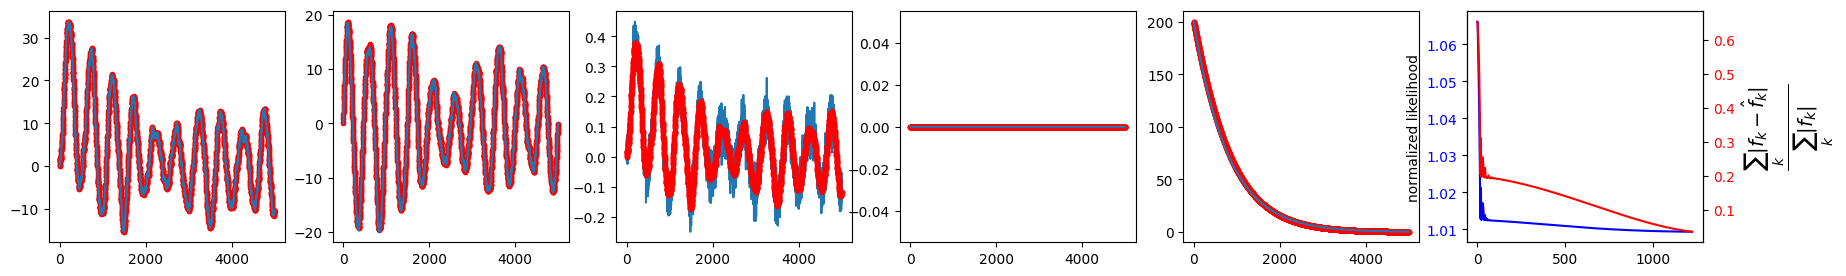

In [24]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])
ax=plt.subplot(175)
ax.plot(fs_hats.detach().numpy()[:,1], color="red",marker='.')
ax.plot(f[:,1])

ax=plt.subplot(176)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)


In [37]:
history["params"][4]

[array(1.6777, dtype=float32),
 array(-0.00103082, dtype=float32),
 array([0.64584786, 0.9788142 ], dtype=float32)]

In [38]:
[history["params"][k][0] for k in range(3,len(history["params"])-1)]

[array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1

In [22]:
import pickle
itraj = 1
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"
os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)

In [35]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/PROFILE_only_gamma/"
with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)
hsitory_prof = aa

In [25]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"

os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)


with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)

history_der = aa

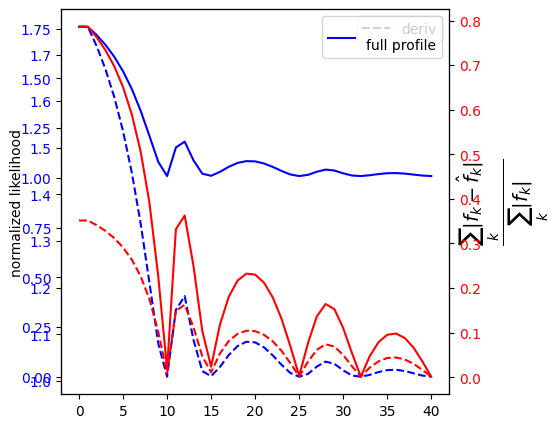

In [41]:
plt.figure(figsize=(5,5))
ax=plt.subplot()
ll = np.stack(history_der["losses"])
ax.plot(ll[:,0], '--',color="blue",label="deriv")
ax.legend()
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], '--', color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

ll = np.stack(hsitory_prof["losses"])
ax.plot(ll[:,0], color="blue",  label="\nfull profile")
ax.tick_params(axis='y', labelcolor="blue")

ax.legend()
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")


### Let's check now the amplitude!

In [125]:
xs_hat.shape

torch.Size([5002, 6])

In [131]:
[history["params"][k] for k in range(3,len(params))]

[[array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)]]

In [122]:
ll={}
for j in range(len(history["params"][0])):
    l[j] = [history["params"][k][j] for k in len(history["params"])]

TypeError: len() of unsized object

In [118]:
history["params"]

[array(nan, dtype=float32),
 array(nan, dtype=float32),
 array([nan, nan], dtype=float32),
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float3